In [ ]:
!pip install numpy==1.23.1 --force-reinstall
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 103.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.23.1-cp311-cp311-linux_x86_64.whl size=19731202 sha256=b4c52e80571143cdb88da7e450dd29e36c7cc65a37bff9f166b303f18f4b4095
  Stored in directory: /root/.cache/pip/wheels/54/67/ec/c3e57b4b51328fb39dd4d63906b0d3bd37a312508e5922682f
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.5.1 requires numpy>=1.26, but you have numpy 1.23.1 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.1 whic

In [ ]:
import numpy
numpy.version.version

'1.23.1'

In [ ]:
import numpy as np
import random
import torch
import os

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [ ]:
from PIL import Image

In [ ]:
class Vocab():
    def __init__(self, chars):
        self.pad = 0
        self.go = 1
        self.eos = 2
        self.mask_token = 3

        self.chars = chars

        self.c2i = {c:i+4 for i, c in enumerate(chars)}

        self.i2c = {i+4:c for i, c in enumerate(chars)}

        self.i2c[0] = '<pad>'
        self.i2c[1] = '<sos>'
        self.i2c[2] = '<eos>'
        self.i2c[3] = '*'

    def encode(self, chars):
        return [self.go] + [self.c2i[c] for c in chars] + [self.eos]

    def decode(self, ids):
        first = 1 if self.go in ids else 0
        last = ids.index(self.eos) if self.eos in ids else None
        sent = ''.join([self.i2c[i] for i in ids[first:last]])
        return sent

    def __len__(self):
        return len(self.c2i) + 4

    def batch_decode(self, arr):
        texts = [self.decode(ids) for ids in arr]
        return texts

    def __str__(self):
        return self.chars


# Backbone

## VGG

In [ ]:
from torch import nn
from torchvision import models
from einops import rearrange
from torchvision.models._utils import IntermediateLayerGetter


class Vgg(nn.Module):
    def __init__(self, name, ss, ks, hidden, pretrained=True, dropout=0.5):
        super(Vgg, self).__init__()

        if name == 'vgg11_bn':
            cnn = models.vgg11_bn(pretrained=pretrained)
        elif name == 'vgg19_bn':
            cnn = models.vgg19_bn(pretrained=pretrained)

        pool_idx = 0

        for i, layer in enumerate(cnn.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                cnn.features[i] = torch.nn.AvgPool2d(kernel_size=ks[pool_idx], stride=ss[pool_idx], padding=0)
                pool_idx += 1

        self.features = cnn.features
        self.dropout = nn.Dropout(dropout)
        self.last_conv_1x1 = nn.Conv2d(512, hidden, 1)

    def forward(self, x):
        """
        Shape:
            - x: (N, C, H, W)
            - output: (W, N, C)
        """

        conv = self.features(x)
        conv = self.dropout(conv)
        conv = self.last_conv_1x1(conv)

#        conv = rearrange(conv, 'b d h w -> b d (w h)')
        conv = conv.transpose(-1, -2)
        conv = conv.flatten(2)
        conv = conv.permute(-1, 0, 1)
        return conv

def vgg11_bn(ss, ks, hidden, pretrained=True, dropout=0.5):
    return Vgg('vgg11_bn', ss, ks, hidden, pretrained, dropout)

def vgg19_bn(ss, ks, hidden, pretrained=True, dropout=0.5):
    return Vgg('vgg19_bn', ss, ks, hidden, pretrained, dropout)



## RESNET50

In [ ]:
from torch import nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = self._conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = self._conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def _conv3x3(self, in_planes, out_planes, stride=1):
        "3x3 convolution with padding"
        return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                         padding=1, bias=False)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, input_channel, output_channel, block, layers):
        super(ResNet, self).__init__()

        self.output_channel_block = [int(output_channel / 4), int(output_channel / 2), output_channel, output_channel]

        self.inplanes = int(output_channel / 8)
        self.conv0_1 = nn.Conv2d(input_channel, int(output_channel / 16),
                                 kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0_1 = nn.BatchNorm2d(int(output_channel / 16))
        self.conv0_2 = nn.Conv2d(int(output_channel / 16), self.inplanes,
                                 kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0_2 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer1 = self._make_layer(block, self.output_channel_block[0], layers[0])
        self.conv1 = nn.Conv2d(self.output_channel_block[0], self.output_channel_block[
                               0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.output_channel_block[0])

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer2 = self._make_layer(block, self.output_channel_block[1], layers[1], stride=1)
        self.conv2 = nn.Conv2d(self.output_channel_block[1], self.output_channel_block[
                               1], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.output_channel_block[1])

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1))
        self.layer3 = self._make_layer(block, self.output_channel_block[2], layers[2], stride=1)
        self.conv3 = nn.Conv2d(self.output_channel_block[2], self.output_channel_block[
                               2], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.output_channel_block[2])

        self.layer4 = self._make_layer(block, self.output_channel_block[3], layers[3], stride=1)
        self.conv4_1 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[
                                 3], kernel_size=2, stride=(2, 1), padding=(0, 1), bias=False)
        self.bn4_1 = nn.BatchNorm2d(self.output_channel_block[3])
        self.conv4_2 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[
                                 3], kernel_size=2, stride=1, padding=0, bias=False)
        self.bn4_2 = nn.BatchNorm2d(self.output_channel_block[3])

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv0_1(x)
        x = self.bn0_1(x)
        x = self.relu(x)
        x = self.conv0_2(x)
        x = self.bn0_2(x)
        x = self.relu(x)

        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool2(x)
        x = self.layer2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.maxpool3(x)
        x = self.layer3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.layer4(x)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        conv = self.relu(x)

        conv = conv.transpose(-1, -2)
        conv = conv.flatten(2)
        conv = conv.permute(-1, 0, 1)

        return conv

def Resnet50(ss, hidden):
    return ResNet(3, hidden, BasicBlock, [1, 2, 5, 3])



## CNN

In [ ]:
from torch import nn

class CNN(nn.Module):
    def __init__(self, backbone, **kwargs):
        super(CNN, self).__init__()

        if backbone == 'vgg11_bn':
            self.model = vgg11_bn(**kwargs)
        elif backbone == 'vgg19_bn':
            self.model = vgg19_bn(**kwargs)
        elif backbone == 'resnet50':
            self.model = Resnet50(**kwargs)

    def forward(self, x):
        return self.model(x)

    def freeze(self):
        for name, param in self.model.features.named_parameters():
            if name != 'last_conv_1x1':
                param.requires_grad = False

    def unfreeze(self):
        for param in self.model.features.parameters():
            param.requires_grad = True


## LanguageTransformer

In [ ]:
from einops import rearrange
from torchvision import models
import math
from torch import nn

class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size,
                 d_model, nhead,
                 num_encoder_layers, num_decoder_layers,
                 dim_feedforward, max_seq_length,
                 pos_dropout, trans_dropout):
        super().__init__()

        self.d_model = d_model
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead,
                                          num_encoder_layers, num_decoder_layers,
                                          dim_feedforward, trans_dropout)

        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Shape:
            - src: (W, N, C)
            - tgt: (T, N)
            - src_key_padding_mask: (N, S)
            - tgt_key_padding_mask: (N, T)
            - memory_key_padding_mask: (N, S)
            - output: (N, T, E)

        """
        device = src.device
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(src.device)
        tgt = tgt.to(self.embed_tgt.weight.device)
        src = self.pos_enc(src*math.sqrt(self.d_model))

        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = output.transpose(0, 1)
        return self.fc(output)

    def gen_nopeek_mask(self, length):
        mask = (torch.triu(torch.ones(length, length)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

        return mask

    def forward_encoder(self, src):
        src = self.pos_enc(src*math.sqrt(self.d_model))
        memory = self.transformer.encoder(src)
        return memory

    def forward_decoder(self, tgt, memory):
        device = memory.device
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(device)
        tgt = tgt.to(device)
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        tgt = tgt.to(self.embed_tgt.weight.device)

        output = self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask)
        output = output.transpose(0, 1)

        return self.fc(output), memory

    def expand_memory(self, memory, beam_size):
        memory = memory.repeat(1, beam_size, 1)
        return memory

    def get_memory(self, memory, i):
        memory = memory[:, [i], :]
        return memory

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pos_embed = nn.Embedding(max_len, d_model)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x):
        seq_len = x.size(0)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device)
        pos = pos.unsqueeze(-1).expand(x.size()[:2])
        x = x + self.pos_embed(pos)
        return self.dropout(self.layernorm(x))

class LayerNorm(nn.Module):
    "A layernorm module in the TF style (epsilon inside the square root)."
    def __init__(self, d_model, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta  = nn.Parameter(torch.zeros(d_model))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


## Seq2seq

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, emb_dim, enc_hid_dim, dec_hid_dim, dropout, device):
        super().__init__()

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        """
        src: src_len x batch_size x img_channel
        outputs: src_len x batch_size x hid_dim
        hidden: batch_size x hid_dim
        """

        embedded = self.dropout(src)

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs):
        """
        hidden: batch_size x hid_dim
        encoder_outputs: src_len x batch_size x hid_dim,
        outputs: batch_size x src_len
        """

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))

        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim = 1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        """
        inputs: batch_size
        hidden: batch_size x hid_dim
        encoder_outputs: src_len x batch_size x hid_dim
        """

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)

        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))

        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, encoder_hidden, decoder_hidden, img_channel, decoder_embedded, dropout=0.1):
        super().__init__()

        attn = Attention(encoder_hidden, decoder_hidden)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = Encoder(img_channel, encoder_hidden, decoder_hidden, dropout, device)
        self.decoder = Decoder(vocab_size, decoder_embedded, encoder_hidden, decoder_hidden, dropout, attn)

    def forward_encoder(self, src):
        """
        src: timestep x batch_size x channel
        hidden: batch_size x hid_dim
        encoder_outputs: src_len x batch_size x hid_dim
        """

        encoder_outputs, hidden = self.encoder(src)

        return (hidden, encoder_outputs)

    def forward_decoder(self, tgt, memory):
        """
        tgt: timestep x batch_size
        hidden: batch_size x hid_dim
        encouder: src_len x batch_size x hid_dim
        output: batch_size x 1 x vocab_size
        """

        tgt = tgt[-1]
        hidden, encoder_outputs = memory
        output, hidden, _ = self.decoder(tgt, hidden, encoder_outputs)
        output = output.unsqueeze(1)

        return output, (hidden, encoder_outputs)

    def forward(self, src, trg):
        """
        src: time_step x batch_size
        trg: time_step x batch_size
        outputs: batch_size x time_step x vocab_size
        """

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        device = src.device

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)
        encoder_outputs, hidden = self.encoder(src)

        for t in range(trg_len):
            input = trg[t]
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output

        outputs = outputs.transpose(0, 1).contiguous()

        return outputs

    def expand_memory(self, memory, beam_size):
        hidden, encoder_outputs = memory
        hidden = hidden.repeat(beam_size, 1)
        encoder_outputs = encoder_outputs.repeat(1, beam_size, 1)

        return (hidden, encoder_outputs)

    def get_memory(self, memory, i):
        hidden, encoder_outputs = memory
        hidden = hidden[[i]]
        encoder_outputs = encoder_outputs[:, [i],:]

        return (hidden, encoder_outputs)


## ConvSeq2Seq

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self,
                 emb_dim,
                 hid_dim,
                 n_layers,
                 kernel_size,
                 dropout,
                 device,
                 max_length = 512):
        super().__init__()

        assert kernel_size % 2 == 1, "Kernel size must be odd!"

        self.device = device

        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        self.pos_embedding = nn.Embedding(max_length, emb_dim)

        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim,
                                              out_channels = 2 * hid_dim,
                                              kernel_size = kernel_size,
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src = src.transpose(0, 1)

        batch_size = src.shape[0]
        src_len = src.shape[1]
        device = src.device

        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device)

        #embed tokens and positions
        tok_embedded = src

        pos_embedded = self.pos_embedding(pos)

        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)

        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)

        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1)

        #begin convolutional blocks...

        for i, conv in enumerate(self.convs):

            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #set conv_input to conved for next loop iteration
            conv_input = conved

        #...end convolutional blocks

        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))

        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale

        return conved, combined

class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 emb_dim,
                 hid_dim,
                 n_layers,
                 kernel_size,
                 dropout,
                 trg_pad_idx,
                 device,
                 max_length = 512):
        super().__init__()

        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device

        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)

        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)

        self.fc_out = nn.Linear(emb_dim, output_dim)

        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim,
                                              out_channels = 2 * hid_dim,
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))

        combined = (conved_emb + embedded) * self.scale

        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))

        attention = F.softmax(energy, dim=2)

        attended_encoding = torch.matmul(attention, encoder_combined)

        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)

        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale

        return attention, attended_combined

    def forward(self, trg, encoder_conved, encoder_combined):
        trg = trg.transpose(0, 1)

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        device = trg.device

        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(device)

        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)

        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)

        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)

        #conv_input = [batch size, trg len, hid dim]

        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1)

        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]

        for i, conv in enumerate(self.convs):

            #apply dropout
            conv_input = self.dropout(conv_input)

            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size,
                                  hid_dim,
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(device)

            padded_conv_input = torch.cat((padding, conv_input), dim = 2)

            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #calculate attention
            attention, conved = self.calculate_attention(embedded,
                                                         conved,
                                                         encoder_conved,
                                                         encoder_combined)

            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #set conv_input to conved for next loop iteration
            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))
        output = self.fc_out(self.dropout(conved))

        return output, attention

class ConvSeq2Seq(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, enc_layers, dec_layers, enc_kernel_size, dec_kernel_size, enc_max_length, dec_max_length, dropout, pad_idx, device):
        super().__init__()

        enc = Encoder(emb_dim, hid_dim, enc_layers, enc_kernel_size, dropout, device, enc_max_length)
        dec = Decoder(vocab_size, emb_dim, hid_dim, dec_layers, dec_kernel_size, dropout, pad_idx, device, dec_max_length)

        self.encoder = enc
        self.decoder = dec

    def forward_encoder(self, src):
        encoder_conved, encoder_combined = self.encoder(src)

        return encoder_conved, encoder_combined

    def forward_decoder(self, trg, memory):
        encoder_conved, encoder_combined = memory
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)

        return output, (encoder_conved, encoder_combined)

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)

        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus
        #  positional embeddings
        encoder_conved, encoder_combined = self.encoder(src)

        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]

        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)

        return output#, attention


## TransformerOCR

In [ ]:
from torch import nn

class VietOCR(nn.Module):
    def __init__(self, vocab_size,
                 backbone,
                 cnn_args,
                 transformer_args, seq_modeling='transformer'):

        super(VietOCR, self).__init__()

        self.cnn = CNN(backbone, **cnn_args)
        self.seq_modeling = seq_modeling

        device = transformer_args.pop('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        if seq_modeling == 'transformer':
            self.transformer = LanguageTransformer(vocab_size, **transformer_args)
            self.transformer.to(device)
        elif seq_modeling == 'seq2seq':
            print("Transformer Args for Seq2Seq:", transformer_args)
            self.transformer = Seq2Seq(vocab_size, **transformer_args)
            self.transformer.to(device)
        elif seq_modeling == 'convseq2seq':
            self.transformer = ConvSeq2Seq(vocab_size, **transformer_args)
        else:
            raise('Not Support Seq Model')

    def forward(self, img, tgt_input, tgt_key_padding_mask):
        """
        Shape:
            - img: (N, C, H, W)
            - tgt_input: (T, N)
            - tgt_key_padding_mask: (N, T)
            - output: b t v
        """
        src = self.cnn(img)

        if self.seq_modeling == 'transformer':
            outputs = self.transformer(src, tgt_input, tgt_key_padding_mask=tgt_key_padding_mask)
        elif self.seq_modeling == 'seq2seq':
            outputs = self.transformer(src, tgt_input)
        elif self.seq_modeling == 'convseq2seq':
            outputs = self.transformer(src, tgt_input)
        return outputs



# Tool

## Translate

In [ ]:
import math
from PIL import Image
from torch.nn.functional import log_softmax, softmax

def translate(img, model, max_seq_length=128, sos_token=1, eos_token=2):
    model.eval()
    device = img.device


    with torch.no_grad():
        src = model.cnn(img)
        memory = model.transformer.forward_encoder(src)

        translated_sentence = [[sos_token]*len(img)]
        char_probs = [[1]*len(img)]

        max_length = 0

        while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T==eos_token, axis=1)):

            tgt_inp = torch.LongTensor(translated_sentence).to(device)

            output, memory = model.transformer.forward_decoder(tgt_inp, memory)
            output = softmax(output, dim=-1)
            output = output.to(device)

            indices = output[:, -1, :].argmax(dim=-1)
            values = output[:, -1, :].max(dim=-1)[0]
            translated_sentence.append(indices.tolist())
            char_probs.append(values.tolist())
            max_length += 1

            del output

        translated_sentence = np.asarray(translated_sentence).T
        char_probs = np.asarray(char_probs).T
        char_probs = np.multiply(char_probs, translated_sentence>3)
        char_probs = np.sum(char_probs, axis=-1) / np.maximum((char_probs > 0).sum(-1), 1)

    return translated_sentence, char_probs


def build_model(config):
    vocab = Vocab(config['vocab'])
    device = config['device']

    transformer_args = config['transformer']
    transformer_args['device'] = device


    model = VietOCR(
        vocab_size=len(vocab),
        backbone=config['backbone'],
        cnn_args=config['cnn'],
        transformer_args=transformer_args,
        seq_modeling=config['seq_modeling']
    )

    model = model.to(device)
    #model = model.cuda()

    return model, vocab

def resize(w, h, expected_height, image_min_width, image_max_width):
    new_w = int(expected_height * float(w) / float(h))
    round_to = 10
    new_w = math.ceil(new_w/round_to)*round_to
    new_w = max(new_w, image_min_width)
    new_w = min(new_w, image_max_width)

    return new_w, expected_height

def process_image(image, image_height, image_min_width, image_max_width):
    img = image.convert('RGB')

    w, h = img.size
    new_w, image_height = resize(w, h, image_height, image_min_width, image_max_width)

    img = img.resize((new_w, image_height), Image.Resampling.LANCZOS)

    img = np.asarray(img).transpose(2,0, 1)
    img = img/255
    return img

def process_input(image, image_height, image_min_width, image_max_width):
    img = process_image(image, image_height, image_min_width, image_max_width)
    img = img[np.newaxis, ...]
    img = torch.FloatTensor(img)
    return img

def predict(filename, config):
    img = Image.open(filename)
    img = process_input(img)

    img = img.to(config['device'])

    model, vocab = build_model(config)
    s = translate(img, model)[0].tolist()
    s = vocab.decode(s)

    return s


## CreateDataset

In [ ]:
!pip install lmdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import sys
import lmdb
import cv2
from tqdm import tqdm

In [ ]:
def checkImageIsValid(imageBin):
    isvalid = True
    imgH = None
    imgW = None

    imageBuf = np.fromstring(imageBin, dtype=np.uint8)
    try:
        img = cv2.imdecode(imageBuf, cv2.IMREAD_GRAYSCALE)

        imgH, imgW = img.shape[0], img.shape[1]
        if imgH * imgW == 0:
            isvalid = False
    except Exception as e:
        isvalid = False

    return isvalid, imgH, imgW

def writeCache(env, cache):
    with env.begin(write=True) as txn:
        for k, v in cache.items():
            txn.put(k.encode(), v)

def createDataset(outputPath, root_dir, annotation_path):
    """
    Create LMDB dataset for CRNN training.
    ARGS:
        outputPath    : LMDB output path
        imagePathList : list of image path
        labelList     : list of corresponding groundtruth texts
        lexiconList   : (optional) list of lexicon lists
        checkValid    : if true, check the validity of every image
    """
    if not os.path.exists(annotation_path):
        raise FileNotFoundError(f"File annotation không tồn tại: {annotation_path}")

    with open(annotation_path, 'r', encoding='utf-8') as ann_file:
        lines = ann_file.readlines()
        annotations = [l.strip().split('\t') for l in lines]

    # DEBUG
    for i in range(len(annotations)):
        try:
            imageFile, label = annotations[i]
        except ValueError:
            print(f"Error in index {i}: {annotations[i]}")
            raise ValueError(f"Error in index {i}: {annotations[i]}")

    nSamples = len(annotations)
    env = lmdb.open(outputPath, map_size=10 * 1024 ** 3)
    cache = {}
    cnt = 0
    error = 0

    pbar = tqdm(range(nSamples), ncols = 100, desc='Create {}'.format(outputPath))
    for i in pbar:
        imageFile, label = annotations[i]
        imagePath = os.path.join(root_dir, imageFile)

        if not os.path.exists(imagePath):
            error += 1
            continue

        with open(imagePath, 'rb') as f:
            imageBin = f.read()
        isvalid, imgH, imgW = checkImageIsValid(imageBin)

        if not isvalid:
            error += 1
            continue

        imageKey = 'image-%09d' % cnt
        labelKey = 'label-%09d' % cnt
        pathKey = 'path-%09d' % cnt
        dimKey = 'dim-%09d' % cnt

        cache[imageKey] = imageBin
        cache[labelKey] = label.encode()
        cache[pathKey] = imageFile.encode()
        cache[dimKey] = np.array([imgH, imgW], dtype=np.int32).tobytes()

        cnt += 1

        if cnt % 1000 == 0:
            writeCache(env, cache)
            cache = {}

    nSamples = cnt
    cache['num-samples'] = str(nSamples).encode()
    writeCache(env, cache)

    if error > 0:
        print('Remove {} invalid images'.format(error))
    print('Created dataset with %d samples' % nSamples)
    sys.stdout.flush()



## Logger

In [ ]:
class Logger():
    def __init__(self, fname):
        path, _ = os.path.split(fname)
        os.makedirs(path, exist_ok=True)

        self.logger = open(fname, 'w')

    def log(self, string):
        self.logger.write(string+'\n')
        self.logger.flush()

    def close(self):
        self.logger.close()

## Compute Accuracy

In [ ]:
def compute_accuracy(ground_truth, predictions, mode='full_sequence'):
    """
    Computes accuracy
    :param ground_truth:
    :param predictions:
    :param display: Whether to print values to stdout
    :param mode: if 'per_char' is selected then
                 single_label_accuracy = correct_predicted_char_nums_of_single_sample / single_label_char_nums
                 avg_label_accuracy = sum(single_label_accuracy) / label_nums
                 if 'full_sequence' is selected then
                 single_label_accuracy = 1 if the prediction result is exactly the same as label else 0
                 avg_label_accuracy = sum(single_label_accuracy) / label_nums
    :return: avg_label_accuracy
    """
    if mode == 'per_char':

        accuracy = []

        for index, label in enumerate(ground_truth):
            prediction = predictions[index]
            total_count = len(label)
            correct_count = 0
            try:
                for i, tmp in enumerate(label):
                    if tmp == prediction[i]:
                        correct_count += 1
            except IndexError:
                continue
            finally:
                try:
                    accuracy.append(correct_count / total_count)
                except ZeroDivisionError:
                    if len(prediction) == 0:
                        accuracy.append(1)
                    else:
                        accuracy.append(0)
        avg_accuracy = np.mean(np.array(accuracy).astype(np.float32), axis=0)
    elif mode == 'full_sequence':
        try:
            correct_count = 0
            for index, label in enumerate(ground_truth):
                prediction = predictions[index]
                if prediction == label:
                    correct_count += 1
            avg_accuracy = correct_count / len(ground_truth)
        except ZeroDivisionError:
            if not predictions:
                avg_accuracy = 1
            else:
                avg_accuracy = 0
    else:
        raise NotImplementedError('Other accuracy compute mode has not been implemented')

    return avg_accuracy

## Load config yml

In [ ]:
import yaml

url_config = {
        'vgg_transformer':'vgg-transformer.yml',
        'resnet_transformer':'resnet_transformer.yml',
        'resnet_fpn_transformer':'resnet_fpn_transformer.yml',
        'vgg_seq2seq':'vgg-seq2seq.yml',
        'vgg_convseq2seq':'vgg_convseq2seq.yml',
        'vgg_decoderseq2seq':'vgg_decoderseq2seq.yml',
        'base':'base.yml',
        }


class Cfg(dict):
    def __init__(self, config_dict):
        super(Cfg, self).__init__(**config_dict)
        self.__dict__ = self

    @staticmethod
    def load_config_from_name(name):
        with open(base_config_path, encoding='utf-8') as f:
            base_config = yaml.safe_load(f)

        with open(seq2seq_config_path, encoding='utf-8') as f:
            config = yaml.safe_load(f)

        base_config.update(config)
        return Cfg(base_config)

    @staticmethod
    def load_config(base_config_path, config_path):
        with open(base_config_path, encoding='utf-8') as f:
            base_config = yaml.safe_load(f)

        with open(config_path, encoding='utf-8') as f:
            config = yaml.safe_load(f)

        base_config.update(config)
        return Cfg(base_config)



    def save(self, fname):
        with open(fname, 'w') as outfile:
            yaml.dump(dict(self), outfile, default_flow_style=False, allow_unicode=True)



# DataLoader

## DataLoader_v1

In [ ]:
!pip install prefetch_generator

  Preparing metadata (setup.py) ... done
  Created wheel for prefetch_generator: filename=prefetch_generator-1.0.3-py3-none-any.whl size=4758 sha256=71a79c2abecfb2e9e9946e17d5a55c22cd9f1885303ed15f324b313002ef686c
  Stored in directory: /root/.cache/pip/wheels/9b/08/01/8bacc997ecb83922063bc7dadb42f3cb52cfe43b5217caf820
Successfully built prefetch_generator


In [ ]:
from collections import defaultdict
import math
from prefetch_generator import background

In [ ]:
class BucketData(object):
    def __init__(self, device):
        self.max_label_len = 0
        self.data_list = []
        self.label_list = []
        self.file_list = []
        self.device = device

    def append(self, datum, label, filename):
        self.data_list.append(datum)
        self.label_list.append(label)
        self.file_list.append(filename)

        self.max_label_len = max(len(label), self.max_label_len)

        return len(self.data_list)

    def flush_out(self):
        """
        Shape:
            - img: (N, C, H, W)
            - tgt_input: (T, N)
            - tgt_output: (N, T)
            - tgt_padding_mask: (N, T)
        """
        # encoder part
        img = np.array(self.data_list, dtype=np.float32)

        # decoder part
        target_weights = []
        tgt_input = []
        for label in self.label_list:
            label_len = len(label)

            tgt = np.concatenate((
                label,
                np.zeros(self.max_label_len - label_len, dtype=np.int32)))
            tgt_input.append(tgt)

            one_mask_len = label_len - 1

            target_weights.append(np.concatenate((
                np.ones(one_mask_len, dtype=np.float32),
                np.zeros(self.max_label_len - one_mask_len,dtype=np.float32))))

        # reshape to fit input shape
        tgt_input = np.array(tgt_input, dtype=np.int64).T
        tgt_output = np.roll(tgt_input, -1, 0).T
        tgt_output[:, -1]=0

        tgt_padding_mask = np.array(target_weights)==0

        filenames = self.file_list

        self.data_list, self.label_list, self.file_list = [], [], []
        self.max_label_len = 0

        rs = {
            'img': torch.FloatTensor(img).to(self.device),
            'tgt_input': torch.LongTensor(tgt_input).to(self.device),
            'tgt_output': torch.LongTensor(tgt_output).to(self.device),
            'tgt_padding_mask':torch.BoolTensor(tgt_padding_mask).to(self.device),
            'filenames': filenames
        }

        return rs

    def __len__(self):
        return len(self.data_list)

    def __iadd__(self, other):
        self.data_list += other.data_list
        self.label_list += other.label_list
        self.max_label_len = max(self.max_label_len, other.max_label_len)
        self.max_width = max(self.max_width, other.max_width)

    def __add__(self, other):
        res = BucketData()
        res.data_list = self.data_list + other.data_list
        res.label_list = self.label_list + other.label_list
        res.max_width = max(self.max_width, other.max_width)
        res.max_label_len = max((self.max_label_len, other.max_label_len))
        return res

class DataGen(object):

    def __init__(self,data_root, annotation_fn, vocab, device, image_height=32, image_min_width=32, image_max_width=512):

        self.image_height = image_height
        self.image_min_width = image_min_width
        self.image_max_width = image_max_width

        self.data_root = data_root
        self.annotation_path = os.path.join(data_root, annotation_fn)

        self.vocab = vocab
        self.device = device

        self.clear()

    def clear(self):
        self.bucket_data = defaultdict(lambda: BucketData(self.device))

    @background(max_prefetch=1)
    def gen(self, batch_size, last_batch=True):
        with open(self.annotation_path, 'r') as ann_file:
            lines = ann_file.readlines()
            np.random.shuffle(lines)
            for l in lines:

                img_path, lex = l.strip().split('\t')

                img_path = os.path.join(self.data_root, img_path)

                try:
                    img_bw, word = self.read_data(img_path, lex)
                except IOError:
                    print('ioread image:{}'.format(img_path))

                width = img_bw.shape[-1]

                bs = self.bucket_data[width].append(img_bw, word, img_path)
                if bs >= batch_size:
                    b = self.bucket_data[width].flush_out()
                    yield b

        if last_batch:
            for bucket in self.bucket_data.values():
                if len(bucket) > 0:
                    b = bucket.flush_out()
                    yield b

        self.clear()

    def read_data(self, img_path, lex):

        with open(img_path, 'rb') as img_file:
            img = Image.open(img_file).convert('RGB')
            img_bw = process_image(img, self.image_height, self.image_min_width, self.image_max_width)

        word = self.vocab.encode(lex)

        return img_bw, word



## DataLoader

In [ ]:
import sys
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from collections import defaultdict
import lmdb
import six
import time
from tqdm import tqdm

from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler

In [ ]:
class OCRDataset(Dataset):
    def __init__(self, lmdb_path, root_dir, annotation_path, vocab, image_height=32, image_min_width=32, image_max_width=512, transform=None):
        self.root_dir = root_dir
        self.annotation_path = os.path.join(root_dir, annotation_path)
        self.vocab = vocab
        self.transform = transform

        self.image_height = image_height
        self.image_min_width = image_min_width
        self.image_max_width = image_max_width

        self.lmdb_path =  lmdb_path

        if os.path.isdir(self.lmdb_path):
            print('{} exists. Remove folder if you want to create new dataset'.format(self.lmdb_path))
            sys.stdout.flush()
        else:
            createDataset(self.lmdb_path, root_dir, annotation_path)

        self.env = lmdb.open(
            self.lmdb_path,
            max_readers=8,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False)
        self.txn = self.env.begin(write=False)

        nSamples = int(self.txn.get('num-samples'.encode()))
        self.nSamples = nSamples

        self.build_cluster_indices()

    def build_cluster_indices(self):
        self.cluster_indices = defaultdict(list)

        pbar = tqdm(range(self.__len__()),
                desc='{} build cluster'.format(self.lmdb_path),
                ncols = 100, position=0, leave=True)

        for i in pbar:
            bucket = self.get_bucket(i)
            self.cluster_indices[bucket].append(i)


    def get_bucket(self, idx):
        key = 'dim-%09d'%idx

        dim_img = self.txn.get(key.encode())
        if dim_img is None:
            print(f"Dimension not found for idx {idx}")
            return 0

        dim_img = np.fromstring(dim_img, dtype=np.int32)
        imgH, imgW = dim_img

        new_w, image_height = resize(imgW, imgH, self.image_height, self.image_min_width, self.image_max_width)

        return new_w

    def read_buffer(self, idx):
        img_file = 'image-%09d'%idx
        label_file = 'label-%09d'%idx
        path_file = 'path-%09d'%idx

        imgbuf = self.txn.get(img_file.encode())

        label = self.txn.get(label_file.encode()).decode()
        img_path = self.txn.get(path_file.encode()).decode()

        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        return buf, label, img_path

    def read_data(self, idx):
        buf, label, img_path = self.read_buffer(idx)

        img = Image.open(buf).convert('RGB')

        if self.transform:
            img = self.transform(img)

        img_bw = process_image(img, self.image_height, self.image_min_width, self.image_max_width)

        word = self.vocab.encode(label)

        return img_bw, word, img_path

    def __getitem__(self, idx):
        img, word, img_path = self.read_data(idx)

        img_path = os.path.join(self.root_dir, img_path)

        sample = {'img': img, 'word': word, 'img_path': img_path}

        return sample

    def __len__(self):
        return self.nSamples

class ClusterRandomSampler(Sampler):

    def __init__(self, data_source, batch_size, shuffle=True):
        self.data_source = data_source
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.save_indices = []

    def flatten_list(self, lst):
        return [item for sublist in lst for item in sublist]

    def __iter__(self):
        batch_lists = []
        for cluster, cluster_indices in self.data_source.cluster_indices.items():
            if self.shuffle:
                random.shuffle(cluster_indices)

            batches = [cluster_indices[i:i + self.batch_size] for i in range(0, len(cluster_indices), self.batch_size)]
            batches = [_ for _ in batches if len(_) == self.batch_size]
            if self.shuffle:
                random.shuffle(batches)

            batch_lists.append(batches)

        lst = self.flatten_list(batch_lists)
        if self.shuffle:
            random.shuffle(lst)

        lst = self.flatten_list(lst)
        self.save_indices = lst[:]

        return iter(lst)

    def __len__(self):
        return len(self.data_source)

class Collator(object):
    def __init__(self, masked_language_model=True):
        self.masked_language_model = masked_language_model

    def __call__(self, batch):
        if len(batch) == 0:
            print("Batch is empty in Collator.")
            return None
        filenames = []
        img = []
        target_weights = []
        tgt_input = []
        max_label_len = max(len(sample['word']) for sample in batch)
        for sample in batch:
            img.append(sample['img'])
            filenames.append(sample['img_path'])
            label = sample['word']
            label_len = len(label)


            tgt = np.concatenate((
                label,
                np.zeros(max_label_len - label_len, dtype=np.int32)))
            tgt_input.append(tgt)

            one_mask_len = label_len - 1

            target_weights.append(np.concatenate((
                np.ones(one_mask_len, dtype=np.float32),
                np.zeros(max_label_len - one_mask_len,dtype=np.float32))))

        if len(img) == 0:
            print("No valid images in batch.")
            return None

        img = np.array(img, dtype=np.float32)


        tgt_input = np.array(tgt_input, dtype=np.int64).T
        tgt_output = np.roll(tgt_input, -1, 0).T
        tgt_output[:, -1]=0

        # random mask token
        if self.masked_language_model:
            mask = np.random.random(size=tgt_input.shape) < 0.05
            mask = mask & (tgt_input != 0) & (tgt_input != 1) & (tgt_input != 2)
            tgt_input[mask] = 3

        tgt_padding_mask = np.array(target_weights)==0

        rs = {
            'img': torch.tensor(img, dtype=torch.float32).to(torch.device("cuda")),
            'tgt_input': torch.LongTensor(tgt_input),
            'tgt_output': torch.LongTensor(tgt_output),
            'tgt_padding_mask': torch.BoolTensor(tgt_padding_mask),
            'filenames': filenames
        }

        return rs


## Image Agumentation

In [ ]:
!pip install --no-deps imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 13.0 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from imgaug import augmenters as iaa
import imgaug as ia

/usr/local/lib/python3.11/dist-packages/imgaug/augmentables/kps.py:5: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.1)
  import scipy.spatial.distance


In [ ]:
class ImgAugTransform:
  def __init__(self):
    sometimes = lambda aug: iaa.Sometimes(0.3, aug)

    self.aug = iaa.Sequential(iaa.SomeOf((1, 5),
        [
        # blur

        sometimes(iaa.OneOf([iaa.GaussianBlur(sigma=(0, 1.0)),
                            iaa.MotionBlur(k=3)])),

        # color
        sometimes(iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)),
        sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6), per_channel=True)),
        sometimes(iaa.Invert(0.25, per_channel=0.5)),
        sometimes(iaa.Solarize(0.5, threshold=(32, 128))),
        sometimes(iaa.Dropout2d(p=0.5)),
        sometimes(iaa.Multiply((0.5, 1.5), per_channel=0.5)),
        sometimes(iaa.Add((-40, 40), per_channel=0.5)),

        sometimes(iaa.JpegCompression(compression=(5, 80))),

        # distort
        sometimes(iaa.Crop(percent=(0.01, 0.05), sample_independently=True)),
        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.01))),
        sometimes(iaa.Affine(scale=(0.7, 1.3), translate_percent=(-0.1, 0.1),
#                            rotate=(-5, 5), shear=(-5, 5),
                            order=[0, 1], cval=(0, 255),
                            mode=ia.ALL)),
        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.01))),
        sometimes(iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                            iaa.CoarseDropout(p=(0, 0.1), size_percent=(0.02, 0.25))])),

    ],
        random_order=True),
    random_order=True)

  def __call__(self, img):
    img = np.array(img)
    img = self.aug.augment_image(img)
    img = Image.fromarray(img)
    return img


# Optimize

## LabelSmoothingLoss

In [ ]:
from torch import nn

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = int(padding_idx)

    def forward(self, pred, target):
      pred = pred.log_softmax(dim=self.dim)
      with torch.no_grad():
          true_dist = torch.zeros_like(pred)
          true_dist.fill_(self.smoothing / (self.cls - 2))
          true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
          true_dist[:, self.padding_idx] = 0

          mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
          if mask.dim() > 0:
              mask = mask.squeeze()
              if mask.numel() > 0:
                  mask = mask.to(pred.device)
                  true_dist.index_fill_(0, mask, 0.0)
      # print("true_dist.device:", true_dist.device)
      # print("mask.device:", mask.device)
      # print("pred.device:", pred.device)

      return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

## ScheduledOptim

In [ ]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, init_lr, n_warmup_steps):
        assert n_warmup_steps > 0, 'must be greater than 0'

        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }

        return optimizer_state_dict

    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']

        self._optimizer.load_state_dict(state_dict['_optimizer'])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1

        for param_group in self._optimizer.param_groups:
            lr = self.init_lr*self._get_lr_scale()
            self.lr = lr

            param_group['lr'] = lr


# Trainer

In [ ]:
from torch.optim import Adam, SGD, AdamW
from torch import nn

import yaml

from torch.utils.data import DataLoader
from einops import rearrange
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR, OneCycleLR

import torchvision

from PIL import Image
import matplotlib.pyplot as plt
import time

In [ ]:
class Trainer():
    def __init__(self, config, pretrained=True, augmentor=ImgAugTransform()):

        self.config = config
        self.device = torch.device(config['device'])
        self.model, self.vocab = build_model(config)
        self.model.vocab = self.vocab
        self.model.to(self.device)

        self.num_iters = config['trainer']['iters']
        self.beamsearch = config['predictor']['beamsearch']

        self.data_root = config['dataset']['data_root']
        self.train_annotation = config['dataset']['train_annotation']
        self.valid_annotation = config['dataset']['valid_annotation']
        self.dataset_name = config['dataset']['name']

        self.batch_size = config['trainer']['batch_size']
        self.print_every = config['trainer']['print_every']
        self.valid_every = config['trainer']['valid_every']

        self.image_aug = config['aug']['image_aug']
        self.masked_language_model = config['aug']['masked_language_model']

        self.checkpoint = config['trainer']['checkpoint']
        self.export_weights = config['trainer']['export']
        self.metrics = config['trainer']['metrics']
        logger = config['trainer']['log']

        if logger:
            self.logger = Logger(logger)

        if pretrained:
            weight_file = config['weights']
            self.load_weights(weight_file)
            self.model.eval()

        self.iter = 0

        self.optimizer = AdamW(self.model.parameters(), betas=(0.9, 0.98), eps=1e-09)
        self.scheduler = OneCycleLR(self.optimizer, total_steps=self.num_iters, **config['optimizer'])

        self.criterion = LabelSmoothingLoss(len(self.vocab), padding_idx=self.vocab.pad, smoothing=0.1)

        transforms = None
        if self.image_aug:
            transforms =  augmentor

        self.train_gen = self.data_gen(
          lmdb_path=self.config['dataset']['train_data_root'],
          data_root=self.config['dataset']['train_data_root'],
          annotation=self.config['dataset']['train_annotation'],
          masked_language_model=True,
          transform=transforms
        )

        self.valid_gen = self.data_gen(
          lmdb_path=self.config['dataset']['valid_data_root'],
          data_root=self.config['dataset']['valid_data_root'],
          annotation=self.config['dataset']['valid_annotation'],
          masked_language_model=False,
          transform=transforms
        )

        self.train_losses = []

    def train(self):
        total_loss = 0

        total_loader_time = 0
        total_gpu_time = 0
        best_acc = 0

        data_iter = iter(self.train_gen)

        for i in range(self.num_iters):
            self.iter += 1

            start = time.time()

            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(self.train_gen)
                batch = next(data_iter)

            print("Filenames:", batch['filenames'][:5])
            print("Target input (IDs):", batch['tgt_input'][0])
            print("Target input (text):", trainer.vocab.decode(batch['tgt_input'][0].tolist()))
            total_loader_time += time.time() - start

            start = time.time()
            loss = self.step(batch)
            total_gpu_time += time.time() - start

            total_loss += loss
            self.train_losses.append((self.iter, loss))

            if self.iter % self.print_every == 0:
                info = 'iter: {:06d} - train loss: {:.3f} - lr: {:.2e} - load time: {:.2f} - gpu time: {:.2f}'.format(self.iter,
                        total_loss/self.print_every, self.optimizer.param_groups[0]['lr'],
                        total_loader_time, total_gpu_time)

                total_loss = 0
                total_loader_time = 0
                total_gpu_time = 0
                print(info)
                self.logger.log(info)

            if self.valid_annotation and self.iter % self.valid_every == 0:
                val_loss = self.validate()
                acc_full_seq, acc_per_char = self.precision(self.metrics)

                info = 'iter: {:06d} - valid loss: {:.3f} - acc full seq: {:.4f} - acc per char: {:.4f}'.format(self.iter, val_loss, acc_full_seq, acc_per_char)
                print(info)
                self.logger.log(info)

                if acc_full_seq > best_acc:
                    self.save_weights(self.export_weights)
                    best_acc = acc_full_seq

    def batch_to_device(self, batch):
        # img = batch['img'].to(self.device, non_blocking=True)
        device = self.device
        img = batch['img'].to(device, dtype=torch.float32, non_blocking=True)
        tgt_input = batch['tgt_input'].to(device, non_blocking=True)
        tgt_output = batch['tgt_output'].to(device, non_blocking=True)
        tgt_padding_mask = batch['tgt_padding_mask'].to(device, non_blocking=True)


        def ensure_tensor(x, dtype):
          if isinstance(x, np.ndarray):
              x = torch.tensor(x, dtype=dtype, device=device)
          elif isinstance(x, torch.Tensor):
              x = x.to(device=device, dtype=dtype)
          return x

        batch = {
                'img': ensure_tensor(batch['img'], torch.float32),
                # 'tgt_input':tgt_input,
                # 'tgt_output':tgt_output, 'tgt_padding_mask':tgt_padding_mask,
                'filenames': batch['filenames'],
                'tgt_input': ensure_tensor(batch['tgt_input'], torch.long),
                'tgt_output': ensure_tensor(batch['tgt_output'], torch.long),
                'tgt_padding_mask': ensure_tensor(batch['tgt_padding_mask'], torch.bool)
                }

        # print(batch)
        return batch

    def levenshtein_distance(self, s1, s2):
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)

        if len(s2) == 0:
            return len(s1)

        previous_row = list(range(len(s2) + 1))
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row

        return previous_row[-1]

    def compute_cer(self, pred_texts, gt_texts):
        total_distance = 0
        total_chars = 0

        # print("Pred text: ", pred_texts)
        # print("GT text: ", gt_texts)

        for pred, gt in zip(pred_texts, gt_texts):
            total_distance += self.levenshtein_distance(pred, gt)
            total_chars += len(gt)

        return total_distance / total_chars if total_chars > 0 else 0.0

    def validate(self):
        total_loss = 0.0
        all_preds = []
        all_gts = []
        total_samples = 0

        self.model.eval()
        with torch.no_grad():
            for i, batch in enumerate(self.valid_gen):
                batch = self.batch_to_device(batch)

                img = batch['img']
                tgt_input = batch['tgt_input']
                tgt_output = batch['tgt_output']
                tgt_padding_mask = batch['tgt_padding_mask']

                outputs = self.model(img, tgt_input, tgt_padding_mask)

                # Lưu tgt_output gốc để decode sau
                tgt_output_orig = tgt_output

                # Reshape để tính loss
                outputs = outputs.view(-1, outputs.size(2))
                tgt_output = tgt_output.view(-1)

                loss = self.criterion(outputs, tgt_output)
                total_loss += loss.item()
                total_samples += 1

                # Lưu lại GT và Pred
                pred_tokens = outputs.argmax(dim=-1).view(tgt_output_orig.shape[0], -1)
                pred_texts = self.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = self.vocab.batch_decode(tgt_output_orig.tolist())

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
        cer = self.compute_cer(all_preds, all_gts)

        return avg_loss, cer


    def predict(self, sample=None, verbose=True, show_image=False):
      self.model.eval()

      pred_sents = []
      actual_sents = []
      img_files = []
      all_probs = []

      with torch.no_grad():
          for i, batch in enumerate(self.valid_gen):
              batch = self.batch_to_device(batch)

              translated_sentence, batch_prob = translate(batch['img'], self.model)
              pred_sent = self.vocab.batch_decode(translated_sentence.tolist())
              actual_sent = self.vocab.batch_decode(batch['tgt_output'].tolist())

              pred_sents.extend(pred_sent)
              actual_sents.extend(actual_sent)
              img_files.extend(batch['filenames'])
              all_probs.extend(batch_prob)
      return pred_sents, actual_sents, img_files, all_probs


    def precision(self, sample=None):
        self.model.eval()
        with torch.no_grad():
          pred_sents, actual_sents, _, _ = self.predict(sample=sample)

        acc_full_seq = compute_accuracy(actual_sents, pred_sents, mode='full_sequence')
        acc_per_char = compute_accuracy(actual_sents, pred_sents, mode='per_char')

        return acc_full_seq, acc_per_char

    def visualize_prediction(self, sample=16, errorcase=False, fontname='serif', fontsize=16):

        pred_sents, actual_sents, img_files, probs = self.predict(sample)

        if errorcase:
            wrongs = []
            for i in range(len(img_files)):
                if pred_sents[i]!= actual_sents[i]:
                    wrongs.append(i)

            pred_sents = [pred_sents[i] for i in wrongs]
            actual_sents = [actual_sents[i] for i in wrongs]
            img_files = [img_files[i] for i in wrongs]
            probs = [probs[i] for i in wrongs]

        img_files = img_files[:sample]

        fontdict = {
                'family':fontname,
                'size':fontsize
                }

        for vis_idx in range(0, len(img_files)):
            img_path = img_files[vis_idx]
            pred_sent = pred_sents[vis_idx]
            actual_sent = actual_sents[vis_idx]
            prob = probs[vis_idx]

            img = Image.open(open(img_path, 'rb'))
            plt.figure()
            plt.imshow(img)
            plt.title('prob: {:.3f} - pred: {} - actual: {}'.format(prob, pred_sent, actual_sent), loc='left', fontdict=fontdict)
            plt.axis('off')

        plt.show()

    def visualize_dataset(self, sample=16, fontname='serif'):
        n = 0
        for batch in self.train_gen:
            for i in range(self.batch_size):
                img = batch['img'][i].numpy().transpose(1,2,0)
                sent = self.vocab.decode(batch['tgt_input'].T[i].tolist())

                plt.figure()
                plt.title('sent: {}'.format(sent), loc='center', fontname=fontname)
                plt.imshow(img)
                plt.axis('off')

                n += 1
                if n >= sample:
                    plt.show()
                    return


    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)

        optim = ScheduledOptim(
	       Adam(self.model.parameters(), betas=(0.9, 0.98), eps=1e-09),
            	self.config['transformer']['d_model'], **self.config['optimizer'])

        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.model.load_state_dict(checkpoint['state_dict'])
        self.iter = checkpoint['iter']

        self.train_losses = checkpoint['train_losses']

    def save_checkpoint(self, filename):
        state = {'iter':self.iter, 'state_dict': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(), 'train_losses': self.train_losses}

        path, _ = os.path.split(filename)
        os.makedirs(path, exist_ok=True)

        torch.save(state, filename)

    def load_weights(self, filename):
        state_dict = torch.load(filename, map_location=torch.device(self.device))

        for name, param in self.model.named_parameters():
            if name not in state_dict:
                print('{} not found'.format(name))
            elif state_dict[name].shape != param.shape:
                print('{} missmatching shape, required {} but found {}'.format(name, param.shape, state_dict[name].shape))
                del state_dict[name]

        self.model.load_state_dict(state_dict, strict=False)

    def save_weights(self, filename):
        path, _ = os.path.split(filename)
        os.makedirs(path, exist_ok=True)

        torch.save(self.model.state_dict(), filename)

    def data_gen(self, lmdb_path, data_root, annotation, masked_language_model=True, transform=None):
        dataset = OCRDataset(lmdb_path=lmdb_path,
                root_dir=data_root, annotation_path=annotation,
                vocab=self.vocab, transform=transform,
                image_height=self.config['dataset']['image_height'],
                image_min_width=self.config['dataset']['image_min_width'],
                image_max_width=self.config['dataset']['image_max_width'])

        if 'val' in annotation.lower():
            print("This is validation file")
            sampler = ClusterRandomSampler(dataset, self.batch_size, shuffle=False)
        else:
            sampler = ClusterRandomSampler(dataset, self.batch_size, shuffle=True)
        collate_fn = Collator(masked_language_model)

        loader_kwargs = self.config['dataloader'].copy()
        loader_kwargs['pin_memory'] = False

        gen = DataLoader(
                dataset,
                batch_size=self.batch_size,
                sampler=sampler,
                collate_fn = collate_fn,
                shuffle=False,
                drop_last=False,
                **loader_kwargs
                )
        return gen

    def data_gen_v1(self, lmdb_path, data_root, annotation):
        data_gen = DataGen(data_root, annotation, self.vocab, 'cpu',
                image_height = self.config['dataset']['image_height'],
                image_min_width = self.config['dataset']['image_min_width'],
                image_max_width = self.config['dataset']['image_max_width'])
        return data_gen

    def step(self, batch):
        self.model.train()

        batch = self.batch_to_device(batch)

        img, tgt_input, tgt_output, tgt_padding_mask = batch['img'], batch['tgt_input'], batch['tgt_output'], batch['tgt_padding_mask']


        outputs = self.model(img, tgt_input, tgt_key_padding_mask=tgt_padding_mask)
        outputs = outputs.view(-1, outputs.size(2))#flatten(0, 1)
        tgt_output = tgt_output.view(-1)#flatten()


        loss = self.criterion(outputs, tgt_output)

        self.optimizer.zero_grad()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)

        self.optimizer.step()
        self.scheduler.step()

        loss_item = loss.item()

        return loss_item


# Predictor

In [ ]:
class Predictor:
    def __init__(self, config, pretrained = True, model = None):
        self.config = config
        self.device = torch.device(config["device"])

        # === Use passed-in model or build a new one
        if model is not None:
            self.model = model.to(self.device)
            self.vocab = model.vocab
        else:
            self.model, self.vocab = build_model(config)
            self.model.to(self.device)

            # === Load pretrained weights if requested
            if pretrained:
                weights = config["trainer"]["checkpoint"]
                if os.path.exists(weights):
                    self.model.load_state_dict(torch.load(weights, map_location=self.device))
                else:
                    raise FileNotFoundError(f"Checkpoint file not found at {weights}")

        self.num_iters = config['trainer']['iters']

        self.data_root = config['dataset']['data_root']
        self.train_annotation = config['dataset']['train_annotation']
        self.valid_annotation = config['dataset']['valid_annotation']
        self.dataset_name = config['dataset']['name']

        self.batch_size = config['trainer']['batch_size']
        self.print_every = config['trainer']['print_every']
        self.valid_every = config['trainer']['valid_every']

        self.image_aug = config['aug']['image_aug']
        self.masked_language_model = config['aug']['masked_language_model']

        self.checkpoint = config['trainer']['checkpoint']
        self.export_weights = config['trainer']['export']
        self.metrics = config['trainer']['metrics']
        logger = config['trainer']['log']
        self.criterion = LabelSmoothingLoss(len(self.vocab), padding_idx=self.vocab.pad, smoothing=0.1)

        self.valid_gen = self.data_gen(
          lmdb_path=self.config['dataset']['valid_data_root'],
          data_root=self.config['dataset']['valid_data_root'],
          annotation=self.config['dataset']['valid_annotation'],
          masked_language_model=False
        )

    def batch_to_device(self, batch):
        # img = batch['img'].to(self.device, non_blocking=True)
        device = self.device
        img = batch['img'].to(device, dtype=torch.float32, non_blocking=True)
        tgt_input = batch['tgt_input'].to(device, non_blocking=True)
        tgt_output = batch['tgt_output'].to(device, non_blocking=True)
        tgt_padding_mask = batch['tgt_padding_mask'].to(device, non_blocking=True)


        def ensure_tensor(x, dtype):
          if isinstance(x, np.ndarray):
              x = torch.tensor(x, dtype=dtype, device=device)
          elif isinstance(x, torch.Tensor):
              x = x.to(device=device, dtype=dtype)
          return x

        batch = {
                'img': ensure_tensor(batch['img'], torch.float32),
                # 'tgt_input':tgt_input,
                # 'tgt_output':tgt_output, 'tgt_padding_mask':tgt_padding_mask,
                'filenames': batch['filenames'],
                'tgt_input': ensure_tensor(batch['tgt_input'], torch.long),
                'tgt_output': ensure_tensor(batch['tgt_output'], torch.long),
                'tgt_padding_mask': ensure_tensor(batch['tgt_padding_mask'], torch.bool)
                }

        return batch

    def validate(self):
        total_loss = 0.0
        all_preds = []
        all_gts = []
        total_samples = 0

        self.model.eval()
        with torch.no_grad():
            for i, batch in enumerate(self.valid_gen):
                batch = self.batch_to_device(batch)

                img = batch['img']
                tgt_input = batch['tgt_input']
                tgt_output = batch['tgt_output']
                tgt_padding_mask = batch['tgt_padding_mask']

                outputs = self.model(img, tgt_input, tgt_padding_mask)

                # Lưu tgt_output gốc để decode sau
                tgt_output_orig = tgt_output

                # Reshape để tính loss
                outputs = outputs.view(-1, outputs.size(2))
                tgt_output = tgt_output.view(-1)

                loss = self.criterion(outputs, tgt_output)
                total_loss += loss.item()
                total_samples += 1

                # Lưu lại GT và Pred
                pred_tokens = outputs.argmax(dim=-1).view(tgt_output_orig.shape[0], -1)
                pred_texts = self.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = self.vocab.batch_decode(tgt_output_orig.tolist())

                # for idx, (gt, pred) in enumerate(zip(gt_texts, pred_texts)):
                #     print(f"[Sample {idx}] GT: {gt} | PRED: {pred}")

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
        cer = self.compute_cer(all_preds, all_gts)

        return avg_loss, cer


    def predict(self, sample=None, verbose=True, show_image=False):
      self.model.eval()

      pred_sents = []
      actual_sents = []
      img_files = []
      all_probs = []

      with torch.no_grad():
          for i, batch in enumerate(self.valid_gen):
              batch = self.batch_to_device(batch)

              translated_sentence, batch_prob = translate(batch['img'], self.model)
              pred_sent = self.vocab.batch_decode(translated_sentence.tolist())
              actual_sent = self.vocab.batch_decode(batch['tgt_output'].tolist())

              pred_sents.extend(pred_sent)
              actual_sents.extend(actual_sent)
              img_files.extend(batch['filenames'])
              all_probs.extend(batch_prob)
      return pred_sents, actual_sents, img_files, all_probs


    def precision(self, sample=None):
        self.model.eval()
        with torch.no_grad():
          pred_sents, actual_sents, _, _ = self.predict(sample=sample)

        acc_full_seq = compute_accuracy(actual_sents, pred_sents, mode='full_sequence')
        acc_per_char = compute_accuracy(actual_sents, pred_sents, mode='per_char')

        return acc_full_seq, acc_per_char

    def visualize_prediction(self, sample=16, errorcase=False, fontname='serif', fontsize=16):
        pred_sents, actual_sents, img_files, probs = self.predict(sample)
        if errorcase:
            wrongs = []
            for i in range(len(img_files)):
                if pred_sents[i]!= actual_sents[i]:
                    wrongs.append(i)

            pred_sents = [pred_sents[i] for i in wrongs]
            actual_sents = [actual_sents[i] for i in wrongs]
            img_files = [img_files[i] for i in wrongs]
            probs = [probs[i] for i in wrongs]

        img_files = img_files[:sample]

        fontdict = {
                'family':fontname,
                'size':fontsize
                }

        for vis_idx in range(0, len(img_files)):
            img_path = img_files[vis_idx]
            pred_sent = pred_sents[vis_idx]
            actual_sent = actual_sents[vis_idx]
            prob = probs[vis_idx]

            img = Image.open(open(img_path, 'rb'))
            plt.figure()
            plt.imshow(img)
            plt.title('prob: {:.3f} - pred: {} - actual: {}'.format(prob, pred_sent, actual_sent), loc='left', fontdict=fontdict)
            plt.axis('off')

        plt.show()

    def visualize_dataset(self, sample=16, fontname='serif'):
        n = 0
        for batch in self.train_gen:
            for i in range(self.batch_size):
                img = batch['img'][i].numpy().transpose(1,2,0)
                sent = self.vocab.decode(batch['tgt_input'].T[i].tolist())

                plt.figure()
                plt.title('sent: {}'.format(sent), loc='center', fontname=fontname)
                plt.imshow(img)
                plt.axis('off')

                n += 1
                if n >= sample:
                    plt.show()
                    return


    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)

        optim = ScheduledOptim(
	       Adam(self.model.parameters(), betas=(0.9, 0.98), eps=1e-09),
            	self.config['transformer']['d_model'], **self.config['optimizer'])

        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.model.load_state_dict(checkpoint['state_dict'])
        self.iter = checkpoint['iter']

        self.train_losses = checkpoint['train_losses']

    def save_checkpoint(self, filename):
        state = {'iter':self.iter, 'state_dict': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(), 'train_losses': self.train_losses}

        path, _ = os.path.split(filename)
        os.makedirs(path, exist_ok=True)

        torch.save(state, filename)

    def load_weights(self, filename):
        state_dict = torch.load(filename, map_location=torch.device(self.device))

        for name, param in self.model.named_parameters():
            if name not in state_dict:
                print('{} not found'.format(name))
            elif state_dict[name].shape != param.shape:
                print('{} missmatching shape, required {} but found {}'.format(name, param.shape, state_dict[name].shape))
                del state_dict[name]

        self.model.load_state_dict(state_dict, strict=False)

    def save_weights(self, filename):
        path, _ = os.path.split(filename)
        os.makedirs(path, exist_ok=True)

        torch.save(self.model.state_dict(), filename)

    def data_gen(self, lmdb_path, data_root, annotation, masked_language_model=True, transform=None):
        dataset = OCRDataset(lmdb_path=lmdb_path,
                root_dir=data_root, annotation_path=annotation,
                vocab=self.vocab, transform=transform,
                image_height=self.config['dataset']['image_height'],
                image_min_width=self.config['dataset']['image_min_width'],
                image_max_width=self.config['dataset']['image_max_width'])

        if 'val' in annotation.lower():
            print("This is validation file")
            sampler = ClusterRandomSampler(dataset, self.batch_size, shuffle=False)
        else:
            sampler = ClusterRandomSampler(dataset, self.batch_size, shuffle=True)
        collate_fn = Collator(masked_language_model)

        loader_kwargs = self.config['dataloader'].copy()
        loader_kwargs['pin_memory'] = False

        gen = DataLoader(
                dataset,
                batch_size=self.batch_size,
                sampler=sampler,
                collate_fn = collate_fn,
                shuffle=False,
                drop_last=False,
                # **self.config['dataloader']
                **loader_kwargs
                )
        # print("gen:", gen)
        return gen

    def data_gen_v1(self, lmdb_path, data_root, annotation):
        data_gen = DataGen(data_root, annotation, self.vocab, 'cpu',
                image_height = self.config['dataset']['image_height'],
                image_min_width = self.config['dataset']['image_min_width'],
                image_max_width = self.config['dataset']['image_max_width'])
        # print(data_gen)
        return data_gen

    def levenshtein_distance(self, s1, s2):
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)

        if len(s2) == 0:
            return len(s1)

        previous_row = list(range(len(s2) + 1))
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row

        return previous_row[-1]

    def compute_cer(self, pred_texts, gt_texts):
        total_distance = 0
        total_chars = 0

        for pred, gt in zip(pred_texts, gt_texts):
            total_distance += self.levenshtein_distance(pred, gt)
            total_chars += len(gt)

        return total_distance / total_chars if total_chars > 0 else 0.0


# Mount to Google Drive and Define root

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = "/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code"

# Config

In [ ]:
def update_fold_config(base_yaml_path, output_yaml_path, fold_path):
    with open(base_yaml_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)

    config['dataset']['data_root'] = fold_path
    # config['dataset']['train_data_root'] = r"{root}/train/train_data".format(root = root)
    # config['dataset']['valid_data_root'] = r"{root}/val/val_data".format(root = root)
    config['dataset']['train_data_root'] = os.path.join(fold_path, 'train/train_data')
    config['dataset']['valid_data_root'] = os.path.join(fold_path, 'val/val_data')

    config['dataset']['train_annotation'] = os.path.join(fold_path, 'train/train_ocr_fixed.txt')
    config['dataset']['valid_annotation'] = os.path.join(fold_path, 'val/val_ocr_fixed.txt')

    # config['trainer']['export'] = os.path.join(fold_path, 'model.pth')
    config['trainer']['checkpoint'] = os.path.join(fold_path, 'checkpoint.pth')
    config['trainer']['log'] = os.path.join(fold_path, 'train.log')

    with open(output_yaml_path, 'w', encoding='utf-8') as f:
        yaml.safe_dump(config, f)

# Evaluation on pretrain model

## Transformer

In [ ]:
from logging import log
import csv
from datetime import datetime

base_config_path = "{root}/config/base.yml".format(root = root)
transformer_config_path = "{root}/config/vgg-transformer.yml".format(root = root)

def evaluate_all_folds(pretrained_ckpt_path, model, num_folds=3):
    results_path = os.path.join(root, f"pretrained_results_{model}.csv")

    with open(results_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([
            'fold', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'timestamp'
        ])

        for fold in range(num_folds):
            print(f"\nEvaluating Fold {fold}...")
            log = f"\nEvaluating Fold {fold}...\n"
            fold_str = str(fold)
            fold_path = os.path.join(root, "folds", f"fold_{fold_str}")
            print(fold_path)

            config_path = os.path.join(root, "config", f"base_fold_{fold_str}.yml")

            # Update and load config for current fold
            update_fold_config(base_config_path, config_path, fold_path)
            config = Cfg.load_config(config_path, transformer_config_path)
            config['weights'] = pretrained_ckpt_path
            config['trainer']['checkpoint'] = pretrained_ckpt_path
            print("[CHECK] Loading weights from:", config['weights'])

            # Create predictor for validation
            predictor = Predictor(config, pretrained = True)

            predictor.model.eval()

            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

            # Print to log file
            print(f"[Fold {fold}] Pretrained Val Loss: {val_loss:.4f} | CER: {val_cer:.4f} | "
                  f"Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f}")

            writer.writerow([
                fold, val_loss, val_cer,
                acc_full_seq, acc_per_char, timestamp
            ])

            f.flush()

    print(f"\n Inference completed. Result saved at: {results_path}")

In [ ]:
pretrained_ckpt_path = f"/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/config/vgg_transformer.pth"
evaluate_all_folds(pretrained_ckpt_path = pretrained_ckpt_path, model = "transformer", num_folds=3)


Evaluating Fold 0...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/config/vgg_transformer.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 163MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_

/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu<ipython-input-25-3109057708>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu


This is validation file


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[Fold 0] Pretrained Val Loss: 0.7093 | CER: 0.0888 | Acc Full Seq: 0.4624 | Acc Per Char: 0.8354

Evaluating Fold 1...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/config/vgg_transformer.pth
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu


This is validation file
[Fold 1] Pretrained Val Loss: 0.6986 | CER: 0.0871 | Acc Full Seq: 0.4721 | Acc Per Char: 0.8516

Evaluating Fold 2...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/config/vgg_transformer.pth
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu


This is validation file
[Fold 2] Pretrained Val Loss: 0.7161 | CER: 0.0946 | Acc Full Seq: 0.4713 | Acc Per Char: 0.8371

 Inference completed. Result saved at: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/pretrained_results_transformer.csv


In [ ]:
import pandas as pd

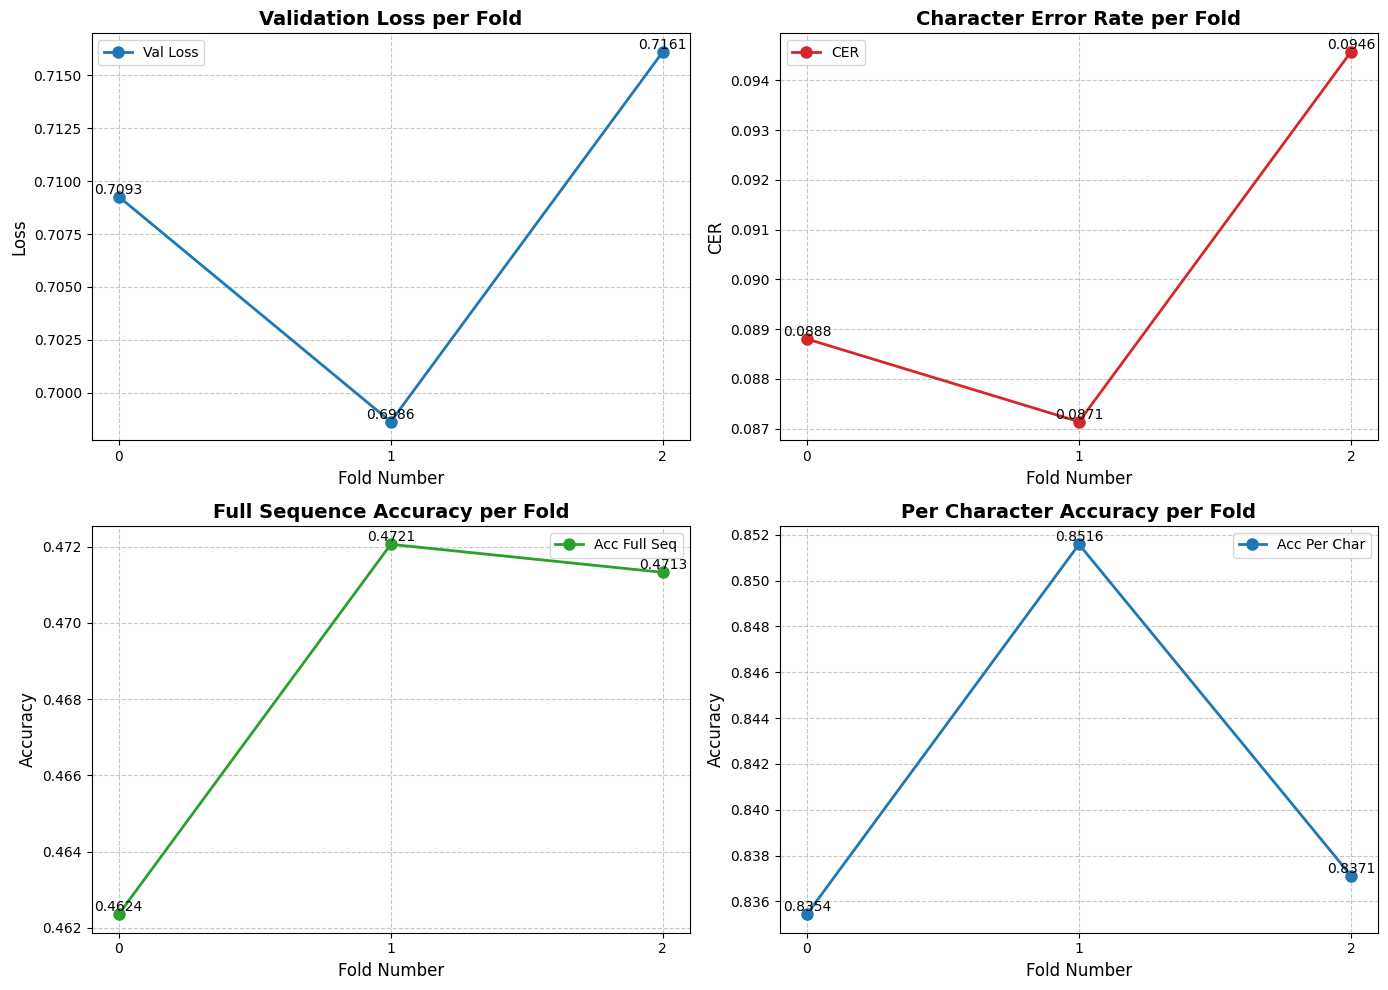

In [ ]:
# Path to your folds metrics CSV file
csv_path = f"{root}/pretrained_results_transformer.csv"

# Read CSV data
df = pd.read_csv(csv_path).sort_values('fold')

# Create a more polished 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#1f77b4', '#d62728', '#2ca02c', '#1f77b4']
titles = ['Validation Loss per Fold', 'Character Error Rate per Fold',
          'Full Sequence Accuracy per Fold', 'Per Character Accuracy per Fold']
ylabels = ['Loss', 'CER', 'Accuracy', 'Accuracy']
metrics = ['val_loss', 'val_cer', 'acc_full_seq', 'acc_per_char']
labels = ['Val Loss', 'CER', 'Acc Full Seq', 'Acc Per Char']

for i, ax in enumerate(axs.flat):
    ax.plot(df['fold'], df[metrics[i]], marker='o', linewidth=2, markersize=8, color=colors[i], label=labels[i])
    for x, y in zip(df['fold'], df[metrics[i]]):
        ax.text(x, y, f"{y:.4f}", fontsize=10, ha='center', va='bottom')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Fold Number', fontsize=12)
    ax.set_ylabel(ylabels[i], fontsize=12)
    ax.set_xticks(df['fold'])
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

## Seq2seq (LSTM)

In [ ]:
from logging import log
import csv
from datetime import datetime

base_config_path = "{root}/config/base.yml".format(root = root)
seq2seq_config_path = "{root}/config/vgg-seq2seq.yml".format(root = root)

def evaluate_all_folds(pretrained_ckpt_path, model, num_folds=3):
    results_path = os.path.join(root, f"pretrained_results_{model}.csv")

    with open(results_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([
            'fold', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'timestamp'
        ])

        for fold in range(num_folds):
            print(f"\nEvaluating Fold {fold}...")
            log = f"\nEvaluating Fold {fold}...\n"
            fold_str = str(fold)
            fold_path = os.path.join(root, "folds", f"fold_{fold_str}")
            print(fold_path)

            config_path = os.path.join(root, "config", f"base_fold_{fold_str}.yml")

            # Update and load config for current fold
            update_fold_config(base_config_path, config_path, fold_path)
            config = Cfg.load_config(config_path, seq2seq_config_path)
            config['weights'] = pretrained_ckpt_path
            config['trainer']['checkpoint'] = pretrained_ckpt_path
            # print("[CHECK] Loading weights from:", config['weights'])

            # Create predictor for validation
            predictor = Predictor(config, pretrained = True)

            predictor.model.eval()

            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

            # Print to log file
            print(f"[Fold {fold}] Pretrained Val Loss: {val_loss:.4f} | CER: {val_cer:.4f} | "
                  f"Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f}")

            writer.writerow([
                fold, val_loss, val_cer,
                acc_full_seq, acc_per_char, timestamp
            ])

            f.flush()

    print(f"\n Inference completed. Result saved at: {results_path}")


In [ ]:
pretrained_ckpt = f"{root}/config/vgg_seq2seq.pth"
evaluate_all_folds(pretrained_ckpt_path=pretrained_ckpt, model = 'lstm', num_folds=3)


Evaluating Fold 0...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu<ipython-input-25-3109057708>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Pretrained Val Loss: 0.6727 | CER: 0.0543 | Acc Full Seq: 0.5504 | Acc Per Char: 0.8867

Evaluating Fold 1...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Pretrained Val Loss: 0.6560 | CER: 0.0500 | Acc Full Seq: 0.5721 | Acc Per Char: 0.9026

Evaluating Fold 2...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Pretrained Val Loss: 0.6686 | CER: 0.0513 | Acc Full Seq: 0.5757 | Acc Per Char: 0.8905

 Inference completed. Result saved at: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/pretrained_results_lstm.csv


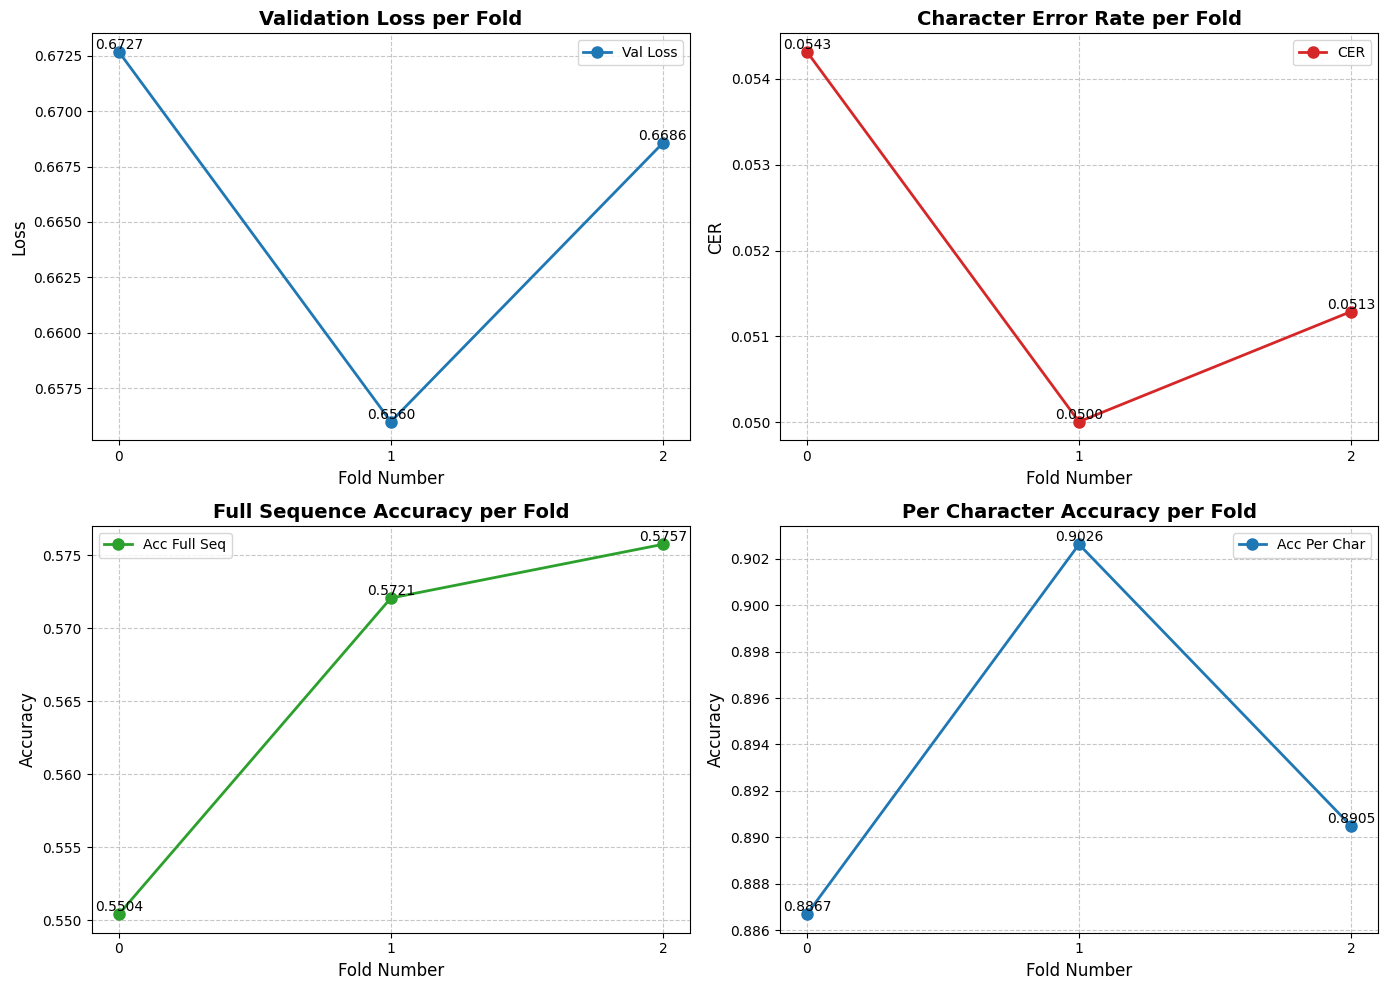

In [ ]:
# Path to your folds metrics CSV file
csv_path = f"{root}/pretrained_results_lstm.csv"

# Read CSV data
df = pd.read_csv(csv_path).sort_values('fold')

# Create a more polished 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#1f77b4', '#d62728', '#2ca02c', '#1f77b4']
titles = ['Validation Loss per Fold', 'Character Error Rate per Fold',
          'Full Sequence Accuracy per Fold', 'Per Character Accuracy per Fold']
ylabels = ['Loss', 'CER', 'Accuracy', 'Accuracy']
metrics = ['val_loss', 'val_cer', 'acc_full_seq', 'acc_per_char']
labels = ['Val Loss', 'CER', 'Acc Full Seq', 'Acc Per Char']

for i, ax in enumerate(axs.flat):
    ax.plot(df['fold'], df[metrics[i]], marker='o', linewidth=2, markersize=8, color=colors[i], label=labels[i])
    for x, y in zip(df['fold'], df[metrics[i]]):
        ax.text(x, y, f"{y:.4f}", fontsize=10, ha='center', va='bottom')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Fold Number', fontsize=12)
    ax.set_ylabel(ylabels[i], fontsize=12)
    ax.set_xticks(df['fold'])
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Training (finetune)

In [ ]:
from datetime import datetime
import csv

## Load model on test

In [ ]:
base_config_path = "{root}/config/base.yml".format(root = root)

def load_model(model, best_model_path, model_config_path, fold):
    print(f"\nEvaluating Fold {fold}...")

    fold_path = os.path.join(root, "folds", f"fold_{fold}")
    print(fold_path)

    config_path = os.path.join(root, "config", f"{model}_base_fold_{fold}.yml")

    # Update and load config for current fold
    update_fold_config(base_config_path, config_path, fold_path)
    config = Cfg.load_config(config_path, model_config_path)
    config['weights'] = best_model_path
    config['trainer']['checkpoint'] = best_model_path
    print("[CHECK] Loading weights from:", config['weights'])

    # Create predictor for validation
    predictor = Predictor(config, pretrained = True)

    predictor.model.eval()

    val_loss, val_cer = predictor.validate()
    acc_full_seq, acc_per_char = predictor.precision()
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Print
    print(f"[Fold {fold}] Val Loss: {val_loss:.4f} | CER: {val_cer:.4f} | "
          f"Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f}")


## Transformer

### Fold 0

In [ ]:
# === CONFIGURATION ===
base_config_path = "{root}/config/base.yml".format(root = root)
transformer_config_path = "{root}/config/vgg-transformer.yml".format(root = root)
fold = "0"
model = "Transformer"
log_file_path = r"{root}/folds/fold_0/fold_0_log.txt".format(root = root)
metrics_path = f"{root}/folds/fold_{fold}/{model}_metrics_fold_{fold}.csv"


# === TẠO LMDB CHO TRAIN VÀ VAL ===
def create_lmdb_for_train_and_val(fold_path):
    train_lmdb_path = "{root}/folds/fold_{fold}/train/train_data".format(root = root, fold = fold)
    val_lmdb_path = "{root}/folds/fold_{fold}/val/val_data".format(root = root, fold = fold)

    train_img_root = "{root}/folds/fold_{fold}/train/images".format(root = root, fold = fold)
    val_img_root = "{root}/val/folds/fold_{fold}/images".format(root = root, fold = fold)
    train_ann_path = "{root}/folds/fold_{fold}/train/train_ocr_fixed.txt".format(root = root, fold = fold)
    val_ann_path = "{root}/folds/fold_{fold}/val/val_ocr_fixed.txt".format(root = root, fold = fold)

    # Chỉ tạo lại LMDB nếu chưa tồn tại
    if not os.path.exists(train_lmdb_path):
        print(f"\nCreating LMDB for TRAIN: {train_lmdb_path}...")
        createDataset(
            outputPath=train_lmdb_path,
            root_dir=train_img_root,
            annotation_path=train_ann_path
        )
    else:
        print(f"LMDB for TRAIN already exists: {train_lmdb_path}")

    if not os.path.exists(val_lmdb_path):
        print(f"\nCreating LMDB for VALIDATION: {val_lmdb_path}...")
        createDataset(
            outputPath=val_lmdb_path,
            root_dir=val_img_root,
            annotation_path= val_ann_path
        )
    else:
        print(f"LMDB for VALIDATION already exists: {val_lmdb_path}")

# === TRAINING FOR FOLD TESTING ===
fold_path = f"{root}/folds/fold_{fold}"
updated_yaml_path = f"{root}/config/{model}_base_fold_{fold}.yml"

update_fold_config(base_config_path, updated_yaml_path, fold_path)
create_lmdb_for_train_and_val(fold_path)

# Load config and train using Trainer API directly
config = Cfg.load_config(updated_yaml_path, transformer_config_path)
trainer = Trainer(config)
print("Train gen:", trainer.train_gen)
print("Train gen length:", len(trainer.train_gen) if trainer.train_gen else "None")


def custom_train(trainer):
    with open(log_file_path, 'a', encoding='utf-8') as log_file, \
        open(metrics_path, 'w', newline='', encoding='utf-8') as csvfile:

        writer = csv.writer(csvfile)
        writer.writerow([
            'epoch', 'train_loss', 'train_cer', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'train_time', 'val_time'
        ])


        best_cer = float('inf')
        num_epochs = 20
        total_train_time = 0.0
        total_epoch_time = 0.0

        print(f"\nTraining Fold {fold}...\n")
        log_file.write(f"\nTraining Fold {fold}...\n")
        start_time = datetime.now()
        formatted_time = start_time.strftime('%Y-%m-%d %H:%M:%S')
        print(f"\n=== Training Started at: {formatted_time} ===")
        log_file.write(f"\n=== Training Started at: {formatted_time} ===\n")
        print(f"Model: {model}")
        log_file.write(f"Model: {model}")

        for epoch in range(1, num_epochs + 1):
            start_train = time.time()
            trainer.model.train()
            epoch_loss = 0.0

            all_preds = []
            all_gts = []

            for i, batch in enumerate(trainer.train_gen):
                loss = trainer.step(batch)
                epoch_loss += loss

                batch = trainer.batch_to_device(batch)
                pred_tokens = trainer.model(batch['img'], batch['tgt_input'], batch['tgt_padding_mask']).argmax(dim=-1)
                pred_texts = trainer.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = trainer.vocab.batch_decode(batch['tgt_output'].tolist())

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

            avg_loss = epoch_loss / len(trainer.train_gen)
            cer = trainer.compute_cer(all_preds, all_gts)

            end_train = time.time()
            train_duration = end_train - start_train

            print(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds\n")
            log_file.flush()

            predictor = Predictor(config, pretrained = False, model=trainer.model)
            predictor.model.eval()
            start_val = time.time()
            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            end_val = time.time()
            val_duration = end_val - start_val
            total_epoch_time = train_duration + val_duration
            total_train_time += total_epoch_time

            print(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds\n")
            log_file.flush()

            print(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds")
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds\n")

            writer.writerow([
                epoch, avg_loss, cer, val_loss, val_cer,
                acc_full_seq, acc_per_char, train_duration, val_duration
            ])
            csvfile.flush()

            if val_cer < best_cer:
                best_cer = val_cer
                best_model_path = "{root}/folds/fold_{fold}/{model}/best_model_epoch_{epoch}.pth".format(root = root, fold = fold, epoch = epoch, model = model)
                trainer.save_weights(best_model_path)
                print(f"Model improved at epoch {epoch}, saved to {best_model_path}")
                log_file.write(f"Model improved at epoch {epoch}, saved to {best_model_path}\n")
                log_file.flush()

        print(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===")
        log_file.write(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===\n")

custom_train(trainer)

LMDB for TRAIN already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data
LMDB for VALIDATION already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data build<ipython-input-25-3109057708>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data build

/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset



/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu


This is validation file
Train gen: <torch.utils.data.dataloader.DataLoader object at 0x7f0108d9af50>
Train gen length: 211

Training Fold 0...


=== Training Started at: 2025-06-17 05:54:30 ===
Model: Transformer


KeyboardInterrupt: 

In [ ]:
best_model_path = f"{root}/folds/fold_0/Transformer/best_model_epoch_17.pth"
model_config_path = "{root}/config/vgg-transformer.yml".format(root = root)
load_model("Transformer", best_model_path, model_config_path, "0")


Evaluating Fold 0...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/Transformer/best_model_epoch_17.pth
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu<ipython-input-25-3109057708>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Val Loss: 0.6590 | CER: 0.0370 | Acc Full Seq: 0.6641 | Acc Per Char: 0.9173


### Fold 1

In [ ]:
# === CONFIGURATION ===
base_config_path = "{root}/config/base.yml".format(root = root)
transformer_config_path = "{root}/config/vgg-transformer.yml".format(root = root)
fold = "1"
model = "Transformer"
log_file_path = r"{root}/folds/fold_1/fold_1_log.txt".format(root = root)
metrics_path = f"{root}/folds/fold_{fold}/{model}_metrics_fold_{fold}.csv"


# === TẠO LMDB CHO TRAIN VÀ VAL ===
def create_lmdb_for_train_and_val(fold_path):
    train_lmdb_path = "{root}/folds/fold_{fold}/train/train_data".format(root = root, fold = fold)
    val_lmdb_path = "{root}/folds/fold_{fold}/val/val_data".format(root = root, fold = fold)

    train_img_root = "{root}/folds/fold_{fold}/train/images".format(root = root, fold = fold)
    val_img_root = "{root}/val/folds/fold_{fold}/images".format(root = root, fold = fold)
    train_ann_path = "{root}/folds/fold_{fold}/train/train_ocr_fixed.txt".format(root = root, fold = fold)
    val_ann_path = "{root}/folds/fold_{fold}/val/val_ocr_fixed.txt".format(root = root, fold = fold)

    # Chỉ tạo lại LMDB nếu chưa tồn tại
    if not os.path.exists(train_lmdb_path):
        print(f"\nCreating LMDB for TRAIN: {train_lmdb_path}...")
        createDataset(
            outputPath=train_lmdb_path,
            root_dir=train_img_root,
            annotation_path=train_ann_path
        )
    else:
        print(f"LMDB for TRAIN already exists: {train_lmdb_path}")

    if not os.path.exists(val_lmdb_path):
        print(f"\nCreating LMDB for VALIDATION: {val_lmdb_path}...")
        createDataset(
            outputPath=val_lmdb_path,
            root_dir=val_img_root,
            annotation_path= val_ann_path
        )
    else:
        print(f"LMDB for VALIDATION already exists: {val_lmdb_path}")

# === TRAINING FOR FOLD TESTING ===
# start_all = time.time()

fold_path = f"{root}/folds/fold_{fold}"
updated_yaml_path = f"{root}/config/{model}_base_fold_{fold}.yml"

update_fold_config(base_config_path, updated_yaml_path, fold_path)
create_lmdb_for_train_and_val(fold_path)

# print(f"\nTraining Fold {fold}...")

# Load config and train using Trainer API directly
config = Cfg.load_config(updated_yaml_path, transformer_config_path)
trainer = Trainer(config)
print("Train gen:", trainer.train_gen)
print("Train gen length:", len(trainer.train_gen) if trainer.train_gen else "None")


def custom_train(trainer):
    with open(log_file_path, 'a', encoding='utf-8') as log_file, \
        open(metrics_path, 'w', newline='', encoding='utf-8') as csvfile:

        writer = csv.writer(csvfile)
        writer.writerow([
            'epoch', 'train_loss', 'train_cer', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'train_time', 'val_time'
        ])


        best_cer = float('inf')
        num_epochs = 20
        total_train_time = 0.0
        total_epoch_time = 0.0

        print(f"\nTraining Fold {fold}...\n")
        log_file.write(f"\nTraining Fold {fold}...\n")
        start_time = datetime.now()
        formatted_time = start_time.strftime('%Y-%m-%d %H:%M:%S')
        print(f"\n=== Training Started at: {formatted_time} ===")
        log_file.write(f"\n=== Training Started at: {formatted_time} ===\n")
        print(f"Model: {model}")
        log_file.write(f"Model: {model}")

        for epoch in range(1, num_epochs + 1):
            start_train = time.time()
            trainer.model.train()
            epoch_loss = 0.0

            all_preds = []
            all_gts = []

            for i, batch in enumerate(trainer.train_gen):
                loss = trainer.step(batch)
                epoch_loss += loss

                batch = trainer.batch_to_device(batch)
                pred_tokens = trainer.model(batch['img'], batch['tgt_input'], batch['tgt_padding_mask']).argmax(dim=-1)
                pred_texts = trainer.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = trainer.vocab.batch_decode(batch['tgt_output'].tolist())

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

            avg_loss = epoch_loss / len(trainer.train_gen)
            cer = trainer.compute_cer(all_preds, all_gts)

            end_train = time.time()
            train_duration = end_train - start_train

            print(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds\n")
            log_file.flush()

            predictor = Predictor(config, pretrained = False, model=trainer.model)
            predictor.model.eval()
            start_val = time.time()
            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            end_val = time.time()
            val_duration = end_val - start_val
            total_epoch_time = train_duration + val_duration
            total_train_time += total_epoch_time

            print(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds\n")
            log_file.flush()

            print(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds")
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds\n")

            writer.writerow([
                epoch, avg_loss, cer, val_loss, val_cer,
                acc_full_seq, acc_per_char, train_duration, val_duration
            ])
            csvfile.flush()

            if val_cer < best_cer:
                best_cer = val_cer
                best_model_path = "{root}/folds/fold_{fold}/{model}/best_model_epoch_{epoch}.pth".format(root = root, fold = fold, epoch = epoch, model = model)
                trainer.save_weights(best_model_path)
                print(f"Model improved at epoch {epoch}, saved to {best_model_path}")
                log_file.write(f"Model improved at epoch {epoch}, saved to {best_model_path}\n")
                log_file.flush()

        print(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===")
        log_file.write(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===\n")

custom_train(trainer)

LMDB for TRAIN already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data
LMDB for VALIDATION already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data build<ipython-input-25-04fd6a215ee4>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data build

/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset



/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu


This is validation file
Train gen: <torch.utils.data.dataloader.DataLoader object at 0x7d24e397ee50>
Train gen length: 212

Training Fold 1...


=== Training Started at: 2025-06-10 09:22:08 ===
Model: Transformer
[Fold 1] Epoch 1 - Train Loss: 0.6434 | Train CER: 0.0846 | Duration: 38.35 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 1 - Val Loss: 0.6582 | Val CER: 0.0547 | Acc Full Seq: 0.5566 | Acc Per Char: 0.8989 | Duration: 25.45 seconds
[Fold 1] Epoch 1 - Total Epoch Duration: 63.80 seconds
Model improved at epoch 1, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_1.pth
[Fold 1] Epoch 2 - Train Loss: 0.5985 | Train CER: 0.0567 | Duration: 38.46 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 2 - Val Loss: 0.6512 | Val CER: 0.0510 | Acc Full Seq: 0.5794 | Acc Per Char: 0.9045 | Duration: 25.60 seconds
[Fold 1] Epoch 2 - Total Epoch Duration: 64.06 seconds
Model improved at epoch 2, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_2.pth
[Fold 1] Epoch 3 - Train Loss: 0.5832 | Train CER: 0.0504 | Duration: 38.67 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 3 - Val Loss: 0.6480 | Val CER: 0.0490 | Acc Full Seq: 0.5949 | Acc Per Char: 0.9146 | Duration: 25.15 seconds
[Fold 1] Epoch 3 - Total Epoch Duration: 63.81 seconds
Model improved at epoch 3, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_3.pth
[Fold 1] Epoch 4 - Train Loss: 0.5743 | Train CER: 0.0445 | Duration: 39.02 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 4 - Val Loss: 0.6376 | Val CER: 0.0449 | Acc Full Seq: 0.6176 | Acc Per Char: 0.9217 | Duration: 25.85 seconds
[Fold 1] Epoch 4 - Total Epoch Duration: 64.87 seconds
Model improved at epoch 4, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_4.pth
[Fold 1] Epoch 5 - Train Loss: 0.5691 | Train CER: 0.0394 | Duration: 39.04 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 5 - Val Loss: 0.6385 | Val CER: 0.0414 | Acc Full Seq: 0.6221 | Acc Per Char: 0.9197 | Duration: 25.30 seconds
[Fold 1] Epoch 5 - Total Epoch Duration: 64.34 seconds
Model improved at epoch 5, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_5.pth
[Fold 1] Epoch 6 - Train Loss: 0.5631 | Train CER: 0.0354 | Duration: 39.01 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 6 - Val Loss: 0.6377 | Val CER: 0.0414 | Acc Full Seq: 0.6228 | Acc Per Char: 0.9196 | Duration: 25.63 seconds
[Fold 1] Epoch 6 - Total Epoch Duration: 64.63 seconds
Model improved at epoch 6, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_6.pth
[Fold 1] Epoch 7 - Train Loss: 0.5595 | Train CER: 0.0337 | Duration: 39.29 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 7 - Val Loss: 0.6376 | Val CER: 0.0391 | Acc Full Seq: 0.6250 | Acc Per Char: 0.9200 | Duration: 25.65 seconds
[Fold 1] Epoch 7 - Total Epoch Duration: 64.95 seconds
Model improved at epoch 7, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_7.pth
[Fold 1] Epoch 8 - Train Loss: 0.5510 | Train CER: 0.0320 | Duration: 38.99 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 8 - Val Loss: 0.6397 | Val CER: 0.0418 | Acc Full Seq: 0.6279 | Acc Per Char: 0.9257 | Duration: 25.37 seconds
[Fold 1] Epoch 8 - Total Epoch Duration: 64.36 seconds
[Fold 1] Epoch 9 - Train Loss: 0.5554 | Train CER: 0.0273 | Duration: 39.13 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 9 - Val Loss: 0.6383 | Val CER: 0.0396 | Acc Full Seq: 0.6265 | Acc Per Char: 0.9189 | Duration: 25.47 seconds
[Fold 1] Epoch 9 - Total Epoch Duration: 64.60 seconds
[Fold 1] Epoch 10 - Train Loss: 0.5470 | Train CER: 0.0257 | Duration: 39.07 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 10 - Val Loss: 0.6359 | Val CER: 0.0369 | Acc Full Seq: 0.6382 | Acc Per Char: 0.9239 | Duration: 25.36 seconds
[Fold 1] Epoch 10 - Total Epoch Duration: 64.43 seconds
Model improved at epoch 10, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_10.pth
[Fold 1] Epoch 11 - Train Loss: 0.5437 | Train CER: 0.0234 | Duration: 39.22 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 11 - Val Loss: 0.6390 | Val CER: 0.0389 | Acc Full Seq: 0.6257 | Acc Per Char: 0.9234 | Duration: 25.76 seconds
[Fold 1] Epoch 11 - Total Epoch Duration: 64.98 seconds
[Fold 1] Epoch 12 - Train Loss: 0.5392 | Train CER: 0.0217 | Duration: 39.16 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 12 - Val Loss: 0.6419 | Val CER: 0.0388 | Acc Full Seq: 0.6478 | Acc Per Char: 0.9239 | Duration: 25.54 seconds
[Fold 1] Epoch 12 - Total Epoch Duration: 64.70 seconds
[Fold 1] Epoch 13 - Train Loss: 0.5415 | Train CER: 0.0207 | Duration: 39.10 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 13 - Val Loss: 0.6422 | Val CER: 0.0384 | Acc Full Seq: 0.6397 | Acc Per Char: 0.9237 | Duration: 25.59 seconds
[Fold 1] Epoch 13 - Total Epoch Duration: 64.69 seconds
[Fold 1] Epoch 14 - Train Loss: 0.5347 | Train CER: 0.0179 | Duration: 39.03 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 14 - Val Loss: 0.6452 | Val CER: 0.0381 | Acc Full Seq: 0.6353 | Acc Per Char: 0.9172 | Duration: 25.21 seconds
[Fold 1] Epoch 14 - Total Epoch Duration: 64.24 seconds
[Fold 1] Epoch 15 - Train Loss: 0.5309 | Train CER: 0.0159 | Duration: 38.95 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 15 - Val Loss: 0.6442 | Val CER: 0.0378 | Acc Full Seq: 0.6471 | Acc Per Char: 0.9265 | Duration: 26.06 seconds
[Fold 1] Epoch 15 - Total Epoch Duration: 65.01 seconds
[Fold 1] Epoch 16 - Train Loss: 0.5272 | Train CER: 0.0139 | Duration: 39.00 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 16 - Val Loss: 0.6444 | Val CER: 0.0362 | Acc Full Seq: 0.6581 | Acc Per Char: 0.9268 | Duration: 25.58 seconds
[Fold 1] Epoch 16 - Total Epoch Duration: 64.58 seconds
Model improved at epoch 16, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_16.pth
[Fold 1] Epoch 17 - Train Loss: 0.5311 | Train CER: 0.0130 | Duration: 39.08 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 17 - Val Loss: 0.6504 | Val CER: 0.0370 | Acc Full Seq: 0.6485 | Acc Per Char: 0.9255 | Duration: 25.82 seconds
[Fold 1] Epoch 17 - Total Epoch Duration: 64.90 seconds
[Fold 1] Epoch 18 - Train Loss: 0.5275 | Train CER: 0.0135 | Duration: 39.24 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 18 - Val Loss: 0.6533 | Val CER: 0.0389 | Acc Full Seq: 0.6390 | Acc Per Char: 0.9261 | Duration: 25.80 seconds
[Fold 1] Epoch 18 - Total Epoch Duration: 65.05 seconds
[Fold 1] Epoch 19 - Train Loss: 0.5304 | Train CER: 0.0119 | Duration: 39.10 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 19 - Val Loss: 0.6511 | Val CER: 0.0365 | Acc Full Seq: 0.6537 | Acc Per Char: 0.9199 | Duration: 25.58 seconds
[Fold 1] Epoch 19 - Total Epoch Duration: 64.68 seconds
[Fold 1] Epoch 20 - Train Loss: 0.5309 | Train CER: 0.0105 | Duration: 39.03 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 20 - Val Loss: 0.6512 | Val CER: 0.0368 | Acc Full Seq: 0.6515 | Acc Per Char: 0.9294 | Duration: 25.74 seconds
[Fold 1] Epoch 20 - Total Epoch Duration: 64.77 seconds

=== Total Training Time for Fold 1: 1291.45 seconds ===


In [ ]:
best_model_path = f"{root}/folds/fold_1/Transformer/best_model_epoch_16.pth"
model_config_path = "{root}/config/vgg-transformer.yml".format(root = root)
load_model("Transformer", best_model_path, model_config_path, "1")


Evaluating Fold 1...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/Transformer/best_model_epoch_16.pth
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu<ipython-input-25-3109057708>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Val Loss: 0.6444 | CER: 0.0362 | Acc Full Seq: 0.6581 | Acc Per Char: 0.9268


### Fold 2

In [ ]:
# === CONFIGURATION ===
base_config_path = "{root}/config/base.yml".format(root = root)
transformer_config_path = "{root}/config/vgg-transformer.yml".format(root = root)
fold = "2"
model = "Transformer"
log_file_path = r"{root}/folds/fold_2/fold_2_log.txt".format(root = root)
metrics_path = f"{root}/folds/fold_{fold}/{model}_metrics_fold_{fold}.csv"


# === TẠO LMDB CHO TRAIN VÀ VAL ===
def create_lmdb_for_train_and_val(fold_path):
    train_lmdb_path = "{root}/folds/fold_{fold}/train/train_data".format(root = root, fold = fold)
    val_lmdb_path = "{root}/folds/fold_{fold}/val/val_data".format(root = root, fold = fold)

    train_img_root = "{root}/folds/fold_{fold}/train/images".format(root = root, fold = fold)
    val_img_root = "{root}/val/folds/fold_{fold}/images".format(root = root, fold = fold)
    train_ann_path = "{root}/folds/fold_{fold}/train/train_ocr_fixed.txt".format(root = root, fold = fold)
    val_ann_path = "{root}/folds/fold_{fold}/val/val_ocr_fixed.txt".format(root = root, fold = fold)

    # Chỉ tạo lại LMDB nếu chưa tồn tại
    if not os.path.exists(train_lmdb_path):
        print(f"\nCreating LMDB for TRAIN: {train_lmdb_path}...")
        createDataset(
            outputPath=train_lmdb_path,
            root_dir=train_img_root,
            annotation_path=train_ann_path
        )
    else:
        print(f"LMDB for TRAIN already exists: {train_lmdb_path}")

    if not os.path.exists(val_lmdb_path):
        print(f"\nCreating LMDB for VALIDATION: {val_lmdb_path}...")
        createDataset(
            outputPath=val_lmdb_path,
            root_dir=val_img_root,
            annotation_path= val_ann_path
        )
    else:
        print(f"LMDB for VALIDATION already exists: {val_lmdb_path}")

# === TRAINING FOR FOLD TESTING ===
# start_all = time.time()

fold_path = f"{root}/folds/fold_{fold}"
updated_yaml_path = f"{root}/config/{model}_base_fold_{fold}.yml"

update_fold_config(base_config_path, updated_yaml_path, fold_path)
create_lmdb_for_train_and_val(fold_path)

# print(f"\nTraining Fold {fold}...")

# Load config and train using Trainer API directly
config = Cfg.load_config(updated_yaml_path, transformer_config_path)
trainer = Trainer(config)
print("Train gen:", trainer.train_gen)
print("Train gen length:", len(trainer.train_gen) if trainer.train_gen else "None")


def custom_train(trainer):
    with open(log_file_path, 'a', encoding='utf-8') as log_file, \
        open(metrics_path, 'w', newline='', encoding='utf-8') as csvfile:

        writer = csv.writer(csvfile)
        writer.writerow([
            'epoch', 'train_loss', 'train_cer', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'train_time', 'val_time'
        ])


        best_cer = float('inf')
        num_epochs = 20
        total_train_time = 0.0
        total_epoch_time = 0.0

        print(f"\nTraining Fold {fold}...\n")
        log_file.write(f"\nTraining Fold {fold}...\n")
        start_time = datetime.now()
        formatted_time = start_time.strftime('%Y-%m-%d %H:%M:%S')
        print(f"\n=== Training Started at: {formatted_time} ===")
        log_file.write(f"\n=== Training Started at: {formatted_time} ===\n")
        print(f"Model: {model}")
        log_file.write(f"Model: {model}")

        for epoch in range(1, num_epochs + 1):
            start_train = time.time()
            trainer.model.train()
            epoch_loss = 0.0

            all_preds = []
            all_gts = []

            for i, batch in enumerate(trainer.train_gen):
                loss = trainer.step(batch)
                epoch_loss += loss

                batch = trainer.batch_to_device(batch)
                pred_tokens = trainer.model(batch['img'], batch['tgt_input'], batch['tgt_padding_mask']).argmax(dim=-1)
                pred_texts = trainer.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = trainer.vocab.batch_decode(batch['tgt_output'].tolist())

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

            avg_loss = epoch_loss / len(trainer.train_gen)
            cer = trainer.compute_cer(all_preds, all_gts)

            end_train = time.time()
            train_duration = end_train - start_train

            print(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds\n")
            log_file.flush()

            predictor = Predictor(config, pretrained = False, model=trainer.model)
            predictor.model.eval()
            start_val = time.time()
            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            end_val = time.time()
            val_duration = end_val - start_val
            total_epoch_time = train_duration + val_duration
            total_train_time += total_epoch_time

            print(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds\n")
            log_file.flush()

            print(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds")
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds\n")

            writer.writerow([
                epoch, avg_loss, cer, val_loss, val_cer,
                acc_full_seq, acc_per_char, train_duration, val_duration
            ])
            csvfile.flush()

            if val_cer < best_cer:
                best_cer = val_cer
                best_model_path = "{root}/folds/fold_{fold}/{model}/best_model_epoch_{epoch}.pth".format(root = root, fold = fold, epoch = epoch, model = model)
                trainer.save_weights(best_model_path)
                print(f"Model improved at epoch {epoch}, saved to {best_model_path}")
                log_file.write(f"Model improved at epoch {epoch}, saved to {best_model_path}\n")
                log_file.flush()

        print(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===")
        log_file.write(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===\n")

custom_train(trainer)

LMDB for TRAIN already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data
LMDB for VALIDATION already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data build<ipython-input-25-04fd6a215ee4>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data build

/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset



/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu


This is validation file
Train gen: <torch.utils.data.dataloader.DataLoader object at 0x7d24e3868cd0>
Train gen length: 211

Training Fold 2...


=== Training Started at: 2025-06-10 09:45:02 ===
Model: Transformer
[Fold 2] Epoch 1 - Train Loss: 0.6389 | Train CER: 0.0899 | Duration: 38.95 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 1 - Val Loss: 0.6874 | Val CER: 0.0639 | Acc Full Seq: 0.5706 | Acc Per Char: 0.8719 | Duration: 24.60 seconds
[Fold 2] Epoch 1 - Total Epoch Duration: 63.55 seconds
Model improved at epoch 1, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_1.pth
[Fold 2] Epoch 2 - Train Loss: 0.5897 | Train CER: 0.0520 | Duration: 38.79 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 2 - Val Loss: 0.6718 | Val CER: 0.0573 | Acc Full Seq: 0.5919 | Acc Per Char: 0.8853 | Duration: 24.39 seconds
[Fold 2] Epoch 2 - Total Epoch Duration: 63.18 seconds
Model improved at epoch 2, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_2.pth
[Fold 2] Epoch 3 - Train Loss: 0.5799 | Train CER: 0.0465 | Duration: 38.87 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 3 - Val Loss: 0.6628 | Val CER: 0.0558 | Acc Full Seq: 0.6140 | Acc Per Char: 0.9044 | Duration: 24.92 seconds
[Fold 2] Epoch 3 - Total Epoch Duration: 63.79 seconds
Model improved at epoch 3, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_3.pth
[Fold 2] Epoch 4 - Train Loss: 0.5641 | Train CER: 0.0397 | Duration: 39.12 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 4 - Val Loss: 0.6583 | Val CER: 0.0491 | Acc Full Seq: 0.6331 | Acc Per Char: 0.9054 | Duration: 24.83 seconds
[Fold 2] Epoch 4 - Total Epoch Duration: 63.95 seconds
Model improved at epoch 4, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_4.pth
[Fold 2] Epoch 5 - Train Loss: 0.5586 | Train CER: 0.0372 | Duration: 39.02 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 5 - Val Loss: 0.6554 | Val CER: 0.0474 | Acc Full Seq: 0.6471 | Acc Per Char: 0.9133 | Duration: 24.27 seconds
[Fold 2] Epoch 5 - Total Epoch Duration: 63.30 seconds
Model improved at epoch 5, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_5.pth
[Fold 2] Epoch 6 - Train Loss: 0.5584 | Train CER: 0.0341 | Duration: 39.15 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 6 - Val Loss: 0.6550 | Val CER: 0.0488 | Acc Full Seq: 0.6404 | Acc Per Char: 0.9138 | Duration: 24.37 seconds
[Fold 2] Epoch 6 - Total Epoch Duration: 63.52 seconds
[Fold 2] Epoch 7 - Train Loss: 0.5512 | Train CER: 0.0313 | Duration: 39.10 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 7 - Val Loss: 0.6527 | Val CER: 0.0443 | Acc Full Seq: 0.6654 | Acc Per Char: 0.9145 | Duration: 24.44 seconds
[Fold 2] Epoch 7 - Total Epoch Duration: 63.54 seconds
Model improved at epoch 7, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_7.pth
[Fold 2] Epoch 8 - Train Loss: 0.5427 | Train CER: 0.0283 | Duration: 39.04 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 8 - Val Loss: 0.6554 | Val CER: 0.0453 | Acc Full Seq: 0.6515 | Acc Per Char: 0.9110 | Duration: 24.95 seconds
[Fold 2] Epoch 8 - Total Epoch Duration: 63.99 seconds
[Fold 2] Epoch 9 - Train Loss: 0.5441 | Train CER: 0.0280 | Duration: 39.03 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 9 - Val Loss: 0.6526 | Val CER: 0.0443 | Acc Full Seq: 0.6522 | Acc Per Char: 0.9155 | Duration: 24.38 seconds
[Fold 2] Epoch 9 - Total Epoch Duration: 63.41 seconds
[Fold 2] Epoch 10 - Train Loss: 0.5424 | Train CER: 0.0240 | Duration: 39.11 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 10 - Val Loss: 0.6536 | Val CER: 0.0441 | Acc Full Seq: 0.6566 | Acc Per Char: 0.9144 | Duration: 24.51 seconds
[Fold 2] Epoch 10 - Total Epoch Duration: 63.62 seconds
Model improved at epoch 10, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_10.pth
[Fold 2] Epoch 11 - Train Loss: 0.5315 | Train CER: 0.0219 | Duration: 39.12 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 11 - Val Loss: 0.6553 | Val CER: 0.0415 | Acc Full Seq: 0.6596 | Acc Per Char: 0.9129 | Duration: 24.35 seconds
[Fold 2] Epoch 11 - Total Epoch Duration: 63.48 seconds
Model improved at epoch 11, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_11.pth
[Fold 2] Epoch 12 - Train Loss: 0.5352 | Train CER: 0.0192 | Duration: 39.12 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 12 - Val Loss: 0.6543 | Val CER: 0.0429 | Acc Full Seq: 0.6603 | Acc Per Char: 0.9184 | Duration: 24.52 seconds
[Fold 2] Epoch 12 - Total Epoch Duration: 63.65 seconds
[Fold 2] Epoch 13 - Train Loss: 0.5329 | Train CER: 0.0192 | Duration: 39.16 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 13 - Val Loss: 0.6610 | Val CER: 0.0445 | Acc Full Seq: 0.6390 | Acc Per Char: 0.9125 | Duration: 24.59 seconds
[Fold 2] Epoch 13 - Total Epoch Duration: 63.75 seconds
[Fold 2] Epoch 14 - Train Loss: 0.5296 | Train CER: 0.0170 | Duration: 39.26 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 14 - Val Loss: 0.6555 | Val CER: 0.0411 | Acc Full Seq: 0.6529 | Acc Per Char: 0.9144 | Duration: 24.98 seconds
[Fold 2] Epoch 14 - Total Epoch Duration: 64.24 seconds
Model improved at epoch 14, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_14.pth
[Fold 2] Epoch 15 - Train Loss: 0.5308 | Train CER: 0.0156 | Duration: 39.49 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 15 - Val Loss: 0.6701 | Val CER: 0.0485 | Acc Full Seq: 0.6257 | Acc Per Char: 0.9123 | Duration: 24.52 seconds
[Fold 2] Epoch 15 - Total Epoch Duration: 64.01 seconds
[Fold 2] Epoch 16 - Train Loss: 0.5264 | Train CER: 0.0150 | Duration: 39.20 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 16 - Val Loss: 0.6618 | Val CER: 0.0413 | Acc Full Seq: 0.6522 | Acc Per Char: 0.9187 | Duration: 24.51 seconds
[Fold 2] Epoch 16 - Total Epoch Duration: 63.71 seconds
[Fold 2] Epoch 17 - Train Loss: 0.5294 | Train CER: 0.0132 | Duration: 39.42 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 17 - Val Loss: 0.6698 | Val CER: 0.0441 | Acc Full Seq: 0.6485 | Acc Per Char: 0.9127 | Duration: 24.66 seconds
[Fold 2] Epoch 17 - Total Epoch Duration: 64.09 seconds
[Fold 2] Epoch 18 - Train Loss: 0.5285 | Train CER: 0.0116 | Duration: 39.34 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 18 - Val Loss: 0.6669 | Val CER: 0.0417 | Acc Full Seq: 0.6566 | Acc Per Char: 0.9158 | Duration: 25.05 seconds
[Fold 2] Epoch 18 - Total Epoch Duration: 64.39 seconds
[Fold 2] Epoch 19 - Train Loss: 0.5232 | Train CER: 0.0110 | Duration: 39.27 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 19 - Val Loss: 0.6709 | Val CER: 0.0433 | Acc Full Seq: 0.6404 | Acc Per Char: 0.9179 | Duration: 24.91 seconds
[Fold 2] Epoch 19 - Total Epoch Duration: 64.18 seconds
[Fold 2] Epoch 20 - Train Loss: 0.5273 | Train CER: 0.0112 | Duration: 39.36 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 20 - Val Loss: 0.6644 | Val CER: 0.0412 | Acc Full Seq: 0.6544 | Acc Per Char: 0.9239 | Duration: 25.03 seconds
[Fold 2] Epoch 20 - Total Epoch Duration: 64.39 seconds

=== Total Training Time for Fold 2: 1275.73 seconds ===


In [ ]:
best_model_path = f"{root}/folds/fold_2/Transformer/best_model_epoch_14.pth"
model_config_path = "{root}/config/vgg-transformer.yml".format(root = root)
load_model("Transformer", best_model_path, model_config_path, "2")


Evaluating Fold 2...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/Transformer/best_model_epoch_14.pth
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu<ipython-input-25-04fd6a215ee4>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Val Loss: 0.6555 | CER: 0.0411 | Acc Full Seq: 0.6529 | Acc Per Char: 0.9144


## Seq2seq (LSTM)

### Fold 0

In [ ]:
# === CONFIGURATION ===
base_config_path = "{root}/config/base.yml".format(root = root)
seq2seq_config_path = "{root}/config/vgg-seq2seq.yml".format(root = root)
fold = "0"
model = "LSTM"
log_file_path = r"{root}/folds/fold_0/fold_0_log.txt".format(root = root)
metrics_path = f"{root}/folds/fold_{fold}/{model}_metrics_fold_{fold}.csv"


# === TẠO LMDB CHO TRAIN VÀ VAL ===
def create_lmdb_for_train_and_val(fold_path):
    train_lmdb_path = "{root}/folds/fold_{fold}/train/train_data".format(root = root, fold = fold)
    val_lmdb_path = "{root}/folds/fold_{fold}/val/val_data".format(root = root, fold = fold)

    train_img_root = "{root}/folds/fold_{fold}/train/images".format(root = root, fold = fold)
    val_img_root = "{root}/val/folds/fold_{fold}/images".format(root = root, fold = fold)
    train_ann_path = "{root}/folds/fold_{fold}/train/train_ocr_fixed.txt".format(root = root, fold = fold)
    val_ann_path = "{root}/folds/fold_{fold}/val/val_ocr_fixed.txt".format(root = root, fold = fold)

    # Chỉ tạo lại LMDB nếu chưa tồn tại
    if not os.path.exists(train_lmdb_path):
        print(f"\nCreating LMDB for TRAIN: {train_lmdb_path}...")
        createDataset(
            outputPath=train_lmdb_path,
            root_dir=train_img_root,
            annotation_path=train_ann_path
        )
    else:
        print(f"LMDB for TRAIN already exists: {train_lmdb_path}")

    if not os.path.exists(val_lmdb_path):
        print(f"\nCreating LMDB for VALIDATION: {val_lmdb_path}...")
        createDataset(
            outputPath=val_lmdb_path,
            root_dir=val_img_root,
            annotation_path= val_ann_path
        )
    else:
        print(f"LMDB for VALIDATION already exists: {val_lmdb_path}")

# === TRAINING FOR FOLD TESTING ===
fold_path = f"{root}/folds/fold_{fold}"
updated_yaml_path = f"{root}/config/{model}_base_fold_{fold}.yml"

update_fold_config(base_config_path, updated_yaml_path, fold_path)
create_lmdb_for_train_and_val(fold_path)

# Load config and train using Trainer API directly
config = Cfg.load_config(updated_yaml_path, seq2seq_config_path)
trainer = Trainer(config)
print("Train gen:", trainer.train_gen)
print("Train gen length:", len(trainer.train_gen) if trainer.train_gen else "None")


def custom_train(trainer):
    with open(log_file_path, 'a', encoding='utf-8') as log_file, \
        open(metrics_path, 'w', newline='', encoding='utf-8') as csvfile:

        writer = csv.writer(csvfile)
        writer.writerow([
            'epoch', 'train_loss', 'train_cer', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'train_time', 'val_time'
        ])

        best_cer = float('inf')
        num_epochs = 20
        total_train_time = 0.0
        total_epoch_time = 0.0

        print(f"\nTraining Fold {fold}...\n")
        log_file.write(f"\nTraining Fold {fold}...\n")
        start_time = datetime.now()
        formatted_time = start_time.strftime('%Y-%m-%d %H:%M:%S')
        print(f"\n=== Training Started at: {formatted_time} ===")
        log_file.write(f"\n=== Training Started at: {formatted_time} ===\n")
        print(f"Model: {model}")
        log_file.write(f"Model: {model}")

        for epoch in range(1, num_epochs + 1):
            start_train = time.time()
            trainer.model.train()
            epoch_loss = 0.0

            all_preds = []
            all_gts = []

            for i, batch in enumerate(trainer.train_gen):
                loss = trainer.step(batch)
                epoch_loss += loss

                batch = trainer.batch_to_device(batch)
                pred_tokens = trainer.model(batch['img'], batch['tgt_input'], batch['tgt_padding_mask']).argmax(dim=-1)
                pred_texts = trainer.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = trainer.vocab.batch_decode(batch['tgt_output'].tolist())

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

            avg_loss = epoch_loss / len(trainer.train_gen)
            cer = trainer.compute_cer(all_preds, all_gts)

            end_train = time.time()
            train_duration = end_train - start_train

            print(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds\n")
            log_file.flush()

            predictor = Predictor(config, pretrained = False, model=trainer.model)
            predictor.model.eval()
            start_val = time.time()
            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            end_val = time.time()
            val_duration = end_val - start_val
            total_epoch_time = train_duration + val_duration
            total_train_time += total_epoch_time

            print(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds\n")
            log_file.flush()

            print(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds")
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds\n")

            writer.writerow([
                epoch, avg_loss, cer, val_loss, val_cer,
                acc_full_seq, acc_per_char, train_duration, val_duration
            ])
            csvfile.flush()

            if val_cer < best_cer:
                best_cer = val_cer
                best_model_path = "{root}/folds/fold_{fold}/{model}/best_model_epoch_{epoch}.pth".format(root = root, fold = fold, epoch = epoch, model = model)
                trainer.save_weights(best_model_path)
                print(f"Model improved at epoch {epoch}, saved to {best_model_path}")
                log_file.write(f"Model improved at epoch {epoch}, saved to {best_model_path}\n")
                log_file.flush()

        print(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===")
        log_file.write(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===\n")

custom_train(trainer)

LMDB for TRAIN already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data
LMDB for VALIDATION already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data build<ipython-input-25-04fd6a215ee4>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/train/train_data build

/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset



/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu


This is validation file
Train gen: <torch.utils.data.dataloader.DataLoader object at 0x7d24e39a49d0>
Train gen length: 211

Training Fold 0...


=== Training Started at: 2025-06-10 10:08:16 ===
Model: LSTM
[Fold 0] Epoch 1 - Train Loss: 0.6080 | Train CER: 0.0613 | Duration: 42.13 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 1 - Val Loss: 0.6482 | Val CER: 0.0407 | Acc Full Seq: 0.6236 | Acc Per Char: 0.9137 | Duration: 12.03 seconds
[Fold 0] Epoch 1 - Total Epoch Duration: 54.16 seconds
Model improved at epoch 1, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/LSTM/best_model_epoch_1.pth
[Fold 0] Epoch 2 - Train Loss: 0.5612 | Train CER: 0.0357 | Duration: 41.39 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 2 - Val Loss: 0.6393 | Val CER: 0.0381 | Acc Full Seq: 0.6399 | Acc Per Char: 0.9189 | Duration: 11.99 seconds
[Fold 0] Epoch 2 - Total Epoch Duration: 53.38 seconds
Model improved at epoch 2, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/LSTM/best_model_epoch_2.pth
[Fold 0] Epoch 3 - Train Loss: 0.5450 | Train CER: 0.0293 | Duration: 41.81 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 3 - Val Loss: 0.6350 | Val CER: 0.0358 | Acc Full Seq: 0.6506 | Acc Per Char: 0.9212 | Duration: 11.93 seconds
[Fold 0] Epoch 3 - Total Epoch Duration: 53.74 seconds
Model improved at epoch 3, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/LSTM/best_model_epoch_3.pth
[Fold 0] Epoch 4 - Train Loss: 0.5434 | Train CER: 0.0247 | Duration: 41.98 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 4 - Val Loss: 0.6320 | Val CER: 0.0357 | Acc Full Seq: 0.6619 | Acc Per Char: 0.9240 | Duration: 12.15 seconds
[Fold 0] Epoch 4 - Total Epoch Duration: 54.13 seconds
Model improved at epoch 4, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/LSTM/best_model_epoch_4.pth
[Fold 0] Epoch 5 - Train Loss: 0.5361 | Train CER: 0.0206 | Duration: 41.77 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 5 - Val Loss: 0.6304 | Val CER: 0.0340 | Acc Full Seq: 0.6641 | Acc Per Char: 0.9240 | Duration: 11.90 seconds
[Fold 0] Epoch 5 - Total Epoch Duration: 53.67 seconds
Model improved at epoch 5, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/LSTM/best_model_epoch_5.pth
[Fold 0] Epoch 6 - Train Loss: 0.5283 | Train CER: 0.0177 | Duration: 41.77 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 6 - Val Loss: 0.6316 | Val CER: 0.0349 | Acc Full Seq: 0.6669 | Acc Per Char: 0.9246 | Duration: 12.02 seconds
[Fold 0] Epoch 6 - Total Epoch Duration: 53.79 seconds
[Fold 0] Epoch 7 - Train Loss: 0.5281 | Train CER: 0.0138 | Duration: 41.36 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 7 - Val Loss: 0.6322 | Val CER: 0.0347 | Acc Full Seq: 0.6612 | Acc Per Char: 0.9230 | Duration: 12.07 seconds
[Fold 0] Epoch 7 - Total Epoch Duration: 53.43 seconds
[Fold 0] Epoch 8 - Train Loss: 0.5180 | Train CER: 0.0114 | Duration: 41.69 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 8 - Val Loss: 0.6357 | Val CER: 0.0362 | Acc Full Seq: 0.6619 | Acc Per Char: 0.9230 | Duration: 11.96 seconds
[Fold 0] Epoch 8 - Total Epoch Duration: 53.66 seconds
[Fold 0] Epoch 9 - Train Loss: 0.5150 | Train CER: 0.0104 | Duration: 41.37 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 9 - Val Loss: 0.6385 | Val CER: 0.0357 | Acc Full Seq: 0.6641 | Acc Per Char: 0.9253 | Duration: 12.14 seconds
[Fold 0] Epoch 9 - Total Epoch Duration: 53.51 seconds
[Fold 0] Epoch 10 - Train Loss: 0.5203 | Train CER: 0.0078 | Duration: 41.44 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 10 - Val Loss: 0.6400 | Val CER: 0.0354 | Acc Full Seq: 0.6712 | Acc Per Char: 0.9295 | Duration: 11.94 seconds
[Fold 0] Epoch 10 - Total Epoch Duration: 53.38 seconds
[Fold 0] Epoch 11 - Train Loss: 0.5129 | Train CER: 0.0064 | Duration: 41.54 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 11 - Val Loss: 0.6395 | Val CER: 0.0356 | Acc Full Seq: 0.6598 | Acc Per Char: 0.9289 | Duration: 12.22 seconds
[Fold 0] Epoch 11 - Total Epoch Duration: 53.75 seconds
[Fold 0] Epoch 12 - Train Loss: 0.5087 | Train CER: 0.0064 | Duration: 42.10 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 12 - Val Loss: 0.6417 | Val CER: 0.0357 | Acc Full Seq: 0.6733 | Acc Per Char: 0.9235 | Duration: 12.08 seconds
[Fold 0] Epoch 12 - Total Epoch Duration: 54.18 seconds
[Fold 0] Epoch 13 - Train Loss: 0.5125 | Train CER: 0.0046 | Duration: 42.27 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 13 - Val Loss: 0.6437 | Val CER: 0.0372 | Acc Full Seq: 0.6577 | Acc Per Char: 0.9156 | Duration: 12.34 seconds
[Fold 0] Epoch 13 - Total Epoch Duration: 54.61 seconds
[Fold 0] Epoch 14 - Train Loss: 0.5146 | Train CER: 0.0037 | Duration: 42.01 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 14 - Val Loss: 0.6488 | Val CER: 0.0371 | Acc Full Seq: 0.6399 | Acc Per Char: 0.9183 | Duration: 12.52 seconds
[Fold 0] Epoch 14 - Total Epoch Duration: 54.53 seconds
[Fold 0] Epoch 15 - Train Loss: 0.5130 | Train CER: 0.0041 | Duration: 42.03 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 15 - Val Loss: 0.6500 | Val CER: 0.0366 | Acc Full Seq: 0.6534 | Acc Per Char: 0.9216 | Duration: 12.14 seconds
[Fold 0] Epoch 15 - Total Epoch Duration: 54.17 seconds
[Fold 0] Epoch 16 - Train Loss: 0.5074 | Train CER: 0.0040 | Duration: 42.32 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 16 - Val Loss: 0.6473 | Val CER: 0.0351 | Acc Full Seq: 0.6527 | Acc Per Char: 0.9223 | Duration: 12.27 seconds
[Fold 0] Epoch 16 - Total Epoch Duration: 54.60 seconds
[Fold 0] Epoch 17 - Train Loss: 0.5122 | Train CER: 0.0033 | Duration: 41.74 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 17 - Val Loss: 0.6564 | Val CER: 0.0419 | Acc Full Seq: 0.6186 | Acc Per Char: 0.9213 | Duration: 12.54 seconds
[Fold 0] Epoch 17 - Total Epoch Duration: 54.28 seconds
[Fold 0] Epoch 18 - Train Loss: 0.5064 | Train CER: 0.0027 | Duration: 42.66 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 18 - Val Loss: 0.6517 | Val CER: 0.0367 | Acc Full Seq: 0.6591 | Acc Per Char: 0.9266 | Duration: 12.47 seconds
[Fold 0] Epoch 18 - Total Epoch Duration: 55.13 seconds
[Fold 0] Epoch 19 - Train Loss: 0.5109 | Train CER: 0.0038 | Duration: 41.95 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 19 - Val Loss: 0.6520 | Val CER: 0.0388 | Acc Full Seq: 0.6555 | Acc Per Char: 0.9279 | Duration: 12.19 seconds
[Fold 0] Epoch 19 - Total Epoch Duration: 54.14 seconds
[Fold 0] Epoch 20 - Train Loss: 0.5146 | Train CER: 0.0034 | Duration: 41.81 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Epoch 20 - Val Loss: 0.6562 | Val CER: 0.0400 | Acc Full Seq: 0.6378 | Acc Per Char: 0.9188 | Duration: 12.18 seconds
[Fold 0] Epoch 20 - Total Epoch Duration: 53.99 seconds

=== Total Training Time for Fold 0: 1080.24 seconds ===


In [ ]:
best_model_path = f"{root}/folds/fold_0/LSTM/best_model_epoch_5.pth"
model_config_path = "{root}/config/vgg-seq2seq.yml".format(root = root)
load_model("LSTM", best_model_path, model_config_path, "0")


Evaluating Fold 0...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/LSTM/best_model_epoch_5.pth
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu<ipython-input-25-3109057708>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_0/val/val_data build clu

This is validation file


[Fold 0] Val Loss: 0.6304 | CER: 0.0340 | Acc Full Seq: 0.6641 | Acc Per Char: 0.9240


### Fold 1

In [ ]:
# === CONFIGURATION ===
base_config_path = "{root}/config/base.yml".format(root = root)
seq2seq_config_path = "{root}/config/vgg-seq2seq.yml".format(root = root)
fold = "1"
model = "LSTM"
log_file_path = r"{root}/folds/fold_1/fold_1_log.txt".format(root = root)
metrics_path = f"{root}/folds/fold_{fold}/{model}_metrics_fold_{fold}.csv"


# === TẠO LMDB CHO TRAIN VÀ VAL ===
def create_lmdb_for_train_and_val(fold_path):
    train_lmdb_path = "{root}/folds/fold_{fold}/train/train_data".format(root = root, fold = fold)
    val_lmdb_path = "{root}/folds/fold_{fold}/val/val_data".format(root = root, fold = fold)

    train_img_root = "{root}/folds/fold_{fold}/train/images".format(root = root, fold = fold)
    val_img_root = "{root}/val/folds/fold_{fold}/images".format(root = root, fold = fold)
    train_ann_path = "{root}/folds/fold_{fold}/train/train_ocr_fixed.txt".format(root = root, fold = fold)
    val_ann_path = "{root}/folds/fold_{fold}/val/val_ocr_fixed.txt".format(root = root, fold = fold)

    # Chỉ tạo lại LMDB nếu chưa tồn tại
    if not os.path.exists(train_lmdb_path):
        print(f"\nCreating LMDB for TRAIN: {train_lmdb_path}...")
        createDataset(
            outputPath=train_lmdb_path,
            root_dir=train_img_root,
            annotation_path=train_ann_path
        )
    else:
        print(f"LMDB for TRAIN already exists: {train_lmdb_path}")

    if not os.path.exists(val_lmdb_path):
        print(f"\nCreating LMDB for VALIDATION: {val_lmdb_path}...")
        createDataset(
            outputPath=val_lmdb_path,
            root_dir=val_img_root,
            annotation_path= val_ann_path
        )
    else:
        print(f"LMDB for VALIDATION already exists: {val_lmdb_path}")

# === TRAINING FOR FOLD TESTING ===
fold_path = f"{root}/folds/fold_{fold}"
updated_yaml_path = f"{root}/config/{model}_base_fold_{fold}.yml"

update_fold_config(base_config_path, updated_yaml_path, fold_path)
create_lmdb_for_train_and_val(fold_path)

# Load config and train using Trainer API directly
config = Cfg.load_config(updated_yaml_path, seq2seq_config_path)
trainer = Trainer(config)
print("Train gen:", trainer.train_gen)
print("Train gen length:", len(trainer.train_gen) if trainer.train_gen else "None")


def custom_train(trainer):
    with open(log_file_path, 'a', encoding='utf-8') as log_file, \
        open(metrics_path, 'w', newline='', encoding='utf-8') as csvfile:

        writer = csv.writer(csvfile)
        writer.writerow([
            'epoch', 'train_loss', 'train_cer', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'train_time', 'val_time'
        ])


        best_cer = float('inf')
        num_epochs = 20
        total_train_time = 0.0
        total_epoch_time = 0.0

        print(f"\nTraining Fold {fold}...\n")
        log_file.write(f"\nTraining Fold {fold}...\n")
        start_time = datetime.now()
        formatted_time = start_time.strftime('%Y-%m-%d %H:%M:%S')
        print(f"\n=== Training Started at: {formatted_time} ===")
        log_file.write(f"\n=== Training Started at: {formatted_time} ===\n")
        print(f"Model: {model}")
        log_file.write(f"Model: {model}")

        for epoch in range(1, num_epochs + 1):
            start_train = time.time()
            trainer.model.train()
            epoch_loss = 0.0

            all_preds = []
            all_gts = []

            for i, batch in enumerate(trainer.train_gen):
                loss = trainer.step(batch)
                epoch_loss += loss

                batch = trainer.batch_to_device(batch)
                pred_tokens = trainer.model(batch['img'], batch['tgt_input'], batch['tgt_padding_mask']).argmax(dim=-1)
                pred_texts = trainer.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = trainer.vocab.batch_decode(batch['tgt_output'].tolist())

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

            avg_loss = epoch_loss / len(trainer.train_gen)
            cer = trainer.compute_cer(all_preds, all_gts)

            end_train = time.time()
            train_duration = end_train - start_train

            print(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds\n")
            log_file.flush()

            predictor = Predictor(config, pretrained = False, model=trainer.model)
            predictor.model.eval()
            start_val = time.time()
            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            end_val = time.time()
            val_duration = end_val - start_val
            total_epoch_time = train_duration + val_duration
            total_train_time += total_epoch_time

            print(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds\n")
            log_file.flush()

            print(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds")
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds\n")

            writer.writerow([
                epoch, avg_loss, cer, val_loss, val_cer,
                acc_full_seq, acc_per_char, train_duration, val_duration
            ])
            csvfile.flush()

            if val_cer < best_cer:
                best_cer = val_cer
                best_model_path = "{root}/folds/fold_{fold}/{model}/best_model_epoch_{epoch}.pth".format(root = root, fold = fold, epoch = epoch, model = model)
                trainer.save_weights(best_model_path)
                print(f"Model improved at epoch {epoch}, saved to {best_model_path}")
                log_file.write(f"Model improved at epoch {epoch}, saved to {best_model_path}\n")
                log_file.flush()

        print(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===")
        log_file.write(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===\n")

custom_train(trainer)

LMDB for TRAIN already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data
LMDB for VALIDATION already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data build<ipython-input-25-04fd6a215ee4>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/train/train_data build

/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset



/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file
Train gen: <torch.utils.data.dataloader.DataLoader object at 0x7d24e3921fd0>
Train gen length: 212



Training Fold 1...


=== Training Started at: 2025-06-10 10:27:17 ===
Model: LSTM
[Fold 1] Epoch 1 - Train Loss: 0.6242 | Train CER: 0.0584 | Duration: 44.60 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 1 - Val Loss: 0.6312 | Val CER: 0.0369 | Acc Full Seq: 0.6390 | Acc Per Char: 0.9188 | Duration: 11.76 seconds
[Fold 1] Epoch 1 - Total Epoch Duration: 56.36 seconds
Model improved at epoch 1, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/LSTM/best_model_epoch_1.pth
[Fold 1] Epoch 2 - Train Loss: 0.5704 | Train CER: 0.0357 | Duration: 43.37 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 2 - Val Loss: 0.6224 | Val CER: 0.0357 | Acc Full Seq: 0.6566 | Acc Per Char: 0.9230 | Duration: 11.64 seconds
[Fold 1] Epoch 2 - Total Epoch Duration: 55.01 seconds
Model improved at epoch 2, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/LSTM/best_model_epoch_2.pth
[Fold 1] Epoch 3 - Train Loss: 0.5595 | Train CER: 0.0301 | Duration: 43.28 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 3 - Val Loss: 0.6190 | Val CER: 0.0342 | Acc Full Seq: 0.6537 | Acc Per Char: 0.9216 | Duration: 11.64 seconds
[Fold 1] Epoch 3 - Total Epoch Duration: 54.92 seconds
Model improved at epoch 3, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/LSTM/best_model_epoch_3.pth
[Fold 1] Epoch 4 - Train Loss: 0.5488 | Train CER: 0.0249 | Duration: 43.50 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 4 - Val Loss: 0.6182 | Val CER: 0.0329 | Acc Full Seq: 0.6588 | Acc Per Char: 0.9263 | Duration: 11.58 seconds
[Fold 1] Epoch 4 - Total Epoch Duration: 55.08 seconds
Model improved at epoch 4, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/LSTM/best_model_epoch_4.pth
[Fold 1] Epoch 5 - Train Loss: 0.5450 | Train CER: 0.0220 | Duration: 42.77 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 5 - Val Loss: 0.6173 | Val CER: 0.0332 | Acc Full Seq: 0.6699 | Acc Per Char: 0.9272 | Duration: 11.76 seconds
[Fold 1] Epoch 5 - Total Epoch Duration: 54.54 seconds
[Fold 1] Epoch 6 - Train Loss: 0.5454 | Train CER: 0.0174 | Duration: 43.20 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 6 - Val Loss: 0.6195 | Val CER: 0.0346 | Acc Full Seq: 0.6610 | Acc Per Char: 0.9251 | Duration: 11.83 seconds
[Fold 1] Epoch 6 - Total Epoch Duration: 55.04 seconds
[Fold 1] Epoch 7 - Train Loss: 0.5374 | Train CER: 0.0160 | Duration: 43.22 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 7 - Val Loss: 0.6198 | Val CER: 0.0332 | Acc Full Seq: 0.6625 | Acc Per Char: 0.9276 | Duration: 11.66 seconds
[Fold 1] Epoch 7 - Total Epoch Duration: 54.88 seconds
[Fold 1] Epoch 8 - Train Loss: 0.5341 | Train CER: 0.0128 | Duration: 42.74 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 8 - Val Loss: 0.6200 | Val CER: 0.0331 | Acc Full Seq: 0.6596 | Acc Per Char: 0.9293 | Duration: 11.59 seconds
[Fold 1] Epoch 8 - Total Epoch Duration: 54.33 seconds
[Fold 1] Epoch 9 - Train Loss: 0.5308 | Train CER: 0.0101 | Duration: 42.57 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 9 - Val Loss: 0.6223 | Val CER: 0.0347 | Acc Full Seq: 0.6647 | Acc Per Char: 0.9276 | Duration: 11.68 seconds
[Fold 1] Epoch 9 - Total Epoch Duration: 54.25 seconds
[Fold 1] Epoch 10 - Train Loss: 0.5287 | Train CER: 0.0084 | Duration: 42.53 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 10 - Val Loss: 0.6279 | Val CER: 0.0352 | Acc Full Seq: 0.6456 | Acc Per Char: 0.9224 | Duration: 11.56 seconds
[Fold 1] Epoch 10 - Total Epoch Duration: 54.09 seconds
[Fold 1] Epoch 11 - Train Loss: 0.5234 | Train CER: 0.0072 | Duration: 42.81 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 11 - Val Loss: 0.6284 | Val CER: 0.0346 | Acc Full Seq: 0.6529 | Acc Per Char: 0.9226 | Duration: 11.34 seconds
[Fold 1] Epoch 11 - Total Epoch Duration: 54.15 seconds
[Fold 1] Epoch 12 - Train Loss: 0.5257 | Train CER: 0.0056 | Duration: 42.68 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 12 - Val Loss: 0.6306 | Val CER: 0.0371 | Acc Full Seq: 0.6500 | Acc Per Char: 0.9217 | Duration: 11.53 seconds
[Fold 1] Epoch 12 - Total Epoch Duration: 54.21 seconds
[Fold 1] Epoch 13 - Train Loss: 0.5256 | Train CER: 0.0052 | Duration: 42.59 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 13 - Val Loss: 0.6317 | Val CER: 0.0359 | Acc Full Seq: 0.6551 | Acc Per Char: 0.9202 | Duration: 11.46 seconds
[Fold 1] Epoch 13 - Total Epoch Duration: 54.06 seconds
[Fold 1] Epoch 14 - Train Loss: 0.5190 | Train CER: 0.0040 | Duration: 43.13 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 14 - Val Loss: 0.6280 | Val CER: 0.0360 | Acc Full Seq: 0.6574 | Acc Per Char: 0.9288 | Duration: 11.52 seconds
[Fold 1] Epoch 14 - Total Epoch Duration: 54.65 seconds
[Fold 1] Epoch 15 - Train Loss: 0.5198 | Train CER: 0.0037 | Duration: 42.65 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 15 - Val Loss: 0.6347 | Val CER: 0.0367 | Acc Full Seq: 0.6316 | Acc Per Char: 0.9214 | Duration: 11.62 seconds
[Fold 1] Epoch 15 - Total Epoch Duration: 54.26 seconds
[Fold 1] Epoch 16 - Train Loss: 0.5254 | Train CER: 0.0034 | Duration: 42.76 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 16 - Val Loss: 0.6393 | Val CER: 0.0375 | Acc Full Seq: 0.6449 | Acc Per Char: 0.9238 | Duration: 11.65 seconds
[Fold 1] Epoch 16 - Total Epoch Duration: 54.41 seconds
[Fold 1] Epoch 17 - Train Loss: 0.5217 | Train CER: 0.0030 | Duration: 42.46 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 17 - Val Loss: 0.6418 | Val CER: 0.0399 | Acc Full Seq: 0.6397 | Acc Per Char: 0.9188 | Duration: 11.69 seconds
[Fold 1] Epoch 17 - Total Epoch Duration: 54.15 seconds
[Fold 1] Epoch 18 - Train Loss: 0.5239 | Train CER: 0.0029 | Duration: 42.06 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 18 - Val Loss: 0.6395 | Val CER: 0.0381 | Acc Full Seq: 0.6331 | Acc Per Char: 0.9210 | Duration: 11.48 seconds
[Fold 1] Epoch 18 - Total Epoch Duration: 53.55 seconds
[Fold 1] Epoch 19 - Train Loss: 0.5208 | Train CER: 0.0033 | Duration: 43.33 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 19 - Val Loss: 0.6333 | Val CER: 0.0364 | Acc Full Seq: 0.6463 | Acc Per Char: 0.9271 | Duration: 11.60 seconds
[Fold 1] Epoch 19 - Total Epoch Duration: 54.93 seconds
[Fold 1] Epoch 20 - Train Loss: 0.5216 | Train CER: 0.0029 | Duration: 43.30 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Epoch 20 - Val Loss: 0.6471 | Val CER: 0.0403 | Acc Full Seq: 0.6309 | Acc Per Char: 0.9206 | Duration: 11.56 seconds
[Fold 1] Epoch 20 - Total Epoch Duration: 54.87 seconds

=== Total Training Time for Fold 1: 1091.72 seconds ===


In [ ]:
best_model_path = f"{root}/folds/fold_1/LSTM/best_model_epoch_4.pth"
model_config_path = "{root}/config/vgg-seq2seq.yml".format(root = root)
load_model("LSTM", best_model_path, model_config_path, "1")


Evaluating Fold 1...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/LSTM/best_model_epoch_4.pth
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu<ipython-input-25-04fd6a215ee4>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_1/val/val_data build clu

This is validation file


[Fold 1] Val Loss: 0.6182 | CER: 0.0329 | Acc Full Seq: 0.6588 | Acc Per Char: 0.9263


### Fold 2

In [ ]:
# === CONFIGURATION ===
base_config_path = "{root}/config/base.yml".format(root = root)
seq2seq_config_path = "{root}/config/vgg-seq2seq.yml".format(root = root)
fold = "2"
model = "LSTM"
log_file_path = r"{root}/folds/fold_2/fold_2_log.txt".format(root = root)
metrics_path = f"{root}/folds/fold_{fold}/{model}_metrics_fold_{fold}.csv"


# === TẠO LMDB CHO TRAIN VÀ VAL ===
def create_lmdb_for_train_and_val(fold_path):
    train_lmdb_path = "{root}/folds/fold_{fold}/train/train_data".format(root = root, fold = fold)
    val_lmdb_path = "{root}/folds/fold_{fold}/val/val_data".format(root = root, fold = fold)

    train_img_root = "{root}/folds/fold_{fold}/train/images".format(root = root, fold = fold)
    val_img_root = "{root}/val/folds/fold_{fold}/images".format(root = root, fold = fold)
    train_ann_path = "{root}/folds/fold_{fold}/train/train_ocr_fixed.txt".format(root = root, fold = fold)
    val_ann_path = "{root}/folds/fold_{fold}/val/val_ocr_fixed.txt".format(root = root, fold = fold)

    # Chỉ tạo lại LMDB nếu chưa tồn tại
    if not os.path.exists(train_lmdb_path):
        print(f"\nCreating LMDB for TRAIN: {train_lmdb_path}...")
        createDataset(
            outputPath=train_lmdb_path,
            root_dir=train_img_root,
            annotation_path=train_ann_path
        )
    else:
        print(f"LMDB for TRAIN already exists: {train_lmdb_path}")

    if not os.path.exists(val_lmdb_path):
        print(f"\nCreating LMDB for VALIDATION: {val_lmdb_path}...")
        createDataset(
            outputPath=val_lmdb_path,
            root_dir=val_img_root,
            annotation_path= val_ann_path
        )
    else:
        print(f"LMDB for VALIDATION already exists: {val_lmdb_path}")

# === TRAINING FOR FOLD TESTING ===
fold_path = f"{root}/folds/fold_{fold}"
updated_yaml_path = f"{root}/config/{model}_base_fold_{fold}.yml"

update_fold_config(base_config_path, updated_yaml_path, fold_path)
create_lmdb_for_train_and_val(fold_path)

# Load config and train using Trainer API directly
config = Cfg.load_config(updated_yaml_path, seq2seq_config_path)
trainer = Trainer(config)
print("Train gen:", trainer.train_gen)
print("Train gen length:", len(trainer.train_gen) if trainer.train_gen else "None")


def custom_train(trainer):
    with open(log_file_path, 'a', encoding='utf-8') as log_file, \
        open(metrics_path, 'w', newline='', encoding='utf-8') as csvfile:

        writer = csv.writer(csvfile)
        writer.writerow([
            'epoch', 'train_loss', 'train_cer', 'val_loss', 'val_cer',
            'acc_full_seq', 'acc_per_char', 'train_time', 'val_time'
        ])


        best_cer = float('inf')
        num_epochs = 20
        total_train_time = 0.0
        total_epoch_time = 0.0

        print(f"\nTraining Fold {fold}...\n")
        log_file.write(f"\nTraining Fold {fold}...\n")
        start_time = datetime.now()
        formatted_time = start_time.strftime('%Y-%m-%d %H:%M:%S')
        print(f"\n=== Training Started at: {formatted_time} ===")
        log_file.write(f"\n=== Training Started at: {formatted_time} ===\n")
        print(f"Model: {model}")
        log_file.write(f"Model: {model}")

        for epoch in range(1, num_epochs + 1):
            start_train = time.time()
            trainer.model.train()
            epoch_loss = 0.0

            all_preds = []
            all_gts = []

            for i, batch in enumerate(trainer.train_gen):
                loss = trainer.step(batch)
                epoch_loss += loss

                batch = trainer.batch_to_device(batch)
                pred_tokens = trainer.model(batch['img'], batch['tgt_input'], batch['tgt_padding_mask']).argmax(dim=-1)
                pred_texts = trainer.vocab.batch_decode(pred_tokens.tolist())
                gt_texts = trainer.vocab.batch_decode(batch['tgt_output'].tolist())

                all_preds.extend(pred_texts)
                all_gts.extend(gt_texts)

            avg_loss = epoch_loss / len(trainer.train_gen)
            cer = trainer.compute_cer(all_preds, all_gts)

            end_train = time.time()
            train_duration = end_train - start_train

            print(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Train Loss: {avg_loss:.4f} | Train CER: {cer:.4f} | Duration: {train_duration:.2f} seconds\n")
            log_file.flush()

            predictor = Predictor(config, pretrained = False, model=trainer.model)
            predictor.model.eval()
            start_val = time.time()
            val_loss, val_cer = predictor.validate()
            acc_full_seq, acc_per_char = predictor.precision()
            end_val = time.time()
            val_duration = end_val - start_val
            total_epoch_time = train_duration + val_duration
            total_train_time += total_epoch_time

            print(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds", flush = True)
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Acc Full Seq: {acc_full_seq:.4f} | Acc Per Char: {acc_per_char:.4f} | Duration: {val_duration:.2f} seconds\n")
            log_file.flush()

            print(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds")
            log_file.write(f"[Fold {fold}] Epoch {epoch} - Total Epoch Duration: {total_epoch_time:.2f} seconds\n")

            writer.writerow([
                epoch, avg_loss, cer, val_loss, val_cer,
                acc_full_seq, acc_per_char, train_duration, val_duration
            ])
            csvfile.flush()

            if val_cer < best_cer:
                best_cer = val_cer
                best_model_path = "{root}/folds/fold_{fold}/{model}/best_model_epoch_{epoch}.pth".format(root = root, fold = fold, epoch = epoch, model = model)
                trainer.save_weights(best_model_path)
                print(f"Model improved at epoch {epoch}, saved to {best_model_path}")
                log_file.write(f"Model improved at epoch {epoch}, saved to {best_model_path}\n")
                log_file.flush()

        print(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===")
        log_file.write(f"\n=== Total Training Time for Fold {fold}: {total_train_time:.2f} seconds ===\n")

custom_train(trainer)

LMDB for TRAIN already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data
LMDB for VALIDATION already exists: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data build<ipython-input-25-04fd6a215ee4>:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/train/train_data build

/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset



/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu


This is validation file
Train gen: <torch.utils.data.dataloader.DataLoader object at 0x7d2470738a90>
Train gen length: 211

Training Fold 2...


=== Training Started at: 2025-06-10 10:49:35 ===
Model: LSTM
[Fold 2] Epoch 1 - Train Loss: 0.6097 | Train CER: 0.0592 | Duration: 43.39 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 1 - Val Loss: 0.6438 | Val CER: 0.0381 | Acc Full Seq: 0.6596 | Acc Per Char: 0.9194 | Duration: 11.35 seconds
[Fold 2] Epoch 1 - Total Epoch Duration: 54.74 seconds
Model improved at epoch 1, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/LSTM/best_model_epoch_1.pth
[Fold 2] Epoch 2 - Train Loss: 0.5621 | Train CER: 0.0364 | Duration: 43.53 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 2 - Val Loss: 0.6364 | Val CER: 0.0363 | Acc Full Seq: 0.6757 | Acc Per Char: 0.9205 | Duration: 11.21 seconds
[Fold 2] Epoch 2 - Total Epoch Duration: 54.74 seconds
Model improved at epoch 2, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/LSTM/best_model_epoch_2.pth
[Fold 2] Epoch 3 - Train Loss: 0.5477 | Train CER: 0.0280 | Duration: 43.27 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 3 - Val Loss: 0.6356 | Val CER: 0.0350 | Acc Full Seq: 0.6706 | Acc Per Char: 0.9246 | Duration: 11.12 seconds
[Fold 2] Epoch 3 - Total Epoch Duration: 54.39 seconds
Model improved at epoch 3, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/LSTM/best_model_epoch_3.pth
[Fold 2] Epoch 4 - Train Loss: 0.5401 | Train CER: 0.0236 | Duration: 42.96 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 4 - Val Loss: 0.6334 | Val CER: 0.0345 | Acc Full Seq: 0.6757 | Acc Per Char: 0.9246 | Duration: 11.12 seconds
[Fold 2] Epoch 4 - Total Epoch Duration: 54.08 seconds
Model improved at epoch 4, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/LSTM/best_model_epoch_4.pth
[Fold 2] Epoch 5 - Train Loss: 0.5333 | Train CER: 0.0215 | Duration: 43.53 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 5 - Val Loss: 0.6322 | Val CER: 0.0328 | Acc Full Seq: 0.6853 | Acc Per Char: 0.9323 | Duration: 11.19 seconds
[Fold 2] Epoch 5 - Total Epoch Duration: 54.72 seconds
Model improved at epoch 5, saved to /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/LSTM/best_model_epoch_5.pth
[Fold 2] Epoch 6 - Train Loss: 0.5334 | Train CER: 0.0182 | Duration: 43.65 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 6 - Val Loss: 0.6325 | Val CER: 0.0342 | Acc Full Seq: 0.6779 | Acc Per Char: 0.9243 | Duration: 11.22 seconds
[Fold 2] Epoch 6 - Total Epoch Duration: 54.86 seconds
[Fold 2] Epoch 7 - Train Loss: 0.5268 | Train CER: 0.0164 | Duration: 43.60 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 7 - Val Loss: 0.6310 | Val CER: 0.0328 | Acc Full Seq: 0.6853 | Acc Per Char: 0.9312 | Duration: 11.37 seconds
[Fold 2] Epoch 7 - Total Epoch Duration: 54.97 seconds
[Fold 2] Epoch 8 - Train Loss: 0.5250 | Train CER: 0.0123 | Duration: 43.41 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 8 - Val Loss: 0.6319 | Val CER: 0.0335 | Acc Full Seq: 0.6838 | Acc Per Char: 0.9291 | Duration: 11.43 seconds
[Fold 2] Epoch 8 - Total Epoch Duration: 54.84 seconds
[Fold 2] Epoch 9 - Train Loss: 0.5231 | Train CER: 0.0103 | Duration: 43.53 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 9 - Val Loss: 0.6359 | Val CER: 0.0347 | Acc Full Seq: 0.6824 | Acc Per Char: 0.9294 | Duration: 11.20 seconds
[Fold 2] Epoch 9 - Total Epoch Duration: 54.73 seconds
[Fold 2] Epoch 10 - Train Loss: 0.5199 | Train CER: 0.0083 | Duration: 43.02 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 10 - Val Loss: 0.6366 | Val CER: 0.0344 | Acc Full Seq: 0.6640 | Acc Per Char: 0.9262 | Duration: 11.50 seconds
[Fold 2] Epoch 10 - Total Epoch Duration: 54.51 seconds
[Fold 2] Epoch 11 - Train Loss: 0.5214 | Train CER: 0.0075 | Duration: 42.94 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 11 - Val Loss: 0.6356 | Val CER: 0.0343 | Acc Full Seq: 0.6757 | Acc Per Char: 0.9276 | Duration: 11.17 seconds
[Fold 2] Epoch 11 - Total Epoch Duration: 54.11 seconds
[Fold 2] Epoch 12 - Train Loss: 0.5162 | Train CER: 0.0064 | Duration: 43.13 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 12 - Val Loss: 0.6435 | Val CER: 0.0354 | Acc Full Seq: 0.6676 | Acc Per Char: 0.9257 | Duration: 11.12 seconds
[Fold 2] Epoch 12 - Total Epoch Duration: 54.25 seconds
[Fold 2] Epoch 13 - Train Loss: 0.5152 | Train CER: 0.0052 | Duration: 43.32 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 13 - Val Loss: 0.6475 | Val CER: 0.0369 | Acc Full Seq: 0.6507 | Acc Per Char: 0.9203 | Duration: 11.29 seconds
[Fold 2] Epoch 13 - Total Epoch Duration: 54.61 seconds
[Fold 2] Epoch 14 - Train Loss: 0.5107 | Train CER: 0.0044 | Duration: 42.78 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 14 - Val Loss: 0.6448 | Val CER: 0.0356 | Acc Full Seq: 0.6728 | Acc Per Char: 0.9283 | Duration: 11.38 seconds
[Fold 2] Epoch 14 - Total Epoch Duration: 54.15 seconds
[Fold 2] Epoch 15 - Train Loss: 0.5162 | Train CER: 0.0040 | Duration: 43.28 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 15 - Val Loss: 0.6491 | Val CER: 0.0371 | Acc Full Seq: 0.6632 | Acc Per Char: 0.9255 | Duration: 11.23 seconds
[Fold 2] Epoch 15 - Total Epoch Duration: 54.52 seconds
[Fold 2] Epoch 16 - Train Loss: 0.5216 | Train CER: 0.0036 | Duration: 42.86 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 16 - Val Loss: 0.6467 | Val CER: 0.0360 | Acc Full Seq: 0.6691 | Acc Per Char: 0.9217 | Duration: 11.07 seconds
[Fold 2] Epoch 16 - Total Epoch Duration: 53.94 seconds
[Fold 2] Epoch 17 - Train Loss: 0.5132 | Train CER: 0.0043 | Duration: 43.22 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 17 - Val Loss: 0.6517 | Val CER: 0.0377 | Acc Full Seq: 0.6426 | Acc Per Char: 0.9210 | Duration: 11.18 seconds
[Fold 2] Epoch 17 - Total Epoch Duration: 54.40 seconds
[Fold 2] Epoch 18 - Train Loss: 0.5163 | Train CER: 0.0034 | Duration: 42.86 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 18 - Val Loss: 0.6477 | Val CER: 0.0349 | Acc Full Seq: 0.6713 | Acc Per Char: 0.9331 | Duration: 11.09 seconds
[Fold 2] Epoch 18 - Total Epoch Duration: 53.95 seconds
[Fold 2] Epoch 19 - Train Loss: 0.5108 | Train CER: 0.0032 | Duration: 43.41 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 19 - Val Loss: 0.6506 | Val CER: 0.0372 | Acc Full Seq: 0.6625 | Acc Per Char: 0.9228 | Duration: 11.18 seconds
[Fold 2] Epoch 19 - Total Epoch Duration: 54.60 seconds
[Fold 2] Epoch 20 - Train Loss: 0.5128 | Train CER: 0.0041 | Duration: 43.58 seconds
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Epoch 20 - Val Loss: 0.6571 | Val CER: 0.0384 | Acc Full Seq: 0.6441 | Acc Per Char: 0.9199 | Duration: 11.13 seconds
[Fold 2] Epoch 20 - Total Epoch Duration: 54.71 seconds

=== Total Training Time for Fold 2: 1089.82 seconds ===


In [ ]:
best_model_path = f"{root}/folds/fold_2/LSTM/best_model_epoch_5.pth"
model_config_path = "{root}/config/vgg-seq2seq.yml".format(root = root)
load_model("LSTM", best_model_path, model_config_path, "2")


Evaluating Fold 2...
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2
[CHECK] Loading weights from: /content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/LSTM/best_model_epoch_5.pth
Transformer Args for Seq2Seq: {'encoder_hidden': 256, 'decoder_hidden': 256, 'img_channel': 256, 'decoder_embedded': 256, 'dropout': 0.1}
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data exists. Remove folder if you want to create new dataset


/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu/tmp/ipython-input-25-3109057708.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dim_img = np.fromstring(dim_img, dtype=np.int32)
/content/drive/MyDrive/Bachelor of Data Science (IU)/Thesis/code/folds/fold_2/val/val_data build clu

This is validation file


[Fold 2] Val Loss: 0.6322 | CER: 0.0328 | Acc Full Seq: 0.6853 | Acc Per Char: 0.9323


# Evaluation

## Transformer

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

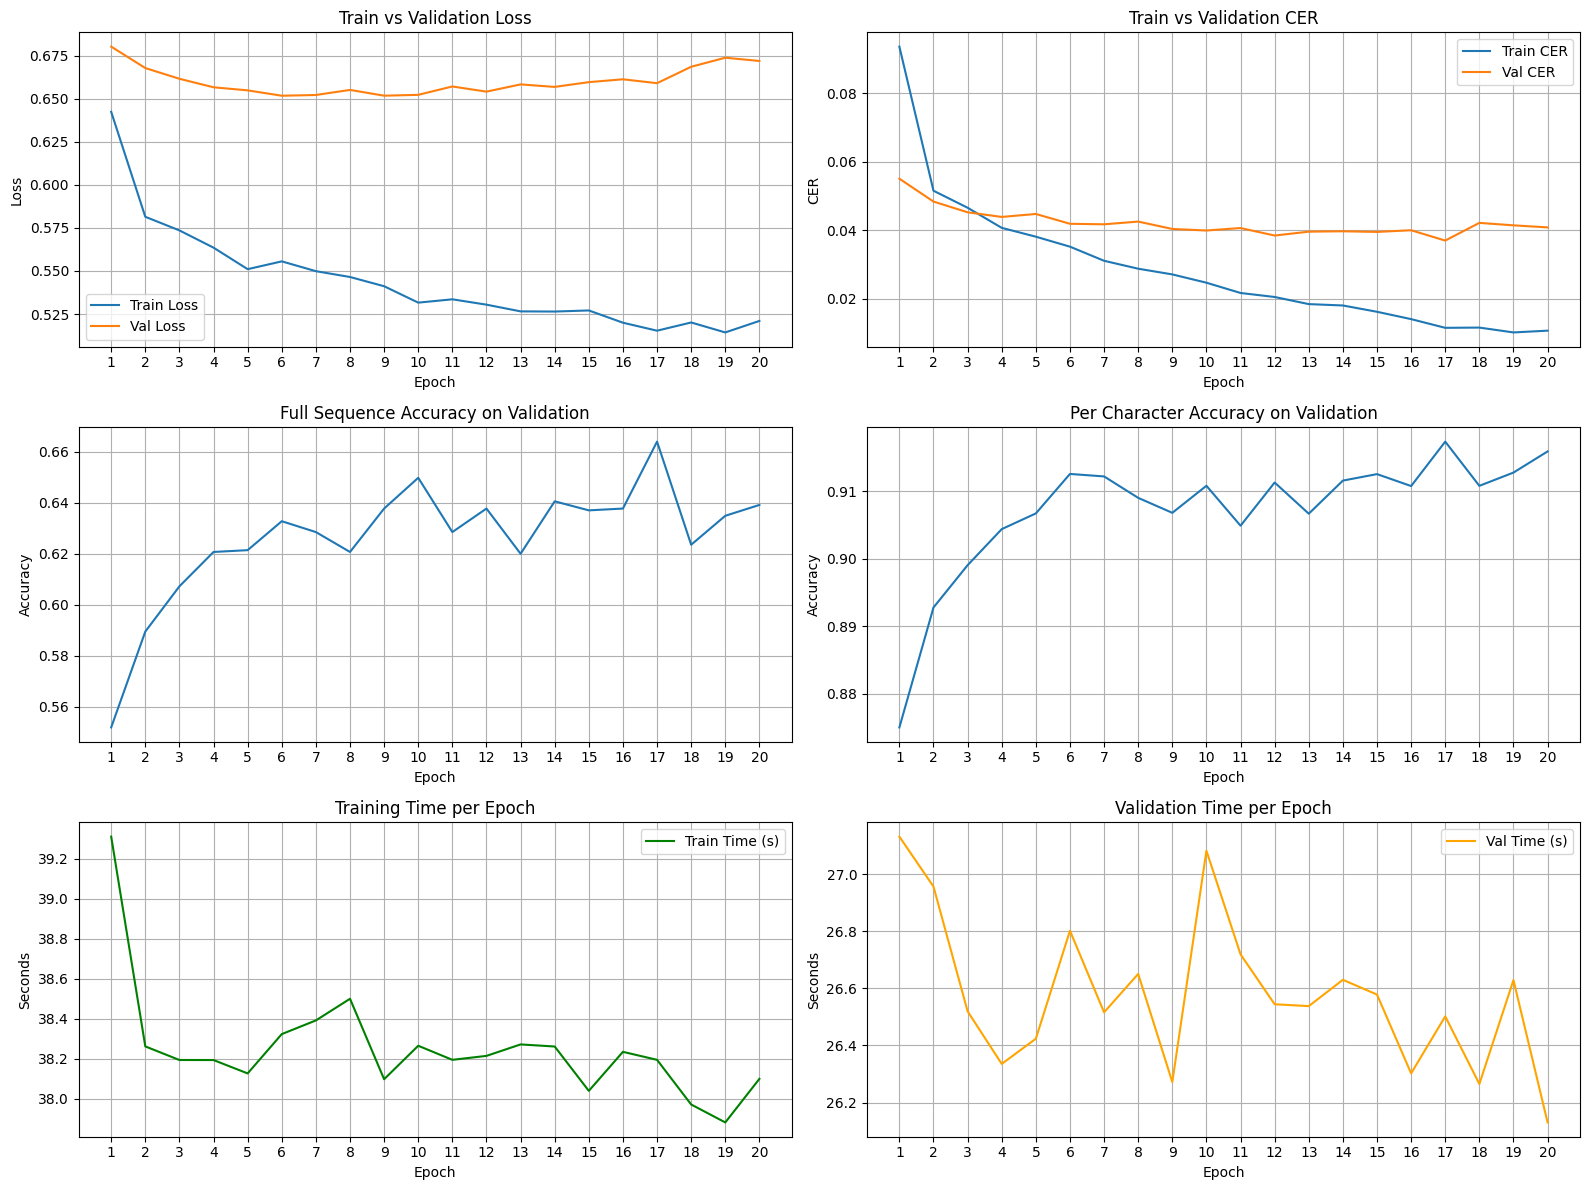

In [ ]:
# Path to metrics CSV file
csv_path = f"{root}/folds/fold_0/Transformer_metrics_fold_0.csv"

# Read CSV file
df = pd.read_csv(csv_path)

# Setup figure with 3x2 grid for 6 charts
plt.figure(figsize=(16, 12))

# === Loss Chart ===
plt.subplot(3, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === CER Chart ===
plt.subplot(3, 2, 2)
plt.plot(df['epoch'], df['train_cer'], label='Train CER')
plt.plot(df['epoch'], df['val_cer'], label='Val CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.title('Train vs Validation CER')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === Accuracy (Full Sequence) Chart ===
plt.subplot(3, 2, 3)
plt.plot(df['epoch'], df['acc_full_seq'], label='Acc Full Seq')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full Sequence Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Accuracy (Per Char) Chart ===
plt.subplot(3, 2, 4)
plt.plot(df['epoch'], df['acc_per_char'], label='Acc Per Char')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Per Character Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Train Time Chart ===
plt.subplot(3, 2, 5)
plt.plot(df['epoch'], df['train_time'], label='Train Time (s)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Training Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# === Validation Time Chart ===
plt.subplot(3, 2, 6)
plt.plot(df['epoch'], df['val_time'], label='Val Time (s)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Validation Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# Final layout adjustment and display
plt.tight_layout()
plt.show()


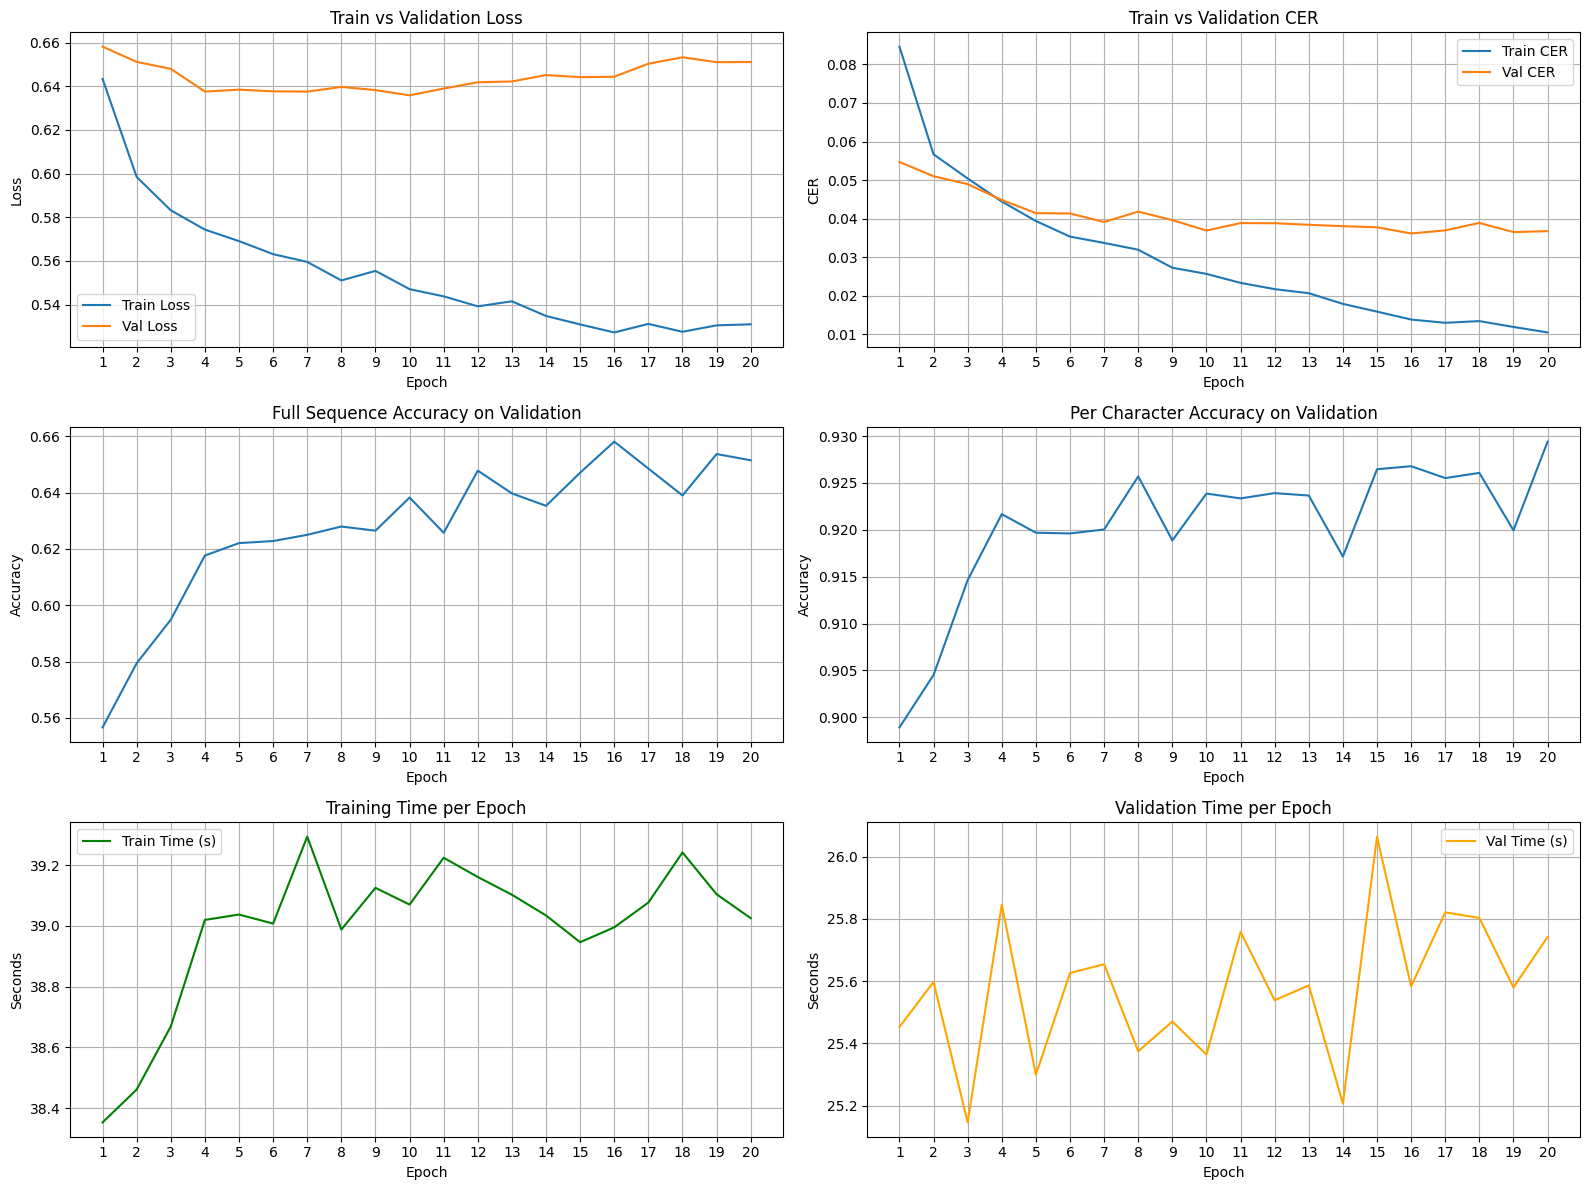

In [ ]:
# Path to metrics CSV file
csv_path = f"{root}/folds/fold_1/Transformer_metrics_fold_1.csv"

# Read CSV file
df = pd.read_csv(csv_path)

# Setup figure with 3x2 grid for 6 charts
plt.figure(figsize=(16, 12))

# === Loss Chart ===
plt.subplot(3, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === CER Chart ===
plt.subplot(3, 2, 2)
plt.plot(df['epoch'], df['train_cer'], label='Train CER')
plt.plot(df['epoch'], df['val_cer'], label='Val CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.title('Train vs Validation CER')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === Accuracy (Full Sequence) Chart ===
plt.subplot(3, 2, 3)
plt.plot(df['epoch'], df['acc_full_seq'], label='Acc Full Seq')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full Sequence Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Accuracy (Per Char) Chart ===
plt.subplot(3, 2, 4)
plt.plot(df['epoch'], df['acc_per_char'], label='Acc Per Char')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Per Character Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Train Time Chart ===
plt.subplot(3, 2, 5)
plt.plot(df['epoch'], df['train_time'], label='Train Time (s)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Training Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# === Validation Time Chart ===
plt.subplot(3, 2, 6)
plt.plot(df['epoch'], df['val_time'], label='Val Time (s)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Validation Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# Final layout adjustment and display
plt.tight_layout()
plt.show()


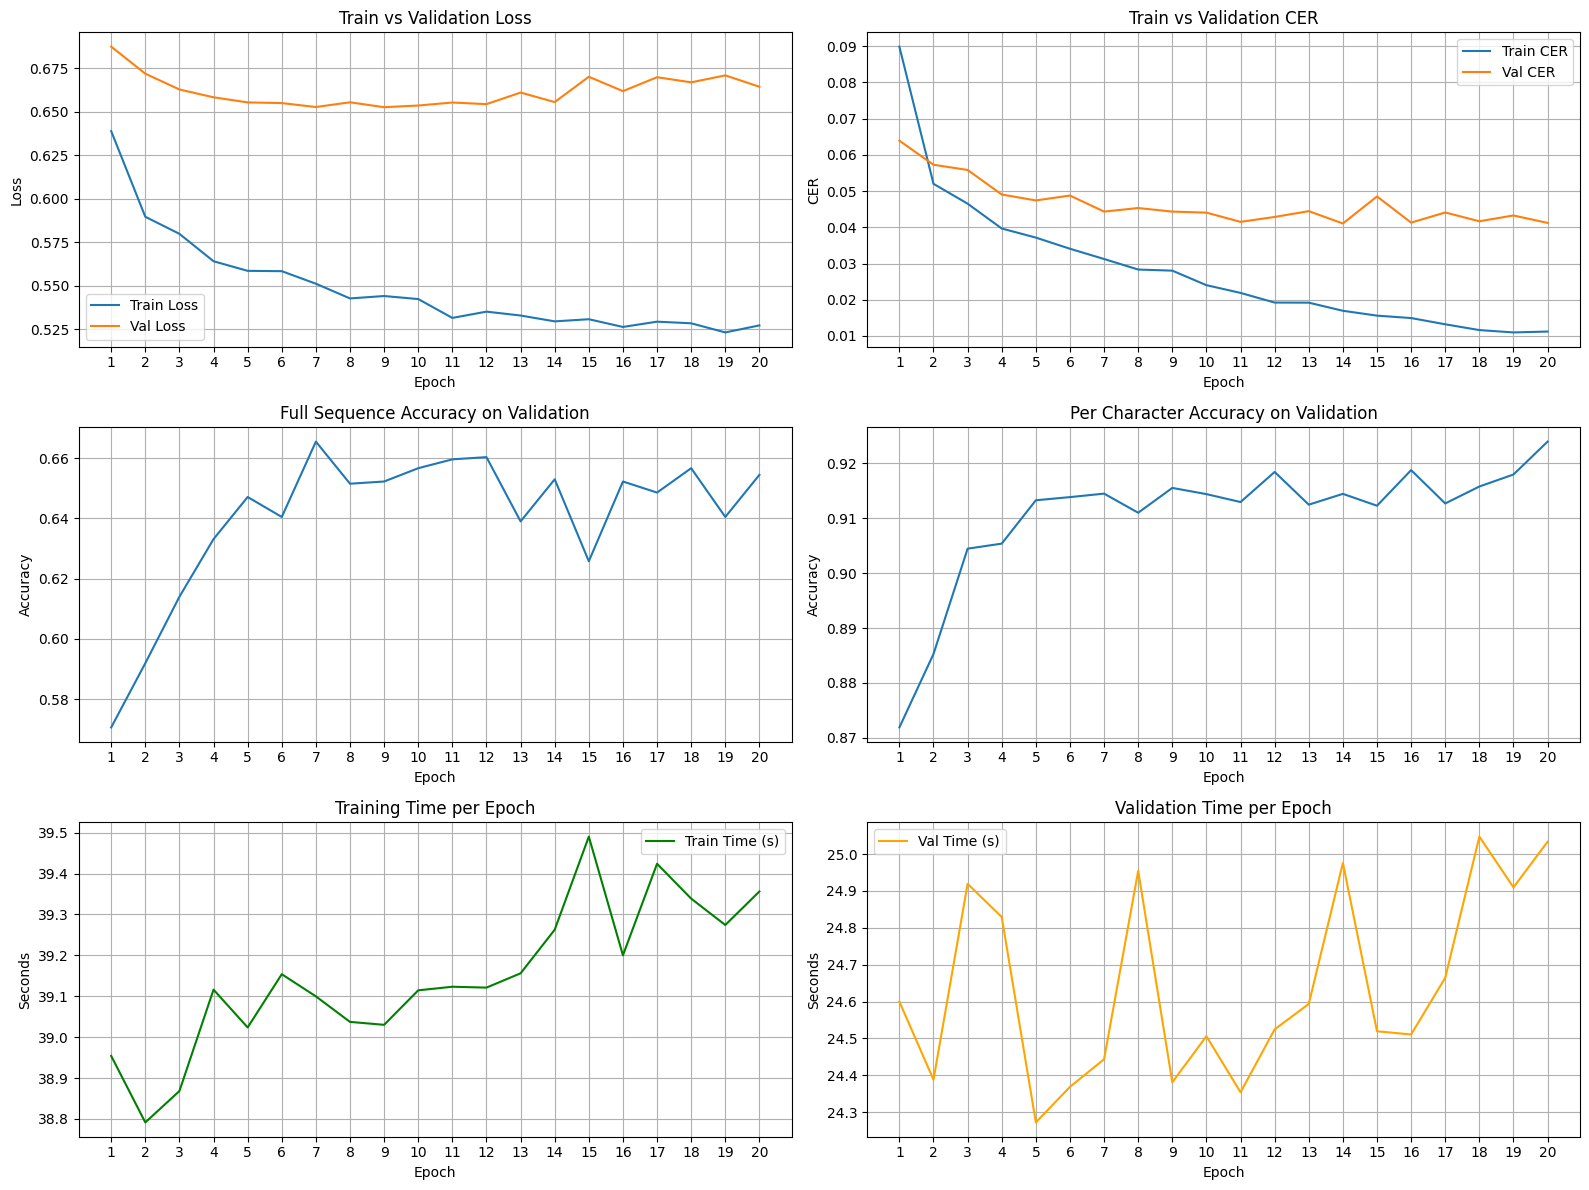

In [ ]:
# Path to metrics CSV file
csv_path = f"{root}/folds/fold_2/Transformer_metrics_fold_2.csv"

# Read CSV file
df = pd.read_csv(csv_path)

# Setup figure with 3x2 grid for 6 charts
plt.figure(figsize=(16, 12))

# === Loss Chart ===
plt.subplot(3, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === CER Chart ===
plt.subplot(3, 2, 2)
plt.plot(df['epoch'], df['train_cer'], label='Train CER')
plt.plot(df['epoch'], df['val_cer'], label='Val CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.title('Train vs Validation CER')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === Accuracy (Full Sequence) Chart ===
plt.subplot(3, 2, 3)
plt.plot(df['epoch'], df['acc_full_seq'], label='Acc Full Seq')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full Sequence Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Accuracy (Per Char) Chart ===
plt.subplot(3, 2, 4)
plt.plot(df['epoch'], df['acc_per_char'], label='Acc Per Char')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Per Character Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Train Time Chart ===
plt.subplot(3, 2, 5)
plt.plot(df['epoch'], df['train_time'], label='Train Time (s)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Training Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# === Validation Time Chart ===
plt.subplot(3, 2, 6)
plt.plot(df['epoch'], df['val_time'], label='Val Time (s)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Validation Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# Final layout adjustment and display
plt.tight_layout()
plt.show()


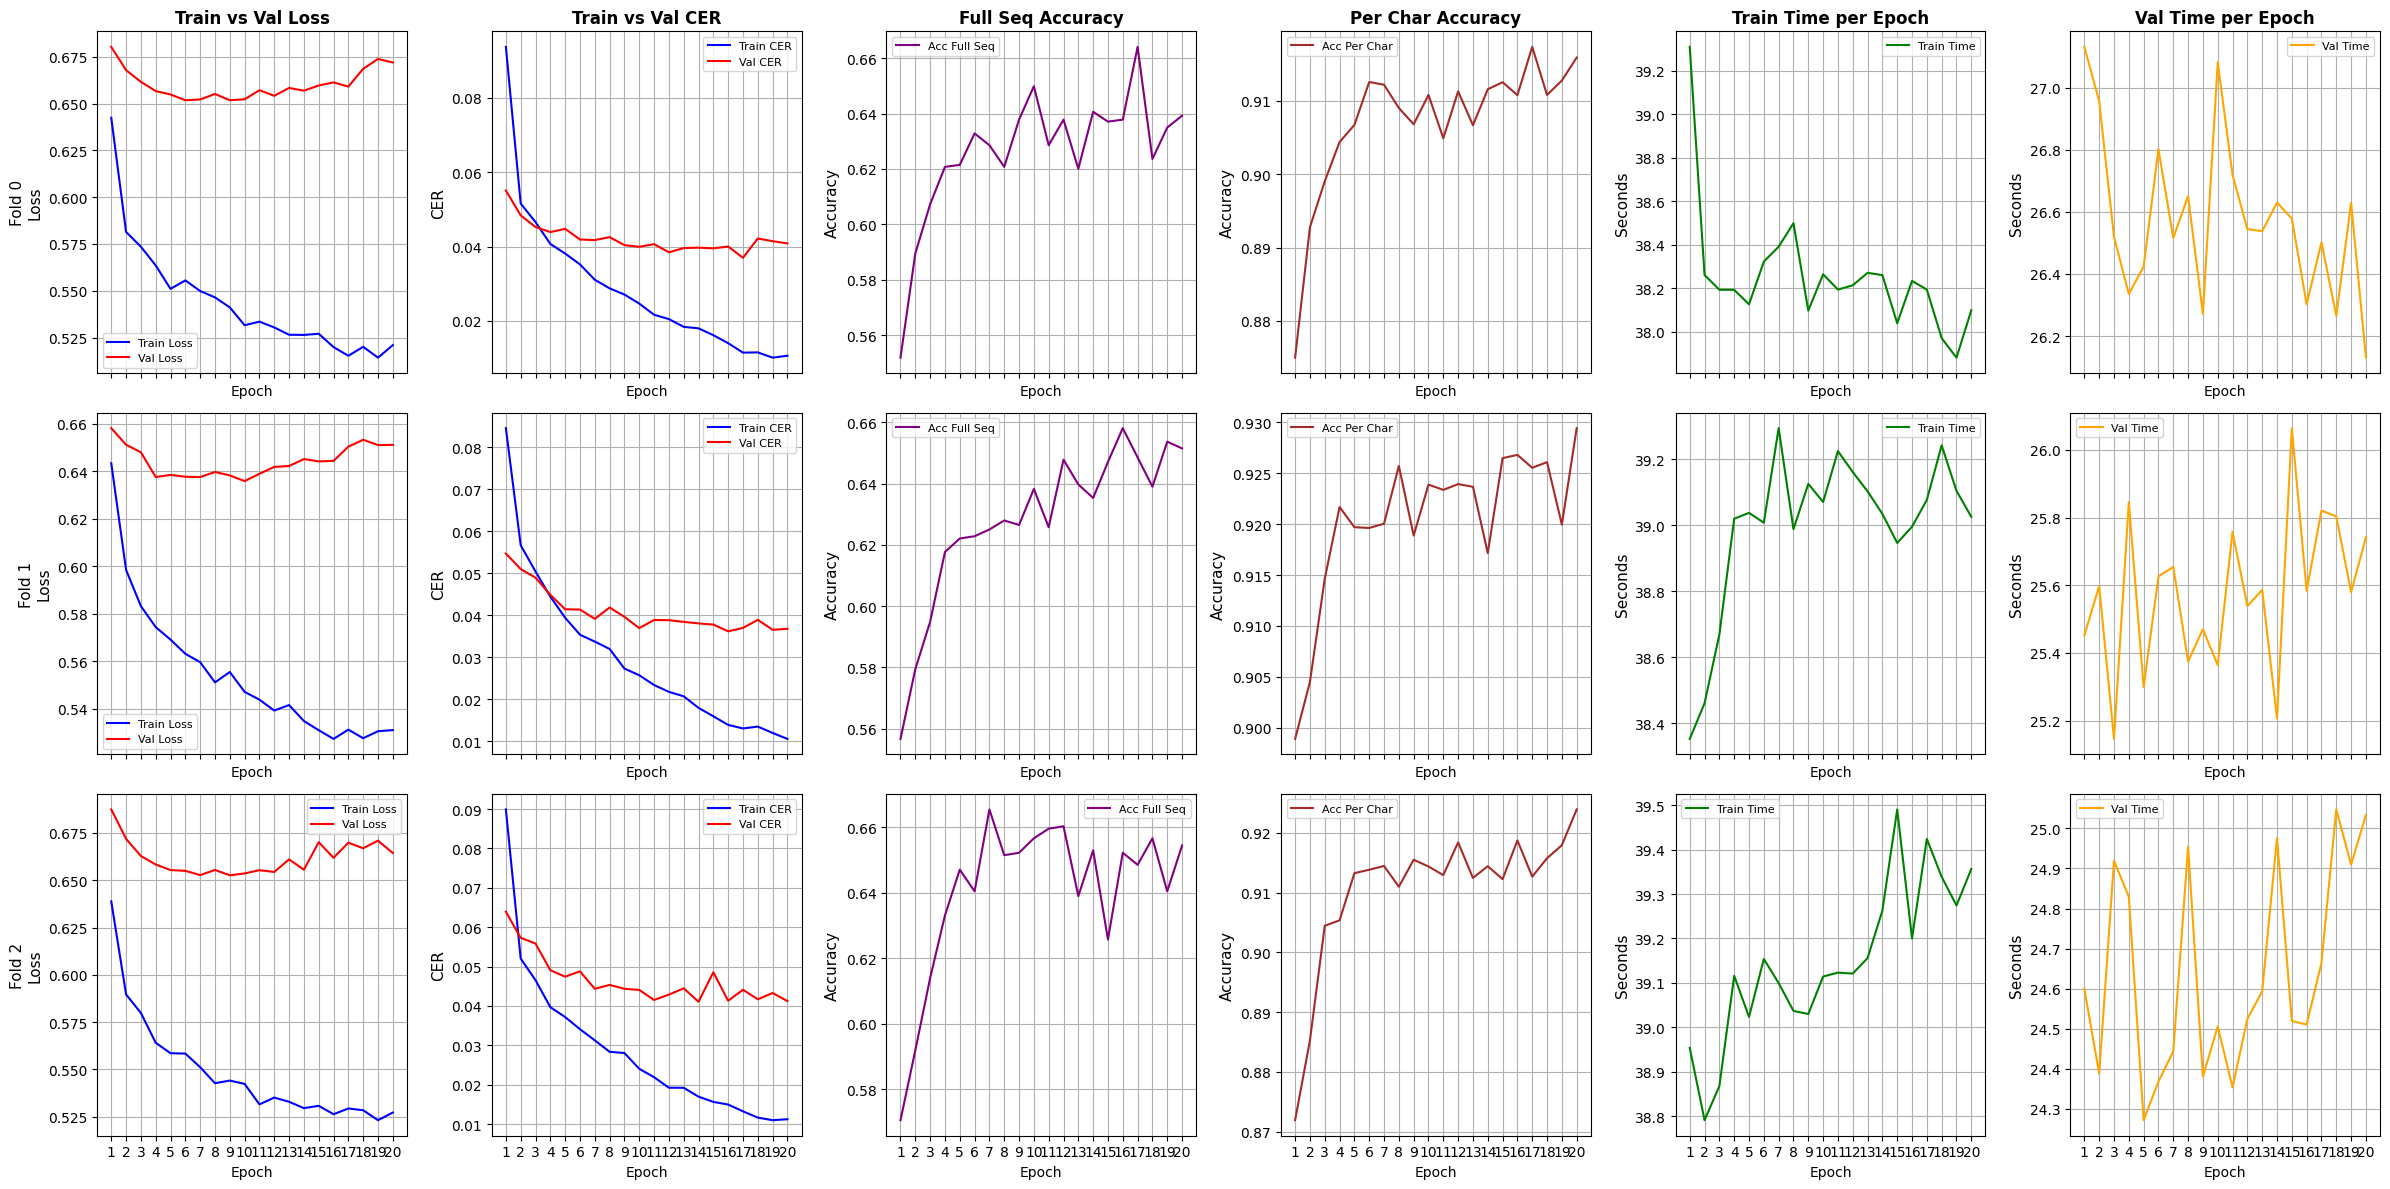

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

folds = [0, 1, 2]
metrics = ['train_loss', 'val_loss', 'train_cer', 'val_cer', 'acc_full_seq', 'acc_per_char', 'train_time', 'val_time']
titles = [
    'Train vs Val Loss', 'Train vs Val CER',
    'Full Seq Accuracy', 'Per Char Accuracy',
    'Train Time per Epoch', 'Val Time per Epoch'
]
ylabels = ['Loss', 'CER', 'Accuracy', 'Accuracy', 'Seconds', 'Seconds']
colors = [['blue', 'red'], ['blue', 'red'], ['purple'], ['brown'], ['green'], ['orange']]

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12), sharex='col')

for row_idx, fold in enumerate(folds):
    # Load CSV for current fold
    csv_path = f"{root}/folds/fold_{fold}/Transformer_metrics_fold_{fold}.csv"
    df = pd.read_csv(csv_path)

    # === Plot each of the 6 metrics ===
    for col_idx in range(6):
        ax = axes[row_idx, col_idx]

        if col_idx == 0:  # Loss
            ax.plot(df['epoch'], df['train_loss'], label='Train Loss', color=colors[col_idx][0])
            ax.plot(df['epoch'], df['val_loss'], label='Val Loss', color=colors[col_idx][1])
        elif col_idx == 1:  # CER
            ax.plot(df['epoch'], df['train_cer'], label='Train CER', color=colors[col_idx][0])
            ax.plot(df['epoch'], df['val_cer'], label='Val CER', color=colors[col_idx][1])
        elif col_idx == 2:  # Full Seq Acc
            ax.plot(df['epoch'], df['acc_full_seq'], label='Acc Full Seq', color=colors[col_idx][0])
        elif col_idx == 3:  # Per Char Acc
            ax.plot(df['epoch'], df['acc_per_char'], label='Acc Per Char', color=colors[col_idx][0])
        elif col_idx == 4:  # Train Time
            ax.plot(df['epoch'], df['train_time'], label='Train Time', color=colors[col_idx][0])
        elif col_idx == 5:  # Val Time
            ax.plot(df['epoch'], df['val_time'], label='Val Time', color=colors[col_idx][0])

        if row_idx == 0:
            ax.set_title(titles[col_idx], fontsize=12, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f"Fold {fold}\n{ylabels[col_idx]}", fontsize=11)
        else:
            ax.set_ylabel(ylabels[col_idx], fontsize=11)

        ax.set_xlabel('Epoch')
        ax.grid(True)
        ax.legend(fontsize=8)
        ax.set_xticks(df['epoch'])

plt.tight_layout()
plt.show()


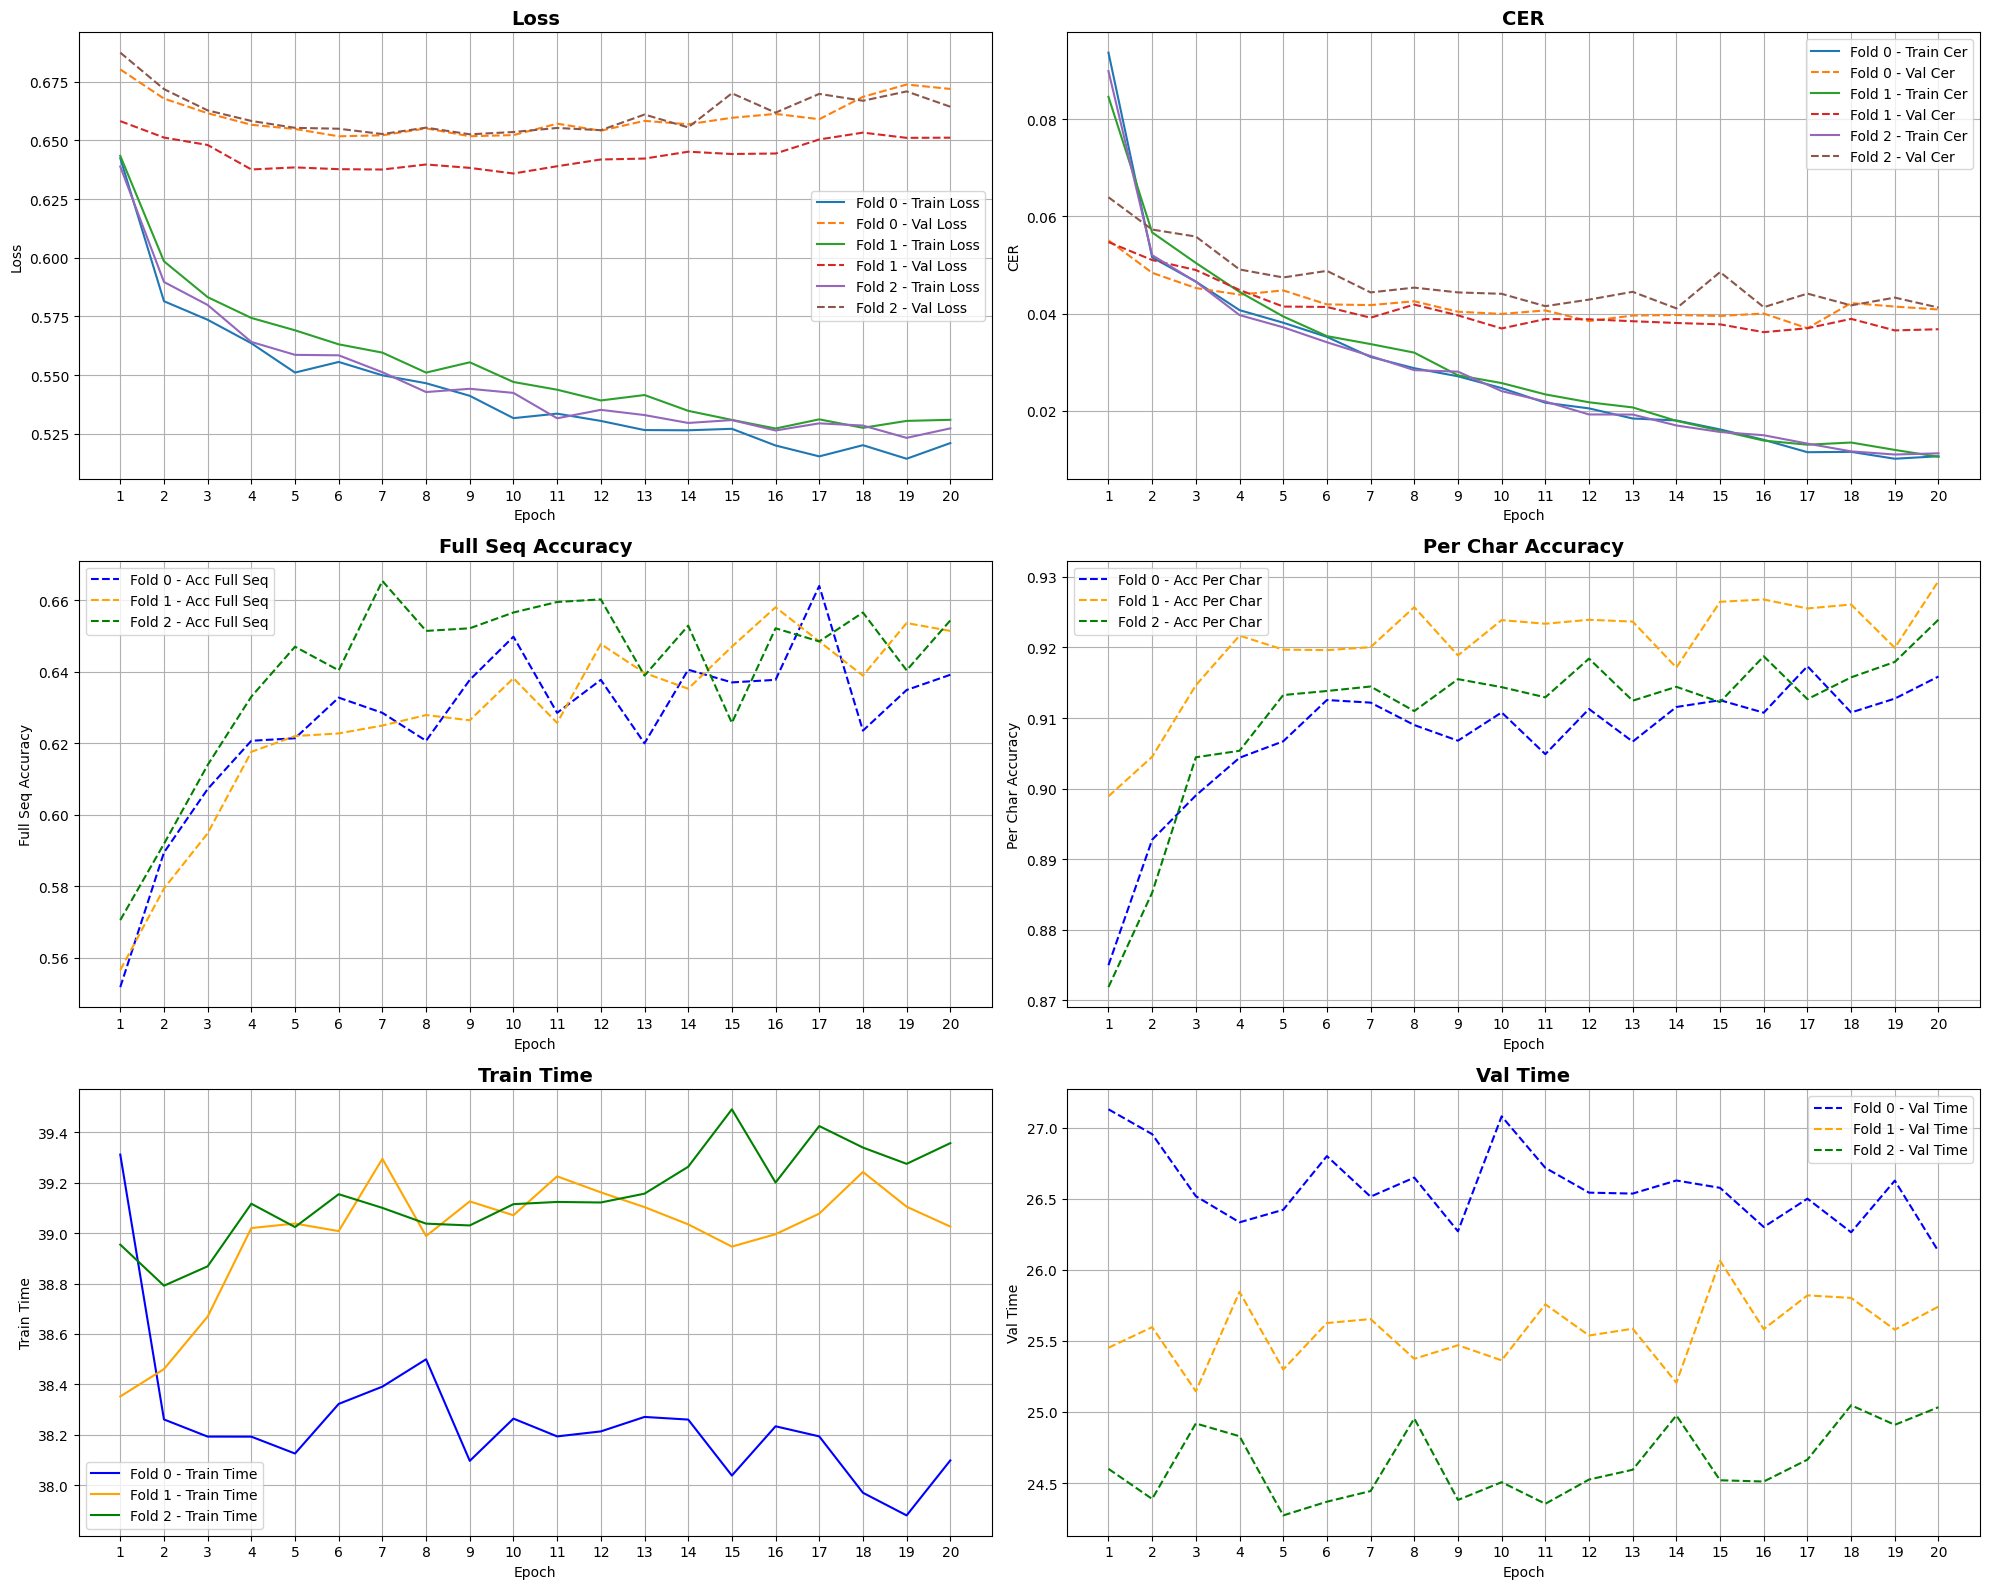

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

folds = [0, 1, 2]
fold_colors = ['blue', 'orange', 'green']
metric_info = {
    'Loss': ('train_loss', 'val_loss'),
    'CER': ('train_cer', 'val_cer'),
    'Full Seq Accuracy': ('acc_full_seq',),
    'Per Char Accuracy': ('acc_per_char',),
    'Train Time': ('train_time',),
    'Val Time': ('val_time',)
}

# Prepare the figure
plt.figure(figsize=(20, 16))

# Loop through metrics
for idx, (title, keys) in enumerate(metric_info.items(), 1):
    plt.subplot(3, 2, idx)

    # For each fold, plot the metric
    for fold, color in zip(folds, fold_colors):
        csv_path = f"{root}/folds/fold_{fold}/Transformer_metrics_fold_{fold}.csv"
        df = pd.read_csv(csv_path)

        for key in keys:
            label = f"Fold {fold} - {key.replace('_', ' ').title()}"
            plt.plot(df['epoch'], df[key], label=label, color=color if len(keys) == 1 else None, linestyle='-' if 'train' in key else '--')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel(title)
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.xticks(df['epoch'])

plt.tight_layout()
plt.show()


## LSTM

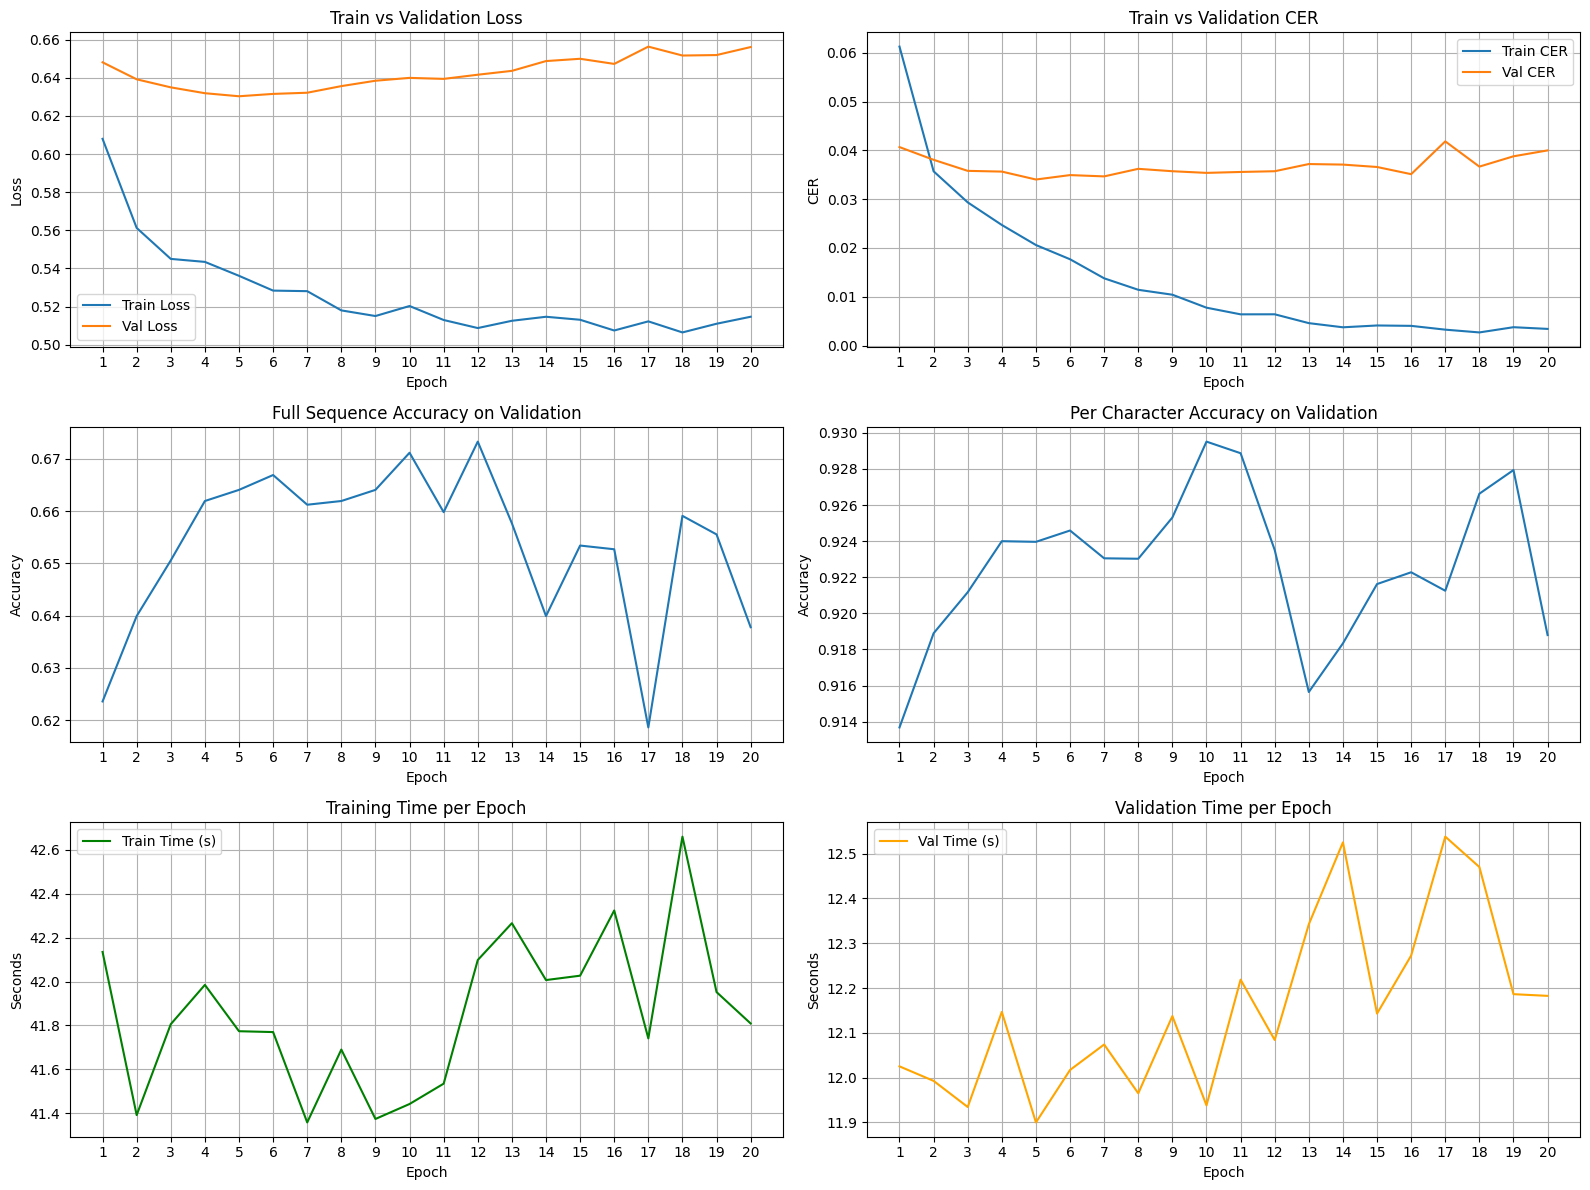

In [ ]:
# Path to metrics CSV file
csv_path = f"{root}/folds/fold_0/LSTM_metrics_fold_0.csv"

# Read CSV file
df = pd.read_csv(csv_path)

# Setup figure with 3x2 grid for 6 charts
plt.figure(figsize=(16, 12))

# === Loss Chart ===
plt.subplot(3, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === CER Chart ===
plt.subplot(3, 2, 2)
plt.plot(df['epoch'], df['train_cer'], label='Train CER')
plt.plot(df['epoch'], df['val_cer'], label='Val CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.title('Train vs Validation CER')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === Accuracy (Full Sequence) Chart ===
plt.subplot(3, 2, 3)
plt.plot(df['epoch'], df['acc_full_seq'], label='Acc Full Seq')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full Sequence Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Accuracy (Per Char) Chart ===
plt.subplot(3, 2, 4)
plt.plot(df['epoch'], df['acc_per_char'], label='Acc Per Char')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Per Character Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Train Time Chart ===
plt.subplot(3, 2, 5)
plt.plot(df['epoch'], df['train_time'], label='Train Time (s)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Training Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# === Validation Time Chart ===
plt.subplot(3, 2, 6)
plt.plot(df['epoch'], df['val_time'], label='Val Time (s)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Validation Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# Final layout adjustment and display
plt.tight_layout()
plt.show()


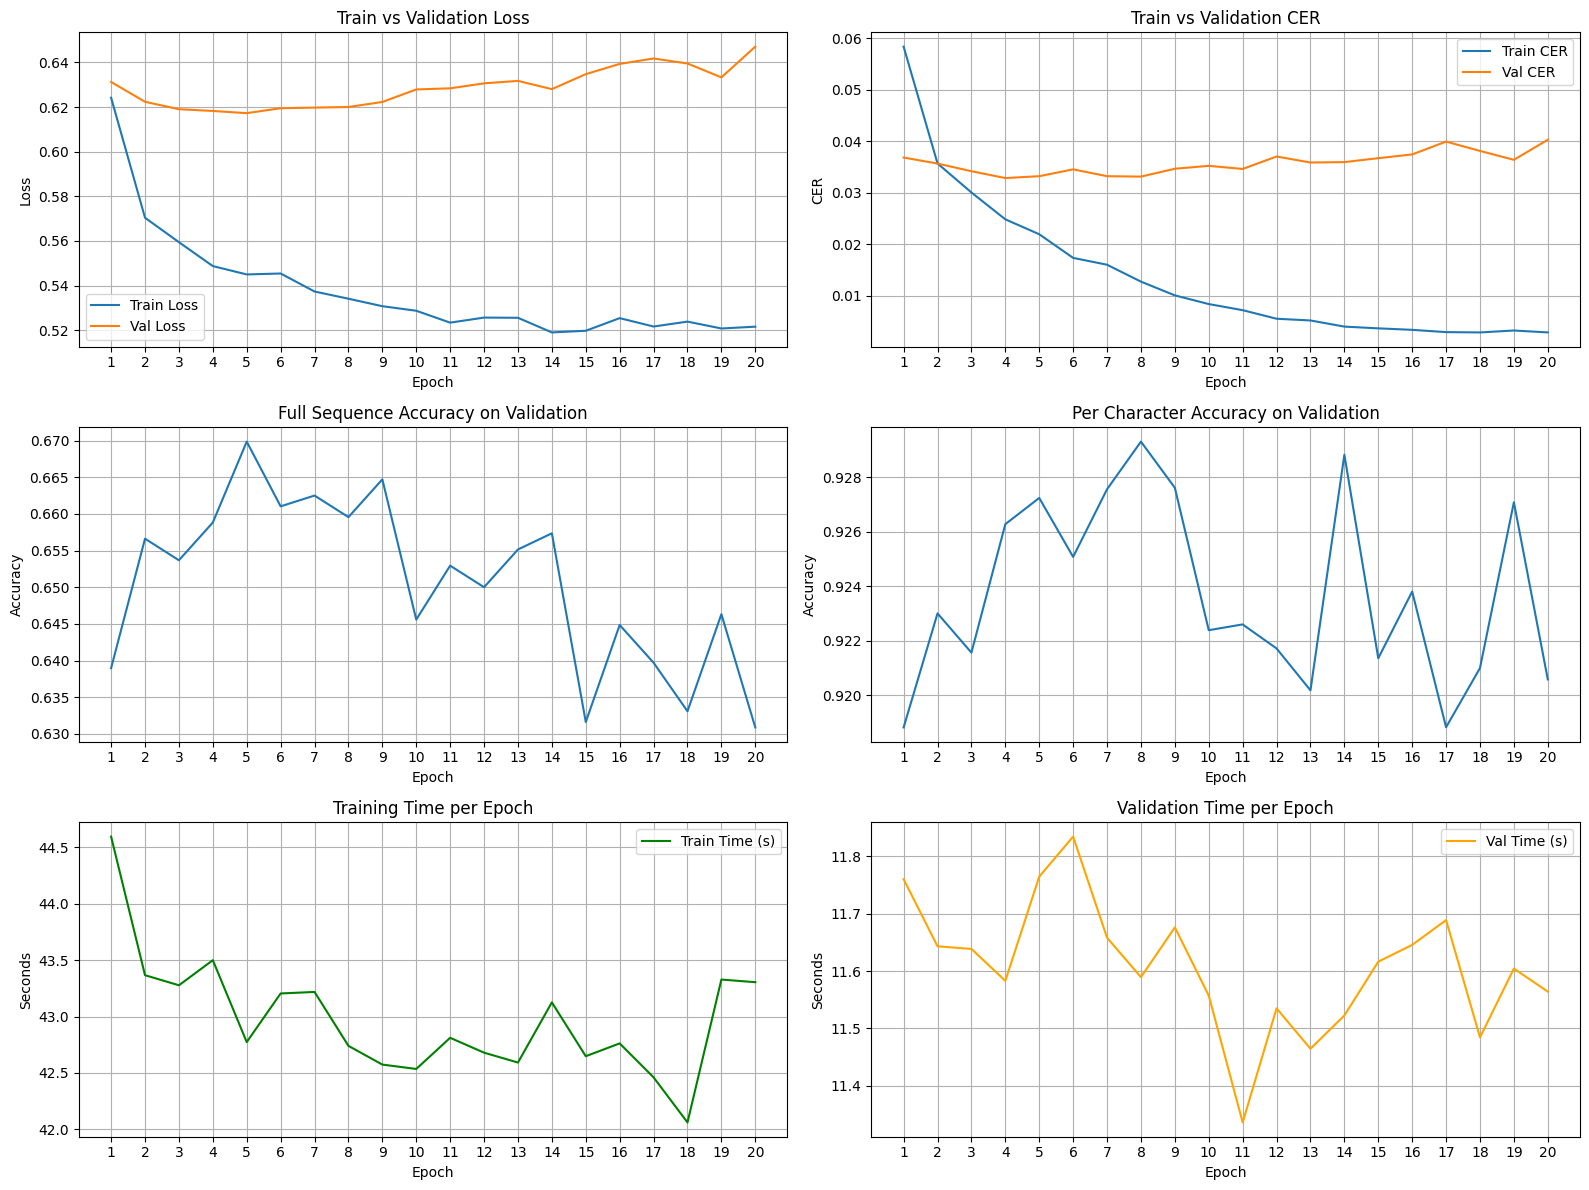

In [ ]:
# Path to metrics CSV file
csv_path = f"{root}/folds/fold_1/LSTM_metrics_fold_1.csv"

# Read CSV file
df = pd.read_csv(csv_path)

# Setup figure with 3x2 grid for 6 charts
plt.figure(figsize=(16, 12))

# === Loss Chart ===
plt.subplot(3, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === CER Chart ===
plt.subplot(3, 2, 2)
plt.plot(df['epoch'], df['train_cer'], label='Train CER')
plt.plot(df['epoch'], df['val_cer'], label='Val CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.title('Train vs Validation CER')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === Accuracy (Full Sequence) Chart ===
plt.subplot(3, 2, 3)
plt.plot(df['epoch'], df['acc_full_seq'], label='Acc Full Seq')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full Sequence Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Accuracy (Per Char) Chart ===
plt.subplot(3, 2, 4)
plt.plot(df['epoch'], df['acc_per_char'], label='Acc Per Char')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Per Character Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Train Time Chart ===
plt.subplot(3, 2, 5)
plt.plot(df['epoch'], df['train_time'], label='Train Time (s)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Training Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# === Validation Time Chart ===
plt.subplot(3, 2, 6)
plt.plot(df['epoch'], df['val_time'], label='Val Time (s)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Validation Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# Final layout adjustment and display
plt.tight_layout()
plt.show()


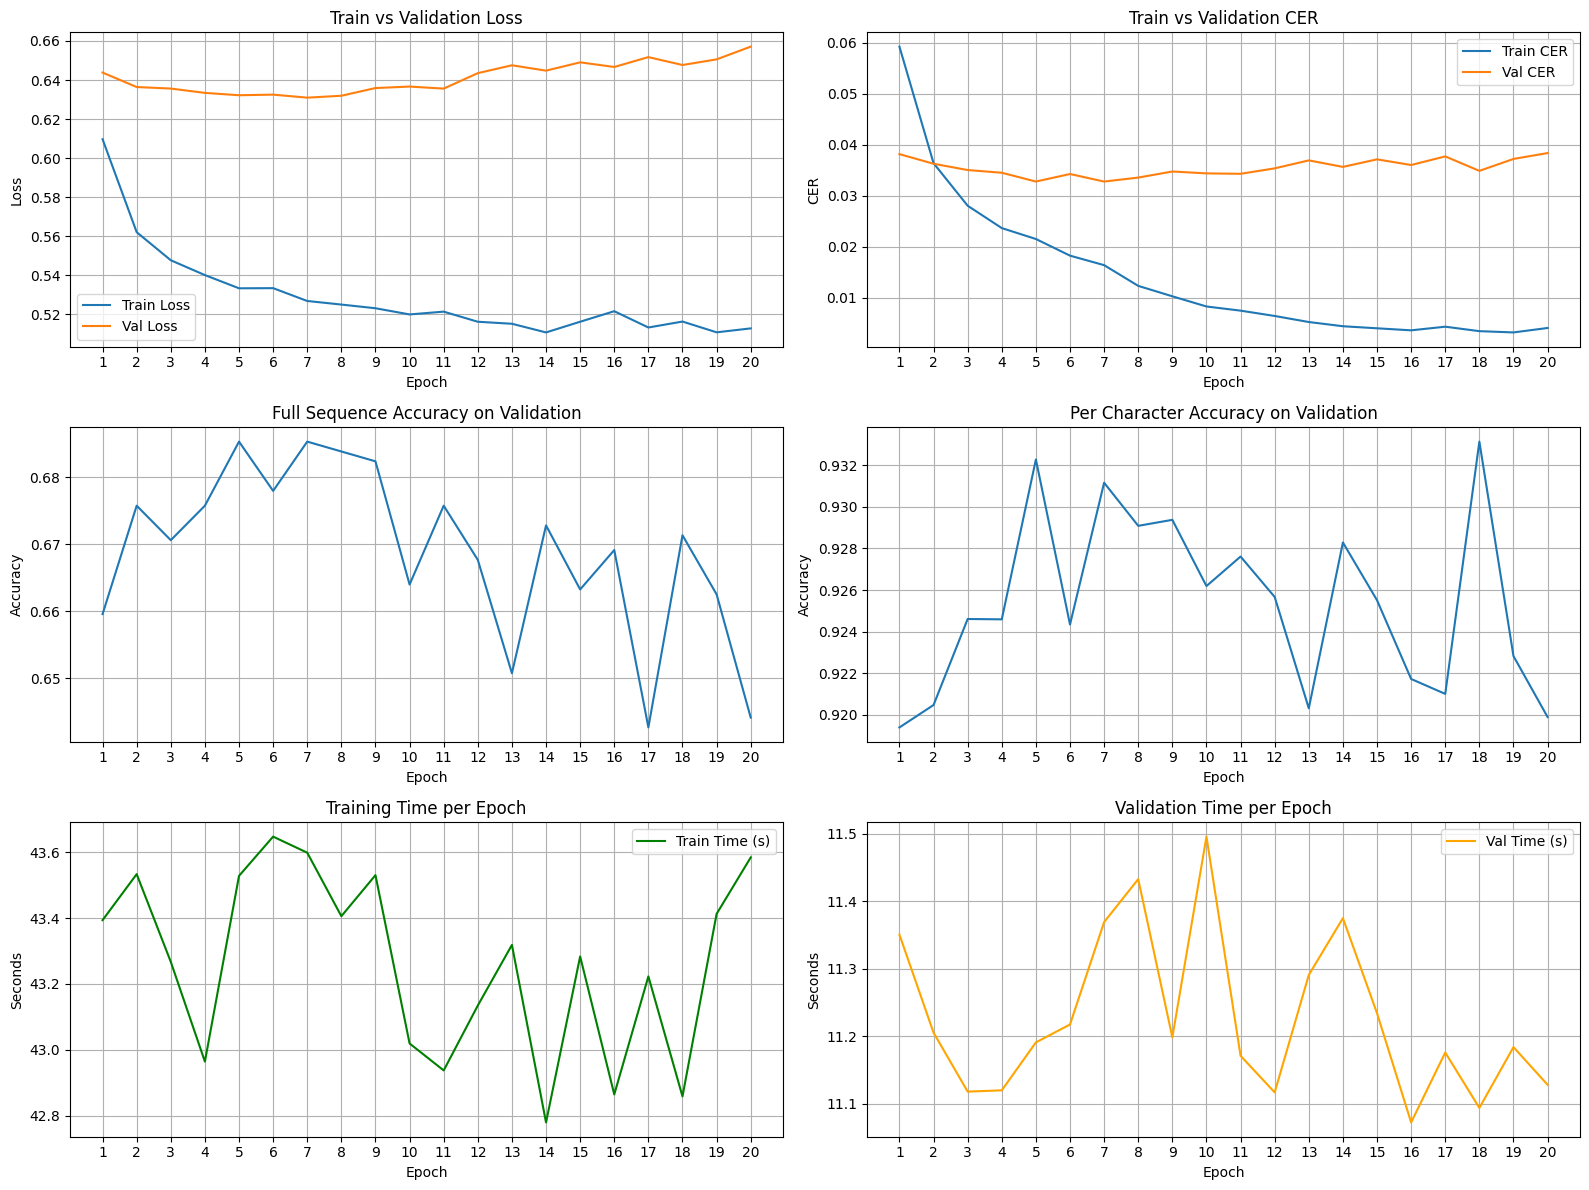

In [ ]:
# Path to metrics CSV file
csv_path = f"{root}/folds/fold_2/LSTM_metrics_fold_2.csv"

# Read CSV file
df = pd.read_csv(csv_path)

# Setup figure with 3x2 grid for 6 charts
plt.figure(figsize=(16, 12))

# === Loss Chart ===
plt.subplot(3, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === CER Chart ===
plt.subplot(3, 2, 2)
plt.plot(df['epoch'], df['train_cer'], label='Train CER')
plt.plot(df['epoch'], df['val_cer'], label='Val CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.title('Train vs Validation CER')
plt.xticks(df['epoch'])
plt.legend()
plt.grid(True)

# === Accuracy (Full Sequence) Chart ===
plt.subplot(3, 2, 3)
plt.plot(df['epoch'], df['acc_full_seq'], label='Acc Full Seq')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Full Sequence Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Accuracy (Per Char) Chart ===
plt.subplot(3, 2, 4)
plt.plot(df['epoch'], df['acc_per_char'], label='Acc Per Char')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Per Character Accuracy on Validation')
plt.xticks(df['epoch'])
plt.grid(True)

# === Train Time Chart ===
plt.subplot(3, 2, 5)
plt.plot(df['epoch'], df['train_time'], label='Train Time (s)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Training Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# === Validation Time Chart ===
plt.subplot(3, 2, 6)
plt.plot(df['epoch'], df['val_time'], label='Val Time (s)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.title('Validation Time per Epoch')
plt.xticks(df['epoch'])
plt.grid(True)
plt.legend()

# Final layout adjustment and display
plt.tight_layout()
plt.show()


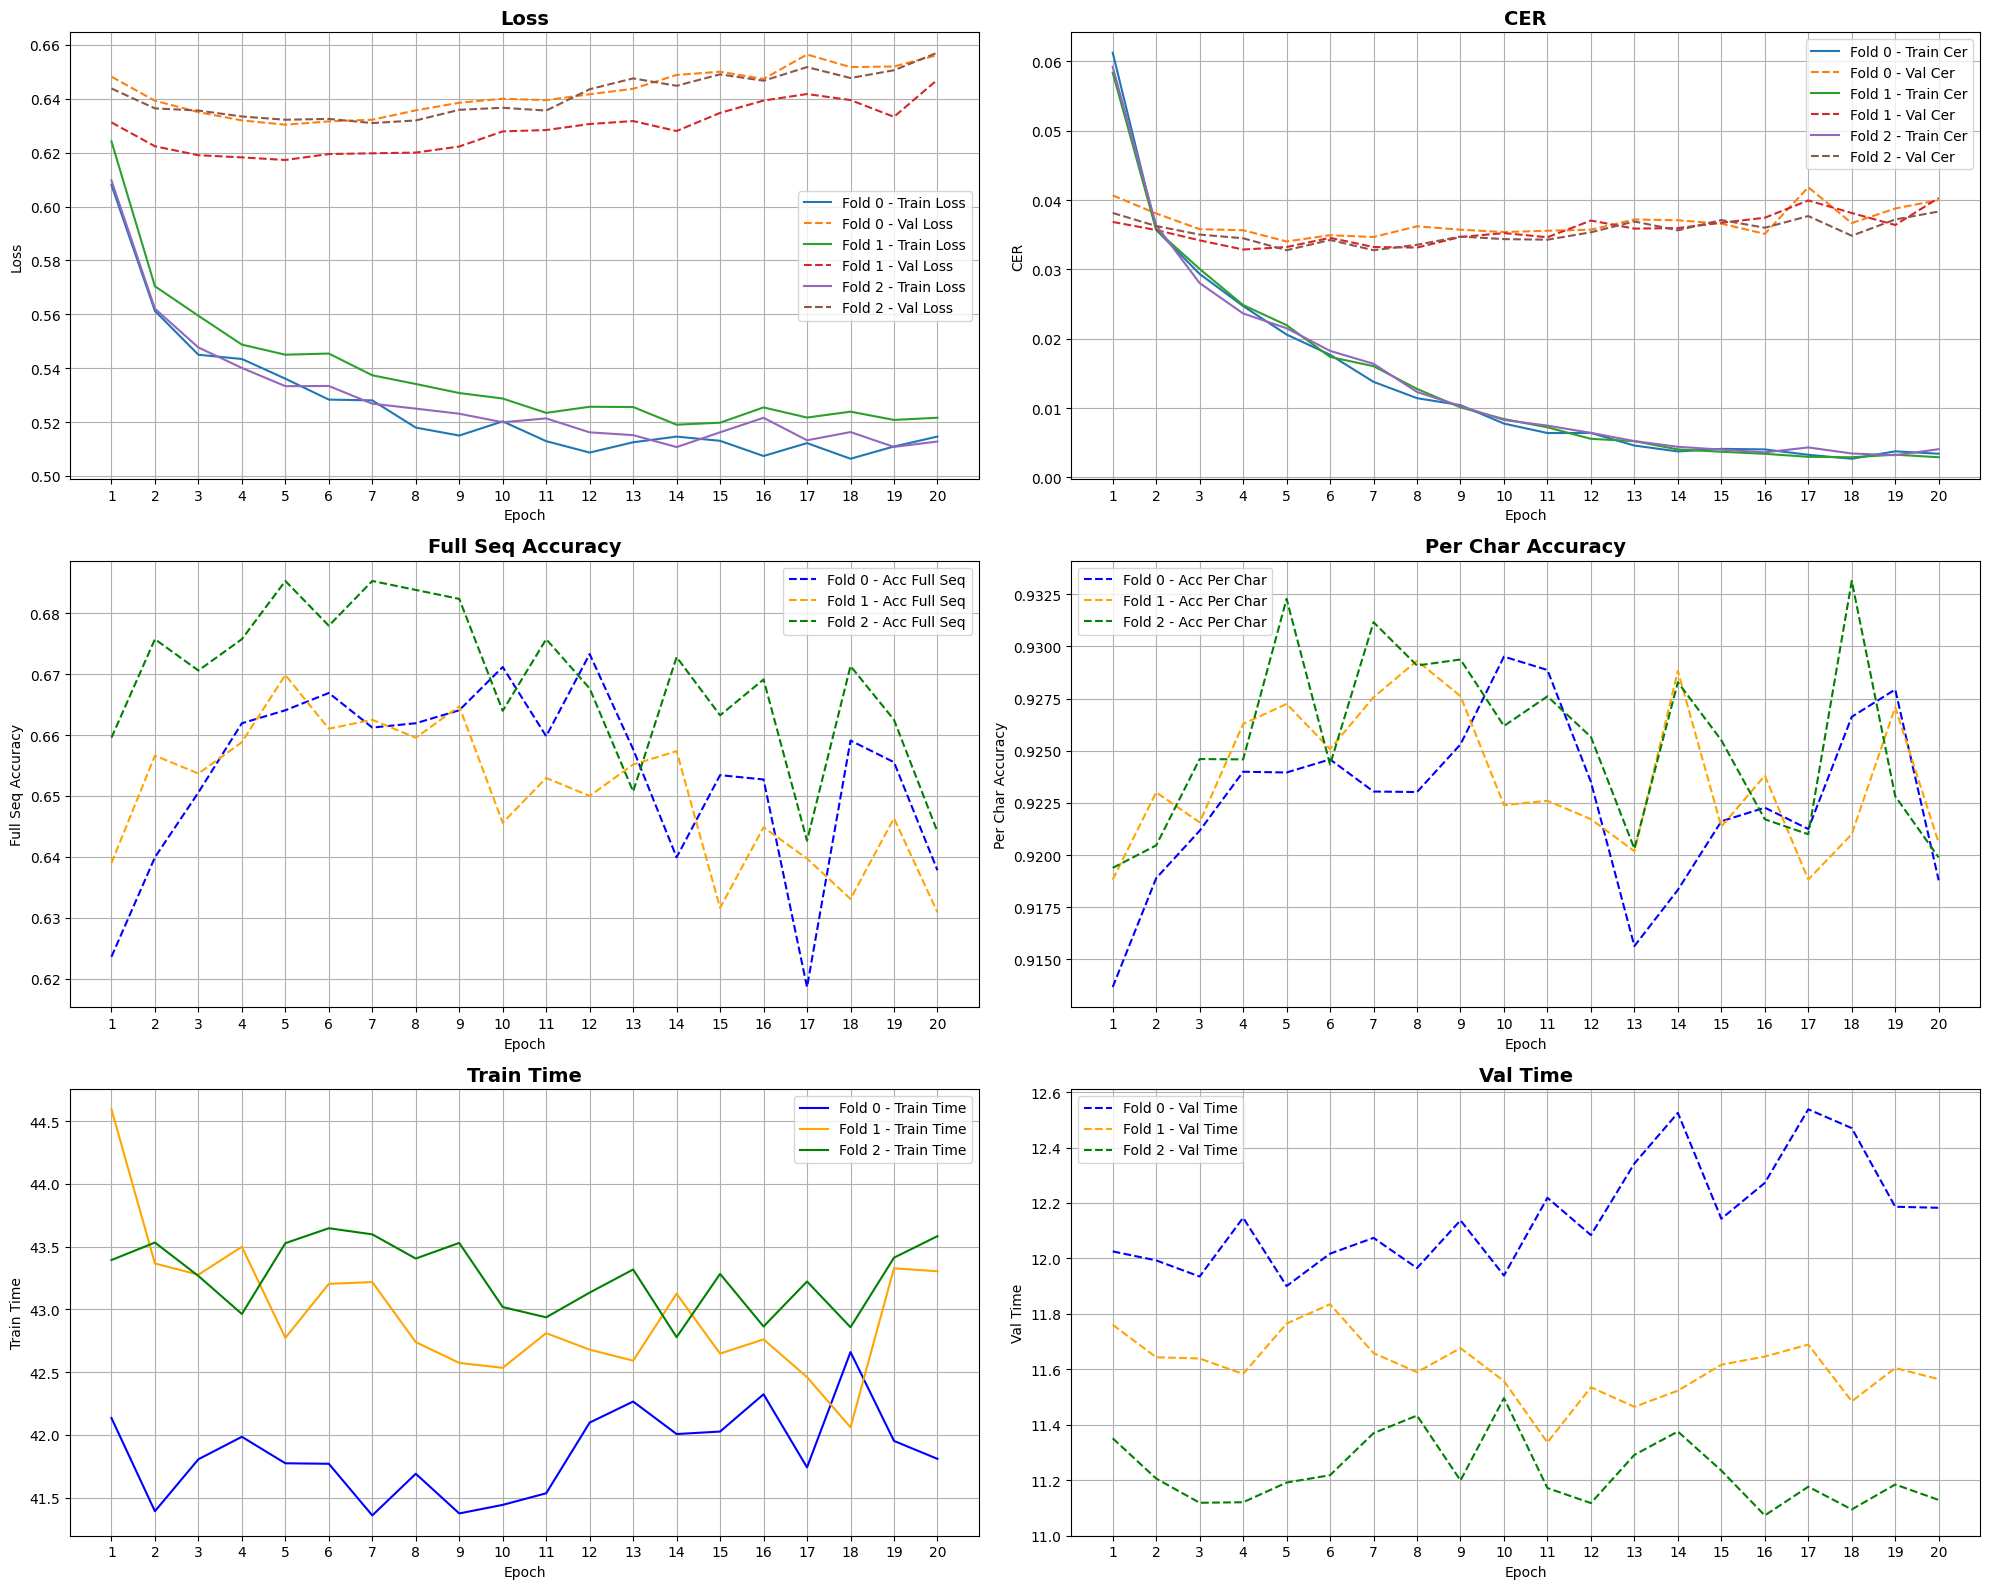

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

folds = [0, 1, 2]
fold_colors = ['blue', 'orange', 'green']
metric_info = {
    'Loss': ('train_loss', 'val_loss'),
    'CER': ('train_cer', 'val_cer'),
    'Full Seq Accuracy': ('acc_full_seq',),
    'Per Char Accuracy': ('acc_per_char',),
    'Train Time': ('train_time',),
    'Val Time': ('val_time',)
}

# Prepare the figure
plt.figure(figsize=(20, 16))

# Loop through metrics
for idx, (title, keys) in enumerate(metric_info.items(), 1):
    plt.subplot(3, 2, idx)

    # For each fold, plot the metric
    for fold, color in zip(folds, fold_colors):
        csv_path = f"{root}/folds/fold_{fold}/LSTM_metrics_fold_{fold}.csv"
        df = pd.read_csv(csv_path)

        for key in keys:
            label = f"Fold {fold} - {key.replace('_', ' ').title()}"
            plt.plot(df['epoch'], df[key], label=label, color=color if len(keys) == 1 else None, linestyle='-' if 'train' in key else '--')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel(title)
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.xticks(df['epoch'])

plt.tight_layout()
plt.show()
